# Smart Mobility
## Análisis de datos de tráfico de Monterrey, México

In [ ]:
pip install pyarrow h3 seaborn geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import math
from matplotlib import pyplot as plt
import numpy as np
import geopandas
import h3 as h3lib
import plotly.express as px
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon
from geopy.distance import geodesic
from shapely import wkt
import seaborn as sns
from google.colab import drive
from google.colab import output
from datetime import datetime
import time
output.enable_custom_widget_manager()
drive.mount('/content/drive')

Mounted at /content/drive


##Aplicación de H3 y AGEB

In [ ]:
#Lectura de base de datos
stops = pd.read_parquet('/content/drive/MyDrive/Smart Mobility/data/totalstops.parquet',engine='pyarrow')

In [ ]:
stops['datehour'] = stops['datetime'].dt.hour
stops

uid        lat  \
0        0000247d3716ba369e6a7958c6a7bfd75e042439d6c42c...  25.710580   
1        0000247d3716ba369e6a7958c6a7bfd75e042439d6c42c...  25.671685   
2        00003b4173da327cc893cd4bdaf98330fc4542ef65008f...  25.791510   
3        00003b4173da327cc893cd4bdaf98330fc4542ef65008f...  25.777420   
4        00003b4173da327cc893cd4bdaf98330fc4542ef65008f...  25.791570   
...                                                    ...        ...   
5497645  ffffc1aa7c87557be038dcb0bad7d3452f321752bd2afb...  25.205430   
5497646  ffffc1aa7c87557be038dcb0bad7d3452f321752bd2afb...  25.843522   
5497647  ffffc1aa7c87557be038dcb0bad7d3452f321752bd2afb...  25.843330   
5497648  fffff4964a0b83f35268434d3a88386865327b166ffe0a...  25.728400   
5497649  fffff4964a0b83f35268434d3a88386865327b166ffe0a...  25.728980   

               lng                  datetime  dsemana  \
0       -100.24634 2019-11-06 19:33:11-06:00        2   
1       -100.14502 2019-12-05 19:51:00-06:00        3   
2       -100.18669 2019-10-30 18:01:54-06:00        3   
3       -100.18879 2019-10-31 15:07:26-06:00        3   
4       -100.18661 2019-11-04 00:00:23-06:00        0   
...            ...                       ...      ...   
5497645  -99.83237 2019-12-01 01:26:27-06:00        6   
5497646 -100.42299 2019-12-01 07:42:41-06:00        6   
5497647 -100.42310 2019-12-22 23:22:28-06:00        6   
5497648 -100.32816 2019-11-03 05:03:21-06:00        6   
5497649 -100.32211 2019-11-03 09:51:13-06:00        6   

                 leaving_datetime  datetime_size  date_startstop  \
0       2019-11-06 20:47:52-06:00       1.244722              19   
1       2019-12-05 21:03:46-06:00       1.212778              19   
2       2019-10-31 15:07:26-06:00      21.092222              18   
3       2019-10-31 15:24:07-06:00       0.278056              15   
4       2019-11-04 14:56:53-06:00      14.941667               0   
...                           ...            ...             ...   
5497645 2019-12-01 07:42:41-06:00       6.270556               1   
5497646 2019-12-01 13:08:00-06:00       5.421944               7   
5497647 2019-12-22 23:51:00-06:00       0.475556              23   
5497648 2019-11-03 09:51:13-06:00       4.797778               5   
5497649 2019-11-03 14:40:34-06:00       4.822500               9   

         date_endstop        date  datehour  
0                  20  2019-11-06        19  
1                  21  2019-12-05        19  
2                  15  2019-10-30        18  
3                  15  2019-10-31        15  
4                  14  2019-11-04         0  
...               ...         ...       ...  
5497645             7  2019-12-01         1  
5497646            13  2019-12-01         7  
5497647            23  2019-12-22        23  
5497648             9  2019-11-03         5  
5497649            14  2019-11-03         9  

[20007227 rows x 11 columns]

In [ ]:
#AGEB con información de la población del área metropolitana de Monterrey
AGEB1=pd.DataFrame(geopandas.read_file('/content/drive/MyDrive/Smart Mobility/data/AGEB_ZMM.json'))
AGEB2= pd.DataFrame(geopandas.read_file('/content/drive/MyDrive/Smart Mobility/data/AGEB_RUR_ZMM_JSO_A.json'))

AGEB1 = AGEB1.drop(['OBJECTID', 'CVEGEO', 'CVE_ENT', 'CVE_MUN', 'CVE_LOC', 'CVE_AGEB','ENTIDAD', 'NOM_ENT', 'MUN', 'NOM_MUN', 'LOC', 'NOM_LOC', 'AGEB', 'MZA', 'POBFEM', 'POBMAS', 'CVEGEO_1'],axis=1)
AGEB1

POBTOT               AreaKm2          Dens_Pobl  Shape_Length  \
0       5914   0.35891017317771912     16477.66015625      0.028421   
1        961  0.074468597769737244   12904.7685546875      0.011534   
2       4680   0.32702681422233582   14310.7529296875      0.031965   
3          0   0.91719150543212891                  0      0.039103   
4       2396   0.95030927658081055  2521.284423828125      0.049143   
...      ...                   ...                ...           ...   
2023    4998   0.38165146112442017   13095.7177734375      0.031456   
2024    4566   0.51598548889160156       8849.0859375      0.047032   
2025    3133   0.31339189410209656    9997.0673828125      0.025295   
2026    4754   0.90056991577148438   5278.87939453125      0.042420   
2027    2089   0.29044061899185181   7192.52001953125      0.026045   

      Shape_Area                                           geometry  
0       0.000032  POLYGON ((-100.22746 25.81480, -100.22756 25.8...  
1       0.000007  POLYGON ((-100.15965 25.71443, -100.15965 25.7...  
2       0.000029  POLYGON ((-100.23821 25.78282, -100.23839 25.7...  
3       0.000083  POLYGON ((-100.19131 25.76700, -100.19138 25.7...  
4       0.000086  POLYGON ((-100.25997 25.82779, -100.26039 25.8...  
...          ...                                                ...  
2023    0.000034  POLYGON ((-100.26269 25.87542, -100.26378 25.8...  
2024    0.000046  POLYGON ((-100.26623 25.86789, -100.26660 25.8...  
2025    0.000028  POLYGON ((-100.11276 25.69828, -100.11283 25.6...  
2026    0.000081  POLYGON ((-100.27147 25.89007, -100.27116 25.8...  
2027    0.000026  POLYGON ((-100.11439 25.68954, -100.11443 25.6...  

[2028 rows x 6 columns]

In [ ]:
#Clean only one stop user
users = pd.DataFrame(stops['uid'].unique(), columns=['uid'])
users['count_stops'] = users['uid'].map(stops['uid'].value_counts())
#9.222.038
users = users[users['count_stops'] >= 100]
users
#57.008

uid  count_stops
10      0000dd75ae4e69fce99e5cb6395014a989b042fa95cb51...          198
21      000239dced8f72a339db8ee66b8b1eab6d101f77492355...          158
31      0002fff489f62faeef9120082904520e06187ffdb67066...          121
39      0003ca5eb4d52dcc245d105065e2768d8eeac30f55ff15...          368
52      0004b046c2fcf719917c3a71e408f5086ea0e8dfb4a0d9...          206
...                                                   ...          ...
656603  8a0eb7e3446c30d0ad34f08161ec1a78d8eb6a34796a3f...          160
664135  9ec71fc1ff2d29c306cb4dc73aaa584e88df533eeaada5...          140
667089  a6db4c751589a4f2bef0dce67aecb882d5b213e12ffbe5...          197
680071  cb373ecf99072dbcad0210d91f6d399b670209a2335802...          187
685300  d9ab98013f322ff69d8a311c1c91f1f7251bd0e9af73dc...          355

[57008 rows x 2 columns]

In [ ]:
final_stops = pd.merge(stops, users, on ='uid', how ='outer')
final_stops['count_stops'] = final_stops['count_stops'].fillna(0)
final_stops = final_stops[final_stops['count_stops'] != 0]
# 1'1060.268 stops
final_stops

uid        lat  \
154       0000dd75ae4e69fce99e5cb6395014a989b042fa95cb51...  25.621187   
155       0000dd75ae4e69fce99e5cb6395014a989b042fa95cb51...  25.621847   
156       0000dd75ae4e69fce99e5cb6395014a989b042fa95cb51...  25.621859   
157       0000dd75ae4e69fce99e5cb6395014a989b042fa95cb51...  25.656251   
158       0000dd75ae4e69fce99e5cb6395014a989b042fa95cb51...  25.651635   
...                                                     ...        ...   
19961088  d9ab98013f322ff69d8a311c1c91f1f7251bd0e9af73dc...  25.677951   
19961089  d9ab98013f322ff69d8a311c1c91f1f7251bd0e9af73dc...  25.449939   
19961090  d9ab98013f322ff69d8a311c1c91f1f7251bd0e9af73dc...  25.286415   
19961091  d9ab98013f322ff69d8a311c1c91f1f7251bd0e9af73dc...  25.278518   
19961092  d9ab98013f322ff69d8a311c1c91f1f7251bd0e9af73dc...  25.278418   

                 lng                  datetime  dsemana  \
154      -100.365402 2019-12-02 00:07:22-06:00        0   
155      -100.364997 2019-12-02 08:07:04-06:00        0   
156      -100.365017 2019-12-02 09:01:38-06:00        0   
157      -100.385282 2019-12-02 09:37:36-06:00        0   
158      -100.365385 2019-12-02 10:16:05-06:00        0   
...              ...                       ...      ...   
19961088 -100.299015 2019-12-29 17:44:39-06:00        6   
19961089 -100.161371 2019-12-29 18:18:03-06:00        6   
19961090 -100.017900 2019-12-29 19:04:02-06:00        6   
19961091 -100.013105 2019-12-29 20:44:39-06:00        6   
19961092 -100.013021 2019-12-29 21:37:31-06:00        6   

                  leaving_datetime  datetime_size  date_startstop  \
154      2019-12-02 07:38:19-06:00       7.515833               0   
155      2019-12-02 08:47:41-06:00       0.676944               8   
156      2019-12-02 09:28:13-06:00       0.443056               9   
157      2019-12-02 10:13:35-06:00       0.599722               9   
158      2019-12-02 10:35:18-06:00       0.320278              10   
...                            ...            ...             ...   
19961088 2019-12-29 18:02:19-06:00       0.294444              17   
19961089 2019-12-29 19:04:02-06:00       0.766389              18   
19961090 2019-12-29 20:44:39-06:00       1.676944              19   
19961091 2019-12-29 21:06:25-06:00       0.362778              20   
19961092 2019-12-29 23:09:27-06:00       1.532222              21   

          date_endstop        date  datehour  count_stops  
154                  7  2019-12-02         0          198  
155                  8  2019-12-02         8          198  
156                  9  2019-12-02         9          198  
157                 10  2019-12-02         9          198  
158                 10  2019-12-02        10          198  
...                ...         ...       ...          ...  
19961088            18  2019-12-29        17          355  
19961089            19  2019-12-29        18          355  
19961090            20  2019-12-29        19          355  
19961091            21  2019-12-29        20          355  
19961092            23  2019-12-29        21          355  

[11060268 rows x 12 columns]

In [ ]:
#Archivo con la geometria h3 de DTEC
h3_dtec = geopandas.read_file('/content/drive/MyDrive/Smart Mobility/data/dtec_10_target.json')
h3_dtec["id_tec"] = np.arange(len(h3_dtec))
h3_dtec
# 41 h3 for this size, resolution 10

h3_polyfill           parent CVEGEO CVE_ENT CVE_MUN     NOMGEO  \
0   8a48a200d82ffff  8948a200d83ffff  19039      19     039  Monterrey   
1   8a48a200d80ffff  8948a200d83ffff  19039      19     039  Monterrey   
2   8a48a200d827fff  8948a200d83ffff  19039      19     039  Monterrey   
3   8a48a200d837fff  8948a200d83ffff  19039      19     039  Monterrey   
4   8a48a200d807fff  8948a200d83ffff  19039      19     039  Monterrey   
5   8a48a200d90ffff  8948a200d93ffff  19039      19     039  Monterrey   
6   8a48a200d907fff  8948a200d93ffff  19039      19     039  Monterrey   
7   8a48a200d917fff  8948a200d93ffff  19039      19     039  Monterrey   
8   8a48a200d92ffff  8948a200d93ffff  19039      19     039  Monterrey   
9   8a48a200d937fff  8948a200d93ffff  19039      19     039  Monterrey   
10  8a48a200d927fff  8948a200d93ffff  19039      19     039  Monterrey   
11  8a48a200d91ffff  8948a200d93ffff  19039      19     039  Monterrey   
12  8a48a200d967fff  8948a200d97ffff  19039      19     039  Monterrey   
13  8a48a200d957fff  8948a200d97ffff  19039      19     039  Monterrey   
14  8a48a200d987fff  8948a200d9bffff  19039      19     039  Monterrey   
15  8a48a200d9a7fff  8948a200d9bffff  19039      19     039  Monterrey   
16  8a48a200d98ffff  8948a200d9bffff  19039      19     039  Monterrey   
17  8a48a200d9affff  8948a200d9bffff  19039      19     039  Monterrey   
18  8a48a202b217fff  8948a202b23ffff  19039      19     039  Monterrey   
19  8a48a202b21ffff  8948a202b23ffff  19039      19     039  Monterrey   
20  8a48a202b28ffff  8948a202b2bffff  19039      19     039  Monterrey   
21  8a48a202b2affff  8948a202b2bffff  19039      19     039  Monterrey   
22  8a48a202b29ffff  8948a202b2bffff  19039      19     039  Monterrey   
23  8a48a202b287fff  8948a202b2bffff  19039      19     039  Monterrey   
24  8a48a202b297fff  8948a202b2bffff  19039      19     039  Monterrey   
25  8a48a202b2a7fff  8948a202b2bffff  19039      19     039  Monterrey   
26  8a48a202b2c7fff  8948a202b2fffff  19039      19     039  Monterrey   
27  8a48a202b2d7fff  8948a202b2fffff  19039      19     039  Monterrey   
28  8a48a202b2f7fff  8948a202b2fffff  19039      19     039  Monterrey   
29  8a48a202b2effff  8948a202b2fffff  19039      19     039  Monterrey   
30  8a48a202b2e7fff  8948a202b2fffff  19039      19     039  Monterrey   
31  8a48a202b2cffff  8948a202b2fffff  19039      19     039  Monterrey   
32  8a48a202b2dffff  8948a202b2fffff  19039      19     039  Monterrey   
33  8a48a202b38ffff  8948a202b3bffff  19039      19     039  Monterrey   
34  8a48a202b64ffff  8948a202b67ffff  19039      19     039  Monterrey   
35  8a48a202b667fff  8948a202b67ffff  19039      19     039  Monterrey   
36  8a48a202b66ffff  8948a202b67ffff  19039      19     039  Monterrey   
37  8a48a202b74ffff  8948a202b77ffff  19039      19     039  Monterrey   
38  8a48a207659ffff  8948a20765bffff  19039      19     039  Monterrey   
39  8a48a2076597fff  8948a20765bffff  19039      19     039  Monterrey   
40  8a48a20765b7fff  8948a20765bffff  19039      19     039  Monterrey   
41  8a48a2076587fff  8948a20765bffff  19039      19     039  Monterrey   

                                             geometry  id_tec  
0   POLYGON ((-100.28838 25.65620, -100.28771 25.6...       0  
1   POLYGON ((-100.28777 25.65736, -100.28709 25.6...       1  
2   POLYGON ((-100.28758 25.65513, -100.28691 25.6...       2  
3   POLYGON ((-100.28617 25.65523, -100.28549 25.6...       3  
4   POLYGON ((-100.28697 25.65630, -100.28629 25.6...       4  
5   POLYGON ((-100.28820 25.65397, -100.28752 25.6...       5  
6   POLYGON ((-100.28740 25.65290, -100.28672 25.6...       6  
7   POLYGON ((-100.28598 25.65300, -100.28530 25.6...       7  
8   POLYGON ((-100.28882 25.65281, -100.28814 25.6...       8  
9   POLYGON ((-100.28660 25.65183, -100.28592 25.6...       9  
10  POLYGON ((-100.28802 25.65174, -100.28734 25.6...      10  
11  POLYGON ((-100.28678 25.65406, -100.28611 25.6...    

In [ ]:
#File with MTY h3 geometry
h3_zmm = geopandas.read_file('/content/drive/MyDrive/Smart Mobility/data/zmm18_h3_10.json')
h3_zmm.reset_index(inplace=True)
h3_zmm

index      h3_polyfill CVEGEO CVE_ENT CVE_MUN    NOMGEO  \
0            0  8a48a23898cffff  19001      19     001   Abasolo   
1            1  8a48a238cbaffff  19001      19     001   Abasolo   
2            2  8a48a2216507fff  19001      19     001   Abasolo   
3            3  8a48a2389687fff  19001      19     001   Abasolo   
4            4  8a48a238d4d7fff  19001      19     001   Abasolo   
...        ...              ...    ...     ...     ...       ...   
433072  433072  8a48a2c58127fff  19049      19     049  Santiago   
433073  433073  8a48a211ad67fff  19049      19     049  Santiago   
433074  433074  8a48a21164a7fff  19049      19     049  Santiago   
433075  433075  8a48a28d1aaffff  19049      19     049  Santiago   
433076  433076  8a48a28838b7fff  19049      19     049  Santiago   

                                                 geometry  
0       POLYGON ((-100.41128 25.95093, -100.41060 25.9...  
1       POLYGON ((-100.39675 25.91375, -100.39607 25.9...  
2       POLYGON ((-100.39404 25.97562, -100.39336 25.9...  
3       POLYGON ((-100.39880 25.96409, -100.39812 25.9...  
4       POLYGON ((-100.39781 25.93499, -100.39713 25.9...  
...                                                   ...  
433072  POLYGON ((-100.06396 25.40740, -100.06328 25.4...  
433073  POLYGON ((-100.18471 25.51163, -100.18403 25.5...  
433074  POLYGON ((-100.13746 25.44633, -100.13678 25.4...  
433075  POLYGON ((-100.36908 25.40854, -100.36840 25.4...  
433076  POLYGON ((-100.25887 25.30485, -100.25820 25.3...  

[433077 rows x 7 columns]

In [ ]:
#Target in h3 zmm. DTec indicates if the h3 be into Distrito Tec Zone
h3 = pd.merge(h3_zmm, h3_dtec, on ='h3_polyfill', how ='outer')
h3['parent'] = h3['parent'].fillna(0)
h3['DTec'] = np.where((h3['parent'] != 0), 1, 0)
h3 = h3.rename(columns={"geometry_x": "geometry"})
h3 = GeoDataFrame(h3.drop(['parent','CVEGEO_y','CVE_ENT_y','CVE_MUN_y','NOMGEO_y','geometry_y'],axis=1),
                  crs="EPSG:4326")
h3['id_tec'].fillna(value=-1, inplace=True)
h3['id_tec'] = h3['id_tec'].astype(int)
#h3.to_file('/content/drive/MyDrive/Smart Mobility/DataMap.json', driver='GeoJSON')
h3

index      h3_polyfill CVEGEO_x CVE_ENT_x CVE_MUN_x  NOMGEO_x  \
0            0  8a48a23898cffff    19001        19       001   Abasolo   
1            1  8a48a238cbaffff    19001        19       001   Abasolo   
2            2  8a48a2216507fff    19001        19       001   Abasolo   
3            3  8a48a2389687fff    19001        19       001   Abasolo   
4            4  8a48a238d4d7fff    19001        19       001   Abasolo   
...        ...              ...      ...       ...       ...       ...   
433072  433072  8a48a2c58127fff    19049        19       049  Santiago   
433073  433073  8a48a211ad67fff    19049        19       049  Santiago   
433074  433074  8a48a21164a7fff    19049        19       049  Santiago   
433075  433075  8a48a28d1aaffff    19049        19       049  Santiago   
433076  433076  8a48a28838b7fff    19049        19       049  Santiago   

                                                 geometry  id_tec  DTec  
0       POLYGON ((-100.41128 25.95093, -100.41060 25.9...      -1     0  
1       POLYGON ((-100.39675 25.91375, -100.39607 25.9...      -1     0  
2       POLYGON ((-100.39404 25.97562, -100.39336 25.9...      -1     0  
3       POLYGON ((-100.39880 25.96409, -100.39812 25.9...      -1     0  
4       POLYGON ((-100.39781 25.93499, -100.39713 25.9...      -1     0  
...                                                   ...     ...   ...  
433072  POLYGON ((-100.06396 25.40740, -100.06328 25.4...      -1     0  
433073  POLYGON ((-100.18471 25.51163, -100.18403 25.5...      -1     0  
433074  POLYGON ((-100.13746 25.44633, -100.13678 25.4...      -1     0  
433075  POLYGON ((-100.36908 25.40854, -100.36840 25.4...      -1     0  
433076  POLYGON ((-100.25887 25.30485, -100.25820 25.3...      -1     0  

[433077 rows x 9 columns]

In [ ]:
#Add h3 information to all stops
geometry = [Point(xy) for xy in zip(final_stops.lng, final_stops.lat)]

In [ ]:
data_h3 = GeoDataFrame(final_stops, crs="EPSG:4326", geometry=geometry)

In [ ]:
data_h3 = data_h3.sjoin(h3, how="inner", predicate='intersects')
len(data_h3)

10717176

In [ ]:
dtec_users = pd.DataFrame(data_h3[data_h3['DTec'] == 1]['uid'].unique(), columns=['uid'])
dtec_users

uid
0     000d1654f1d1605ece67a4dee1d48b2520d461b4f9ad9c...
1     0028d78a9a0d1222bf42a9070b060d281cdfcfb7bf7f2f...
2     005bd6aa3e8ba1d3d43825b13f2fcbae42bd29b0114432...
3     00d5a7360305014bfe1542fe9f46c98d874ef1c1f3ab74...
4     013add1ed561650b8b2e5fe58456a269f5d1a514e7d060...
...                                                 ...
7482  b5ff32e520cae47f82f125cef04c6e02c7227e6bf76069...
7483  b8f05e964b487554fcb10641b854aeaed5d8a63de70fad...
7484  bfe34a92af8a5d2ea8e42370131d87331b24a74ea32dd8...
7485  57ae7e10fc0c4c0bd2c4b9049fe6f1736d05ba77828d3f...
7486  6498720daa003f8ef68b1b68c8e25951441b9d293707ab...

[7487 rows x 1 columns]

In [ ]:
dtec_stops = pd.merge(data_h3, dtec_users, on = 'uid', how = 'inner')
dtec_stops.head()

uid        lat         lng  \
0  2acef6fa777654be5a32636b69b0dc0e509757e665d798...  25.622109 -100.365805   
1  2acef6fa777654be5a32636b69b0dc0e509757e665d798...  25.629294 -100.363032   
2  2acef6fa777654be5a32636b69b0dc0e509757e665d798...  25.645607 -100.360822   
3  2acef6fa777654be5a32636b69b0dc0e509757e665d798...  25.651988 -100.334572   
4  2acef6fa777654be5a32636b69b0dc0e509757e665d798...  25.659448 -100.367381   

                   datetime  dsemana          leaving_datetime  datetime_size  \
0 2019-12-08 15:46:21-06:00        6 2019-12-08 18:53:05-06:00       3.112222   
1 2019-12-13 16:41:12-06:00        4 2019-12-13 18:25:01-06:00       1.730278   
2 2019-12-21 00:43:32-06:00        5 2019-12-21 01:04:39-06:00       0.351944   
3 2019-12-14 10:59:38-06:00        5 2019-12-14 12:51:42-06:00       1.867778   
4 2019-12-21 00:06:36-06:00        5 2019-12-21 00:42:00-06:00       0.590000   

   date_startstop  date_endstop        date  ...                     geometry  \
0              15            18  2019-12-08  ...  POINT (-100.36580 25.62211)   
1              16            18  2019-12-13  ...  POINT (-100.36303 25.62929)   
2               0             1  2019-12-21  ...  POINT (-100.36082 25.64561)   
3              10            12  2019-12-14  ...  POINT (-100.33457 25.65199)   
4               0             0  2019-12-21  ...  POINT (-100.36738 25.65945)   

   index_right   index      h3_polyfill  CVEGEO_x CVE_ENT_x CVE_MUN_x  \
0       177816  177816  8a48a2158277fff     19019        19       019   
1       181485  181485  8a48a215b867fff     19019        19       019   
2       179393  179393  8a48a215b21ffff     19019        19       019   
3       178292  178292  8a48a20743affff     19019        19       019   
4       177829  177829  8a48a20666b7fff     19019        19       019   

                 NOMGEO_x id_tec DTec  
0  San Pedro Garza García     -1    0  
1  San Pedro Garza García     -1    0  
2  San Pedro Garza García     -1    0  
3  San Pedro Garza García     -1    0  
4  San Pedro Garza García     -1    0  

[5 rows x 22 columns]

In [ ]:
dtec_stops = dtec_stops.drop(['CVE_ENT_x','CVE_MUN_x','CVEGEO_x','index_right'],axis=1)
dtec_stops = dtec_stops.sort_values(by=['uid','datetime','leaving_datetime'])
dtec_stops.head()

uid        lat  \
1415094  000d1654f1d1605ece67a4dee1d48b2520d461b4f9ad9c...  25.622177   
1415132  000d1654f1d1605ece67a4dee1d48b2520d461b4f9ad9c...  25.652200   
1415133  000d1654f1d1605ece67a4dee1d48b2520d461b4f9ad9c...  25.652396   
1415118  000d1654f1d1605ece67a4dee1d48b2520d461b4f9ad9c...  25.622188   
1415093  000d1654f1d1605ece67a4dee1d48b2520d461b4f9ad9c...  25.641583   

               lng                  datetime  dsemana  \
1415094 -100.27683 2019-10-02 09:32:29-05:00        2   
1415132 -100.28934 2019-10-02 12:50:14-05:00        2   
1415133 -100.28939 2019-10-04 15:29:45-05:00        4   
1415118 -100.27684 2019-10-06 09:50:52-05:00        6   
1415093 -100.28603 2019-10-06 13:57:11-05:00        6   

                 leaving_datetime  datetime_size  date_startstop  \
1415094 2019-10-02 12:50:14-05:00       3.295833               9   
1415132 2019-10-02 18:20:04-05:00       5.497222              12   
1415133 2019-10-04 19:26:22-05:00       3.943611              15   
1415118 2019-10-06 13:57:11-05:00       4.105278               9   
1415093 2019-10-06 18:14:02-05:00       4.280833              13   

         date_endstop        date  datehour  count_stops  \
1415094            12  2019-10-02         9          110   
1415132            18  2019-10-02        12          110   
1415133            19  2019-10-04        15          110   
1415118            13  2019-10-06         9          110   
1415093            18  2019-10-06        13          110   

                            geometry   index      h3_polyfill   NOMGEO_x  \
1415094  POINT (-100.27683 25.62218)  204579  8a48a20284d7fff  Monterrey   
1415132  POINT (-100.28934 25.65220)  195772  8a48a202b2d7fff  Monterrey   
1415133  POINT (-100.28939 25.65240)  195772  8a48a202b2d7fff  Monterrey   
1415118  POINT (-100.27684 25.62219)  204579  8a48a20284d7fff  Monterrey   
1415093  POINT (-100.28603 25.64158)  198251  8a48a202b007fff  Monterrey   

         id_tec  DTec  
1415094      -1     0  
1415132      27     1  
1415133      27     1  
1415118      -1     0  
1415093      -1     0

In [ ]:
dtec_stops["id_h3"] = np.arange(len(dtec_stops))
dtec_stops = dtec_stops.set_index('id_h3')
dtec_stops.head()

uid        lat  \
id_h3                                                                 
0      000d1654f1d1605ece67a4dee1d48b2520d461b4f9ad9c...  25.622177   
1      000d1654f1d1605ece67a4dee1d48b2520d461b4f9ad9c...  25.652200   
2      000d1654f1d1605ece67a4dee1d48b2520d461b4f9ad9c...  25.652396   
3      000d1654f1d1605ece67a4dee1d48b2520d461b4f9ad9c...  25.622188   
4      000d1654f1d1605ece67a4dee1d48b2520d461b4f9ad9c...  25.641583   

             lng                  datetime  dsemana          leaving_datetime  \
id_h3                                                                           
0     -100.27683 2019-10-02 09:32:29-05:00        2 2019-10-02 12:50:14-05:00   
1     -100.28934 2019-10-02 12:50:14-05:00        2 2019-10-02 18:20:04-05:00   
2     -100.28939 2019-10-04 15:29:45-05:00        4 2019-10-04 19:26:22-05:00   
3     -100.27684 2019-10-06 09:50:52-05:00        6 2019-10-06 13:57:11-05:00   
4     -100.28603 2019-10-06 13:57:11-05:00        6 2019-10-06 18:14:02-05:00   

       datetime_size  date_startstop  date_endstop        date  datehour  \
id_h3                                                                      
0           3.295833               9            12  2019-10-02         9   
1           5.497222              12            18  2019-10-02        12   
2           3.943611              15            19  2019-10-04        15   
3           4.105278               9            13  2019-10-06         9   
4           4.280833              13            18  2019-10-06        13   

       count_stops                     geometry   index      h3_polyfill  \
id_h3                                                                      
0              110  POINT (-100.27683 25.62218)  204579  8a48a20284d7fff   
1              110  POINT (-100.28934 25.65220)  195772  8a48a202b2d7fff   
2              110  POINT (-100.28939 25.65240)  195772  8a48a202b2d7fff   
3              110  POINT (-100.27684 25.62219)  204579  8a48a20284d7fff   
4              110  POINT (-100.28603 25.64158)  198251  8a48a202b007fff   

        NOMGEO_x  id_tec  DTec  
id_h3                           
0      Monterrey      -1     0  
1      Monterrey      27     1  
2      Monterrey      27     1  
3      Monterrey      -1     0  
4      Monterrey      -1     0

In [ ]:
runit = False
if runit:
  #h3 valid poligons for OD Matrix
  h3_pol = pd.DataFrame(dtec_stops[['h3_polyfill', 'index','geometry']].drop_duplicates(subset=['h3_polyfill']),
                        columns =["h3_polyfill","index",'geometry'])
  h3_pol = h3_pol.sort_values('index')
  h3_pol["id_o"] = np.arange(len(h3_pol))
  h3_pol["lat"] = np.zeros(len(h3_pol))
  h3_pol['lng'] = np.zeros(len(h3_pol))
  h3_pol['Pobl'] = np.zeros(len(h3_pol))
  h3_pol['Dens_Pobl'] = np.zeros(len(h3_pol))
  h3_pol['id_origin'] = h3_pol["id_o"]

  h3_pol = h3_pol.set_index('id_o')
  h3_pol = h3_pol.sort_values(by=['index'])

  for i,h3row in h3_pol.iterrows():
    centroidlat,centroidlng = h3lib.h3_to_geo(h3row['h3_polyfill'])
    h3_pol.at[i,'lat'] = centroidlat
    h3_pol.at[i,'lng'] = centroidlng
    centroid = Point([centroidlng,centroidlat])
    h3_pol.at[i,'geometry'] = centroid
    area=h3lib.cell_area(h3row['h3_polyfill'],unit='km^2')

    for _,AGEBrow in AGEB1.iterrows():
      AGEB=AGEBrow['geometry']
      if AGEB.contains(centroid):
        h3_pol.at[i,'Pobl']=float(AGEBrow['Dens_Pobl'])*area
        h3_pol.at[i,'Dens_Pobl']=float(AGEBrow['Dens_Pobl'])
        break

  dtec_stops = dtec_stops.drop(['geometry','lat','lng'],axis=1)

  h3_pol.to_csv('/content/drive/MyDrive/Smart Mobility/DataMap.csv')
  h3_pol.describe()

else:
  h3_pol = pd.read_csv('/content/drive/MyDrive/Smart Mobility/DataMap.csv')
  dtec_stops = dtec_stops.drop(['geometry','lat','lng'],axis=1)
  h3_pol.describe()
  #the result is a sort database of total h3 (in database for DTEC users)
  #21177 h3 for DTEC users

## Dataframe matriz Origen-Destino

In [ ]:
#Manipulation of dabase to obtain a OD valid database
origin = pd.merge(dtec_stops,h3_pol, on ='h3_polyfill', how ='inner')
origin = origin.sort_values(by=['uid','leaving_datetime'])
origin['id'] = np.arange(len(origin))
origin = origin.set_index('id')
origin=origin.rename(columns={'geometry_x':'geometry','Pobl':'PoblOr'})
origin = origin.reset_index(drop = True)
origin.head()

uid  \
0  000d1654f1d1605ece67a4dee1d48b2520d461b4f9ad9c...   
1  000d1654f1d1605ece67a4dee1d48b2520d461b4f9ad9c...   
2  000d1654f1d1605ece67a4dee1d48b2520d461b4f9ad9c...   
3  000d1654f1d1605ece67a4dee1d48b2520d461b4f9ad9c...   
4  000d1654f1d1605ece67a4dee1d48b2520d461b4f9ad9c...   

                   datetime  dsemana          leaving_datetime  datetime_size  \
0 2019-10-02 09:32:29-05:00        2 2019-10-02 12:50:14-05:00       3.295833   
1 2019-10-02 12:50:14-05:00        2 2019-10-02 18:20:04-05:00       5.497222   
2 2019-10-04 15:29:45-05:00        4 2019-10-04 19:26:22-05:00       3.943611   
3 2019-10-06 09:50:52-05:00        6 2019-10-06 13:57:11-05:00       4.105278   
4 2019-10-06 13:57:11-05:00        6 2019-10-06 18:14:02-05:00       4.280833   

   date_startstop  date_endstop        date  datehour  count_stops  ...  \
0               9            12  2019-10-02         9          110  ...   
1              12            18  2019-10-02        12          110  ...   
2              15            19  2019-10-04        15          110  ...   
3               9            13  2019-10-06         9          110  ...   
4              13            18  2019-10-06        13          110  ...   

   id_tec DTec   id_o  index_y  \
0      -1    0  28727   204579   
1      27    1  23705   195772   
2      27    1  23705   195772   
3      -1    0  28727   204579   
4      -1    0  25113   198251   

                                         geometry        lat         lng  \
0  POINT (-100.27700852764859 25.621810646614993)  25.621811 -100.277009   
1  POINT (-100.28949614214122 25.652390214889632)  25.652390 -100.289496   
2  POINT (-100.28949614214122 25.652390214889632)  25.652390 -100.289496   
3  POINT (-100.27700852764859 25.621810646614993)  25.621811 -100.277009   
4  POINT (-100.28574420858317 25.641422197507495)  25.641422 -100.285744   

      PoblOr    Dens_Pobl  id_origin  
0  99.868095  5636.095215      28727  
1  16.953921   956.754883      23705  
2  16.953921   956.754883      23705  
3  99.868095  5636.095215      28727  
4  84.370919  4761.336914      25113  

[5 rows x 23 columns]

In [ ]:
destination = origin[["uid", "id_origin", "h3_polyfill",'DTec', 'index_y', 'id_tec','datetime','lat','lng','PoblOr']]
destination = destination.iloc[1: , :]
destination = destination.reset_index(drop = True)
destination = destination.rename(columns={'uid':'uid_destination','id_origin':'id_destination',
                                          'h3_polyfill':'h3_destination', 'DTec':'DTEC_destination',
                                          'index_y':'index_destination','id_tec':'id_tec_dest','datetime':'date_destination',
                                          'lat':'latdes','lng':'lngdes','PoblOr':'PoblDes'})
destination['id_tec_dest'] = destination['id_tec_dest'].astype(int)
destination['DTEC_destination'] = destination['DTEC_destination'].astype(int)
origin = origin.drop('datetime',axis=1)
destination.head()

uid_destination  id_destination  \
0  000d1654f1d1605ece67a4dee1d48b2520d461b4f9ad9c...           23705   
1  000d1654f1d1605ece67a4dee1d48b2520d461b4f9ad9c...           23705   
2  000d1654f1d1605ece67a4dee1d48b2520d461b4f9ad9c...           28727   
3  000d1654f1d1605ece67a4dee1d48b2520d461b4f9ad9c...           25113   
4  000d1654f1d1605ece67a4dee1d48b2520d461b4f9ad9c...           28727   

    h3_destination  DTEC_destination  index_destination  id_tec_dest  \
0  8a48a202b2d7fff                 1             195772           27   
1  8a48a202b2d7fff                 1             195772           27   
2  8a48a20284d7fff                 0             204579           -1   
3  8a48a202b007fff                 0             198251           -1   
4  8a48a20284d7fff                 0             204579           -1   

           date_destination     latdes      lngdes    PoblDes  
0 2019-10-02 12:50:14-05:00  25.652390 -100.289496  16.953921  
1 2019-10-04 15:29:45-05:00  25.652390 -100.289496  16.953921  
2 2019-10-06 09:50:52-05:00  25.621811 -100.277009  99.868095  
3 2019-10-06 13:57:11-05:00  25.641422 -100.285744  84.370919  
4 2019-10-07 08:39:19-05:00  25.621811 -100.277009  99.868095

In [ ]:
a=destination['date_destination']-origin['leaving_datetime']
indextodrop=[]
a = a.dt.total_seconds()
for i in range(len(a)):
  if a[i]<0:
    indextodrop.append(i)
len(indextodrop)

7353

In [ ]:
df_ODMatrix = pd.concat([origin, destination],axis=1)

Month_O=pd.DatetimeIndex(df_ODMatrix['leaving_datetime']).month;Month_D=pd.DatetimeIndex(df_ODMatrix['date_destination']).month;
DayOfWeek_O,DayOfWeek_D=pd.DatetimeIndex(df_ODMatrix['leaving_datetime']).dayofweek, pd.DatetimeIndex(df_ODMatrix['date_destination']).dayofweek
Day_O,Day_D=pd.DatetimeIndex(df_ODMatrix['leaving_datetime']).day, pd.DatetimeIndex(df_ODMatrix['date_destination']).day
Hour_D=pd.DatetimeIndex(df_ODMatrix['date_destination']).hour
Travel_Time=df_ODMatrix['date_destination']-df_ODMatrix['leaving_datetime']

df_ODMatrix.insert(len(df_ODMatrix.columns)-1,'Hour_D',Hour_D)
df_ODMatrix.insert(3,'Month_O',Month_O);df_ODMatrix.insert(len(df_ODMatrix.columns)-1,'Month_D',Month_D)
df_ODMatrix.insert(5,'DayWeek_O',DayOfWeek_O);df_ODMatrix.insert(len(df_ODMatrix.columns)-1,'DayWeek_D',DayOfWeek_D)
df_ODMatrix.insert(6,'Day_O',Day_O);df_ODMatrix.insert(len(df_ODMatrix.columns)-1,'Day_D',Day_D);
df_ODMatrix.insert(len(df_ODMatrix.columns)-1,'Travel_Time',Travel_Time)

df_ODMatrix = df_ODMatrix.drop(['datetime_size','count_stops','geometry', 'index_y'],axis=1)
df_ODMatrix = df_ODMatrix.rename(columns={'h3_polyfill':'h3_origin','index_x':'index_origin', 'DTec':'DTEC_origin','lat':'lator','lng':'lngor'})
df_ODMatrix = df_ODMatrix.drop([len(df_ODMatrix)-1])
df_ODMatrix = df_ODMatrix.drop(indextodrop)
df_ODMatrix = df_ODMatrix.reset_index(drop=True)
df_ODMatrix

uid  dsemana  \
0        000d1654f1d1605ece67a4dee1d48b2520d461b4f9ad9c...        2   
1        000d1654f1d1605ece67a4dee1d48b2520d461b4f9ad9c...        2   
2        000d1654f1d1605ece67a4dee1d48b2520d461b4f9ad9c...        4   
3        000d1654f1d1605ece67a4dee1d48b2520d461b4f9ad9c...        6   
4        000d1654f1d1605ece67a4dee1d48b2520d461b4f9ad9c...        6   
...                                                    ...      ...   
1572615  fffb784fc4398e71076e99ecaddfacefc77dc436a63223...        6   
1572616  fffb784fc4398e71076e99ecaddfacefc77dc436a63223...        0   
1572617  fffb784fc4398e71076e99ecaddfacefc77dc436a63223...        0   
1572618  fffb784fc4398e71076e99ecaddfacefc77dc436a63223...        2   
1572619  fffb784fc4398e71076e99ecaddfacefc77dc436a63223...        2   

                 leaving_datetime  Month_O  DayWeek_O  Day_O  date_startstop  \
0       2019-10-02 12:50:14-05:00       10          2      2               9   
1       2019-10-02 18:20:04-05:00       10          2      2              12   
2       2019-10-04 19:26:22-05:00       10          4      4              15   
3       2019-10-06 13:57:11-05:00       10          6      6               9   
4       2019-10-06 18:14:02-05:00       10          6      6              13   
...                           ...      ...        ...    ...             ...   
1572615 2019-12-22 23:57:06-06:00       12          6     22              21   
1572616 2019-12-23 03:33:26-06:00       12          0     23               0   
1572617 2019-12-23 08:57:05-06:00       12          0     23               3   
1572618 2019-12-25 12:52:10-06:00       12          2     25               9   
1572619 2019-12-25 13:58:37-06:00       12          2     25              12   

         date_endstop        date  datehour  ...  id_tec_dest  \
0                  12  2019-10-02         9  ...         27.0   
1                  18  2019-10-02        12  ...         27.0   
2                  19  2019-10-04        15  ...         -1.0   
3                  13  2019-10-06         9  ...         -1.0   
4                  18  2019-10-06        13  ...         -1.0   
...               ...         ...       ...  ...          ...   
1572615            23  2019-12-22        21  ...         -1.0   
1572616             3  2019-12-23         0  ...         -1.0   
1572617             8  2019-12-23         3  ...         -1.0   
1572618            12  2019-12-25         9  ...         -1.0   
1572619            13  2019-12-25        12  ...         -1.0   

                 date_destination     latdes      lngdes  Hour_D  Month_D  \
0       2019-10-02 12:50:14-05:00  25.652390 -100.289496    12.0     10.0   
1       2019-10-04 15:29:45-05:00  25.652390 -100.289496    15.0     10.0   
2       2019-10-06 09:50:52-05:00  25.621811 -100.277009     9.0     10.0   
3       2019-10-06 13:57:11-05:00  25.641422 -100.285744    13.0     10.0   
4       2019-10-07 08:39:19-05:00  25.621811 -100.277009     8.0     10.0   
...                           ...        ...         ...     ...      ...   
1572615 2019-12-23 00:03:00-06:00  25.713928 -100.206165     0.0     12.0   
1572616 2019-12-23 03:33:26-06:00  25.699660 -100.201439     3.0     12.0   
1572617 2019-12-25 09:32:21-06:00  25.688605 -100.233317     9.0     12.0   
1572618 2019-12-25 12:52:10-06:00  25.664211 -100.125897    12.0     12.0   
1572619 2019-12-27 07:10:55-06:00  25.688605 -100.233317     7.0     12.0   

         DayWeek_D  Day_D     Travel_Time     PoblDes  
0              2.0    2.0 0 days 00:00:00   16.953921  
1              4.0    4.0 1 days 21:09:41   16.953921  
2              6.0    6.0 1 days 14:24:30   99.868095  
3              6.0    6.0 0 days 00:00:00   84.370919  
4              0.0    7.0 0 days 14:25:17   99.868095  
...            ...    ...             ...         ...  
1572615        0.0   23.0 0 days 00:05:54  201.243529  
1572616        0.0   23.0 0 days 00:00:00  104.385851  
1572617        2.0   25.0 2 day

In [ ]:
df_ODMatrix['Valid_uid'] = 0
df_ODMatrix['Valid_id'] = 0
df_ODMatrix.loc[df_ODMatrix['uid'] == df_ODMatrix['uid_destination'], 'Valid_uid'] = 1
df_ODMatrix.loc[df_ODMatrix['id_origin'] != df_ODMatrix['id_destination'], 'Valid_id'] = 1
df_ODMatrix['Valid'] = df_ODMatrix['Valid_uid']*df_ODMatrix['Valid_id']
df_ODMatrix = df_ODMatrix.drop(['uid_destination','Valid_id','Valid_uid'],axis=1)
df_ODMatrix = pd.DataFrame(df_ODMatrix[df_ODMatrix['Valid'] != 0])
df_ODMatrix = df_ODMatrix.reset_index(drop = True)
df_ODMatrix['id_destination'] = df_ODMatrix['id_destination'].astype('int')
df_ODMatrix['DTEC_destination'] = df_ODMatrix['DTEC_destination'].astype('int')
df_ODMatrix['index_destination'] = df_ODMatrix['index_destination'].astype('int')
df_ODMatrix['id_tec_dest'] = df_ODMatrix['id_tec_dest'].astype(int)
df_ODMatrix.head()

uid  dsemana  \
0  000d1654f1d1605ece67a4dee1d48b2520d461b4f9ad9c...        2   
1  000d1654f1d1605ece67a4dee1d48b2520d461b4f9ad9c...        4   
2  000d1654f1d1605ece67a4dee1d48b2520d461b4f9ad9c...        6   
3  000d1654f1d1605ece67a4dee1d48b2520d461b4f9ad9c...        6   
4  000d1654f1d1605ece67a4dee1d48b2520d461b4f9ad9c...        0   

           leaving_datetime  Month_O  DayWeek_O  Day_O  date_startstop  \
0 2019-10-02 12:50:14-05:00       10          2      2               9   
1 2019-10-04 19:26:22-05:00       10          4      4              15   
2 2019-10-06 13:57:11-05:00       10          6      6               9   
3 2019-10-06 18:14:02-05:00       10          6      6              13   
4 2019-10-07 11:04:33-05:00       10          0      7               8   

   date_endstop        date  datehour  ...          date_destination  \
0            12  2019-10-02         9  ... 2019-10-02 12:50:14-05:00   
1            19  2019-10-04        15  ... 2019-10-06 09:50:52-05:00   
2            13  2019-10-06         9  ... 2019-10-06 13:57:11-05:00   
3            18  2019-10-06        13  ... 2019-10-07 08:39:19-05:00   
4            11  2019-10-07         8  ... 2019-10-07 11:04:33-05:00   

      latdes      lngdes  Hour_D  Month_D  DayWeek_D  Day_D     Travel_Time  \
0  25.652390 -100.289496    12.0     10.0        2.0    2.0 0 days 00:00:00   
1  25.621811 -100.277009     9.0     10.0        6.0    6.0 1 days 14:24:30   
2  25.641422 -100.285744    13.0     10.0        6.0    6.0 0 days 00:00:00   
3  25.621811 -100.277009     8.0     10.0        0.0    7.0 0 days 14:25:17   
4  25.652390 -100.289496    11.0     10.0        0.0    7.0 0 days 00:00:00   

     PoblDes  Valid  
0  16.953921      1  
1  99.868095      1  
2  84.370919      1  
3  99.868095      1  
4  16.953921      1  

[5 rows x 36 columns]

In [ ]:
Distance=np.zeros(len(df_ODMatrix))
for i in range(len(df_ODMatrix)):
  Distance[i]=geodesic((df_ODMatrix['lator'][i],df_ODMatrix['lngor'][i]),(df_ODMatrix['latdes'][i],df_ODMatrix['lngdes'][i])).km
df_ODMatrix.insert(4,'Travel Distance[Km]',Distance)

hours = df_ODMatrix['Travel_Time'].dt.total_seconds()/3600
#df_ODMatrix.insert(9,'Speed[Km/h]',speed)
df_ODMatrix['Travel_Time[h]']=hours
del hours; del df_ODMatrix['Travel_Time']
df_ODMatrix.to_csv('/content/drive/MyDrive/Smart Mobility/df_ODMatrix.csv')

###Depuración de los datos con tiempo de viaje igual cero

In [ ]:
runit = False
#df_ODMatrix = pd.read_csv('/content/drive/MyDrive/Smart Mobility/df_ODMatrix.csv')
if runit:
  NewODMatrix=df_ODMatrix.copy()
  traveling_users=np.unique(NewODMatrix[NewODMatrix['Travel_Time[h]']==0]['uid'])

  for user in traveling_users:

    user_df = NewODMatrix[NewODMatrix['uid']==user]
    user_df = user_df.sort_values(by='leaving_datetime')
    i=1
    startindex=0
    eindex=0
    start=0
    end=0
    breakit=False

    while i<len(user_df) and breakit==False:

      index=user_df.index[i]
      #print(index)

      if user_df['Travel_Time[h]'][index] == 0:

        start = user_df['leaving_datetime'][index]
        startloc = [user_df['lator'][index],user_df['lngor'][index],user_df['index_origin'][index],
                    user_df['h3_origin'][index],user_df['NOMGEO_x'][index],user_df['id_tec'][index],user_df['DTEC_origin'][index],user_df['id_origin'][index]]
        starttime = [user_df['Month_O'][index],user_df['DayWeek_O'][index],user_df['Day_O'][index],user_df['datehour'][index]]
        startindex = index
        auxindex = startindex

        for j in range(i+1,len(user_df)):

          eindex=user_df.index[j]

          if user_df['Travel_Time[h]'][eindex] != 0:

            end = user_df['date_destination'][eindex-1]
            endtime=[user_df['Month_D'][eindex-1],user_df['DayWeek_D'][eindex-1],user_df['Day_D'][eindex-1],user_df['Hour_D'][eindex-1]]
            endloc = [user_df['latdes'][eindex-1],user_df['lngdes'][eindex-1],user_df['index_destination'][eindex-1],
                      user_df['h3_destination'][eindex-1],user_df['NOMGEO_x'][index-1],user_df['id_tec_dest'][eindex-1],user_df['DTEC_destination'][eindex-1],user_df['id_destination'][eindex-1]]
            i=j
            if eindex-startindex > 1:

              # start = user_df['date_destination'][index-1]
              # startloc = [user_df['latdes'][index-1],user_df['lngdes'][index-1],user_df['index_destination'][index-1],
              #             user_df['h3_destination'][index-1],user_df['NOMGEO_x'][index-1],user_df['id_tec_dest'][index-1],user_df['DTEC_destination'][index-1],user_df['id_destination'][index-1]]
              # starttime = [user_df['Month_D'][index-1],user_df['DayWeek_D'][index-1],user_df['Day_D'][index-1],user_df['Hour_D'][index-1]]

              # auxindex = index-1

              #print(end-start,' ',eindex,end,' ',startindex,start)
              #print(start.total_seconds()/3600)
              if (((eindex-1-startindex)*0.14308)>(geodesic((startloc[0],startloc[1]),(endloc[0],endloc[1])))):
                NewODMatrix.at[startindex,'Month_O']=starttime[0];NewODMatrix.at[startindex,'DayWeek_O']=starttime[1];NewODMatrix.at[startindex,'Day_O']=starttime[2];NewODMatrix.at[startindex,'datehour']=starttime[3];
                NewODMatrix.at[startindex,'Month_D']=endtime[0];NewODMatrix.at[startindex,'DayWeek_D']=endtime[1];NewODMatrix.at[startindex,'Day_D']=endtime[2];NewODMatrix.at[startindex,'Hour_D']=endtime[3];
                NewODMatrix.at[startindex,'index_origin']=startloc[2];NewODMatrix.at[startindex,'h3_origin']=startloc[3];NewODMatrix.at[startindex,'NOMGEO_x']=startloc[4]
                NewODMatrix.at[startindex,'id_tec']=startloc[5];NewODMatrix.at[startindex,'DTEC_origin']=startloc[6];NewODMatrix.at[startindex,'id_origin']=startloc[7]
                NewODMatrix.at[startindex,'lator']=startloc[0]
                NewODMatrix.at[startindex,'lngor']=startloc[1]

                NewODMatrix.at[startindex,'latdes']=endloc[0]
                NewODMatrix.at[startindex,'lngdes']=endloc[1]
                NewODMatrix.at[startindex,'index_destination']=endloc[2];NewODMatrix.at[startindex,'h3_destination']=endloc[3]

                NewODMatrix.at[startindex,'Travel_Time[h]']=(end-start).total_seconds()/3600
                NewODMatrix.at[startindex,'leaving_datetime']=start
                NewODMatrix.at[startindex,'date_destination']=end
                NewODMatrix.at[startindex,'Travel Distance[Km]'] = (eindex-1-startindex)*0.14308

                #print((eindex-startindex)*0.14308,geodesic((startloc[0],startloc[1]),(endloc[0],endloc[1])))
                break;

          if j==len(user_df)-1:

            breakit=True

      i+=1

  NewODMatrix.to_csv('/content/drive/MyDrive/Smart Mobility/NewODMatrix.csv')

else:
  NewODMatrix = pd.read_csv('/content/drive/MyDrive/Smart Mobility/NewODMatrix.csv')

In [ ]:
#del df_ODMatrix
df_ODMatrix = pd.read_csv('/content/drive/MyDrive/Smart Mobility/df_ODMatrix.csv')

df_ODMatrix=df_ODMatrix.drop(df_ODMatrix[df_ODMatrix['Travel Distance[Km]']<0.14].index)
df_ODMatrix=df_ODMatrix.drop(df_ODMatrix[df_ODMatrix['Travel Distance[Km]']>50].index)
df_ODMatrix=df_ODMatrix.drop(df_ODMatrix[df_ODMatrix['Travel_Time[h]']<0.15].index)
df_ODMatrix=df_ODMatrix.drop(df_ODMatrix[df_ODMatrix['Travel_Time[h]']>=12].index)

df_ODMatrix.insert(5,'Speed[Km/h]',df_ODMatrix['Travel Distance[Km]']/df_ODMatrix['Travel_Time[h]'])

df_ODMatrix=df_ODMatrix.drop(df_ODMatrix[df_ODMatrix['Speed[Km/h]']>120].index)
df_ODMatrix=df_ODMatrix.drop(df_ODMatrix[df_ODMatrix['Speed[Km/h]']<6].index)

df_ODMatrix['count_or'] = df_ODMatrix['h3_origin'].map(stops['uid'].value_counts())
df_ODMatrix['count_des'] = df_ODMatrix['h3_destination'].map(stops['uid'].value_counts())

df_ODMatrix=df_ODMatrix.reset_index(drop=True)

df_ODMatrix[['Speed[Km/h]','Travel Distance[Km]','Travel_Time[h]']].describe()

Speed[Km/h]  Travel Distance[Km]  Travel_Time[h]
count  371494.000000        371494.000000   371494.000000
mean       24.876388             8.822467        0.403472
std        16.022510             6.322629        0.307678
min         6.000017             0.935149        0.150000
25%        13.250128             4.322188        0.217778
50%        20.944872             7.279693        0.309444
75%        31.936565            11.353884        0.488333
max       119.990687            49.980711        7.963889

In [ ]:
index2correct = NewODMatrix[NewODMatrix['Travel Distance[Km]'].isnull()].index
for i in index2correct:
  NewODMatrix['Travel Distance[Km]'][i]=geodesic((NewODMatrix['lator'][i],NewODMatrix['lngor'][i]),(NewODMatrix['latdes'][i],NewODMatrix['lngdes'][i])).km

# for i in range(len(NewODMatrix)):
#   if (str(type(NewODMatrix['Travel_Time[h]'][i]))=='''<class 'pandas._libs.tslibs.timedeltas.Timedelta'>'''):
#     NewODMatrix.at[i,'Travel_Time[h]']=NewODMatrix['Travel_Time[h]'][i].total_seconds()/3600

NewODMatrix.describe()

Unnamed: 0       dsemana       Month_O  Travel Distance[Km]  \
count  1.412612e+06  1.412612e+06  1.412612e+06         1.412612e+06   
mean   7.063055e+05  2.896501e+00  1.142110e+01         5.284447e+00   
std    4.077861e+05  1.985580e+00  7.772646e-01         6.017370e+00   
min    0.000000e+00  0.000000e+00  9.000000e+00         1.424129e-01   
25%    3.531528e+05  1.000000e+00  1.100000e+01         1.115778e+00   
50%    7.063055e+05  3.000000e+00  1.200000e+01         3.159088e+00   
75%    1.059458e+06  5.000000e+00  1.200000e+01         7.419400e+00   
max    1.412611e+06  6.000000e+00  1.200000e+01         9.681055e+01   

          DayWeek_O         Day_O  date_startstop  date_endstop      datehour  \
count  1.412612e+06  1.412612e+06    1.412612e+06  1.412612e+06  1.412612e+06   
mean   2.909692e+00  1.502833e+01    1.342891e+01  1.426865e+01  1.342891e+01   
std    1.986208e+00  8.626860e+00    5.815382e+00  5.489326e+00  5.815382e+00   
min    0.000000e+00  1.000000e+00    0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.000000e+00  8.000000e+00    1.000000e+01  1.100000e+01  1.000000e+01   
50%    3.000000e+00  1.500000e+01    1.400000e+01  1.500000e+01  1.400000e+01   
75%    5.000000e+00  2.200000e+01    1.800000e+01  1.900000e+01  1.800000e+01   
max    6.000000e+00  3.100000e+01    2.300000e+01  2.300000e+01  2.300000e+01   

       index_origin  ...   id_tec_dest        latdes        lngdes  \
count  1.412612e+06  ...  1.412612e+06  1.412612e+06  1.412612e+06   
mean   1.830690e+05  ... -2.853912e-01  2.567330e+01 -1.002965e+02   
std    9.012736e+04  ...  4.592157e+00  6.265762e-02  7.543229e-02   
min    1.290000e+02  ... -1.000000e+00  2.527392e+01 -1.008231e+02   
25%    1.789700e+05  ... -1.000000e+00  2.564536e+01 -1.003439e+02   
50%    2.007920e+05  ... -1.000000e+00  2.566617e+01 -1.002938e+02   
75%    2.096160e+05  ... -1.000000e+00  2.570438e+01 -1.002596e+02   
max    4.330730e+05  ...  4.100000e+01  2.639465e+01 -9.973640e+01   

             Hour_D       Month_D     DayWeek_D         Day_D       PoblDes  \
count  1.412612e+06  1.412612e+06  1.412612e+06  1.412612e+06  1.412612e+06   
mean   1.350128e+01  1.142816e+01  2.830826e+00  1.512999e+01  9.094121e+01   
std    5.809779e+00  7.729180e-01  1.994066e+00  8.622930e+00  7.565897e+01   
min    0.000000e+00  9.000000e+00  0.000000e+00  1.000000e+00  0.000000e+00   
25%    1.000000e+01  1.100000e+01  1.000000e+00  8.000000e+00  2.969035e+01   
50%    1.400000e+01  1.200000e+01  3.000000e+00  1.500000e+01  7.464576e+01   
75%    1.800000e+01  1.200000e+01  5.000000e+00  2.200000e+01  1.328862e+02   
max    2.300000e+01  1.200000e+01  6.000000e+00  3.100000e+01  5.938467e+02   

           Valid  Travel_Time[h]  
count  1412612.0    1.412612e+06  
mean         1.0    6.827212e+00  
std          0.0    4.153390e+01  
min          1.0    0.000000e+00  
25%          1.0    0.000000e+00  
50%          1.0    1.113889e-01  
75%          1.0    4.208333e-01  
max          1.0    2.085480e+03  

[8 rows x 31 columns]

In [ ]:
NewODMatrix=NewODMatrix.drop(NewODMatrix[NewODMatrix['Travel_Time[h]']<0.15].index)
NewODMatrix=NewODMatrix.drop(NewODMatrix[NewODMatrix['Travel Distance[Km]']<0.14].index)
NewODMatrix=NewODMatrix.drop(NewODMatrix[NewODMatrix['Travel Distance[Km]']>50].index)
NewODMatrix=NewODMatrix.drop(NewODMatrix[NewODMatrix['Travel_Time[h]']>=12].index)

In [ ]:
#Now lets define the traveling speed
#del NewODMatrix['Speed[Km/h]']
#NewODMatrix=NewODMatrix.drop(NewODMatrix[NewODMatrix['Travel_Time[h]']==0].index)
speed=NewODMatrix['Travel Distance[Km]']/NewODMatrix['Travel_Time[h]']
NewODMatrix.insert(+1,'Speed[Km/h]',speed)
NewODMatrix.describe()

Unnamed: 0    Speed[Km/h]        dsemana        Month_O  \
count  5.223430e+05  522343.000000  522343.000000  522343.000000   
mean   7.066800e+05      18.580599       2.957941      11.573723   
std    4.107848e+05      18.223897       1.992939       0.716782   
min    1.000000e+01       0.011904       0.000000       9.000000   
25%    3.471695e+05       4.544568       1.000000      11.000000   
50%    7.060890e+05      14.706094       3.000000      12.000000   
75%    1.064423e+06      26.814265       5.000000      12.000000   
max    1.412594e+06     300.613086       6.000000      12.000000   

       Travel Distance[Km]      DayWeek_O          Day_O  date_startstop  \
count        522343.000000  522343.000000  522343.000000   522343.000000   
mean              7.229767       2.965216      14.692669       13.630867   
std               6.503548       1.993097       8.511915        5.871086   
min               0.142413       0.000000       1.000000        0.000000   
25%               2.513830       1.000000       7.000000       10.000000   
50%               5.604149       3.000000      14.000000       14.000000   
75%              10.029837       5.000000      21.000000       18.000000   
max              49.980711       6.000000      31.000000       23.000000   

        date_endstop       datehour  ...    id_tec_dest         latdes  \
count  522343.000000  522343.000000  ...  522343.000000  522343.000000   
mean       14.472337      13.630867  ...      -0.334395      25.669714   
std         5.385915       5.871086  ...       4.458212       0.063105   
min         0.000000       0.000000  ...      -1.000000      25.299983   
25%        11.000000      10.000000  ...      -1.000000      25.642568   
50%        15.000000      14.000000  ...      -1.000000      25.663810   
75%        19.000000      18.000000  ...      -1.000000      25.700587   
max        23.000000      23.000000  ...      41.000000      26.268290   

              lngdes         Hour_D        Month_D      DayWeek_D  \
count  522343.000000  522343.000000  522343.000000  522343.000000   
mean     -100.299077      12.969198      11.575166       2.790182   
std         0.075126       6.208639       0.715215       2.008884   
min      -100.822259       0.000000       9.000000       0.000000   
25%      -100.350641       9.000000      11.000000       1.000000   
50%      -100.294866      14.000000      12.000000       3.000000   
75%      -100.259843      18.000000      12.000000       5.000000   
max       -99.741263      23.000000      12.000000       6.000000   

               Day_D        PoblDes     Valid  Travel_Time[h]  
count  522343.000000  522343.000000  522343.0   522343.000000  
mean       14.764075      86.676481       1.0        1.244599  
std         8.507426      72.310709       0.0        2.456370  
min         1.000000       0.000000       1.0        0.150000  
25%         7.000000      29.689759       1.0        0.234444  
50%        14.000000      68.991999       1.0        0.367778  
75%        21.000000     121.681923       1.0        0.695278  
max        31.000000     573.532908       1.0       11.999722  

[8 rows x 32 columns]

##Análisis por medio de gráficas

###Histogramas de distribución de datos

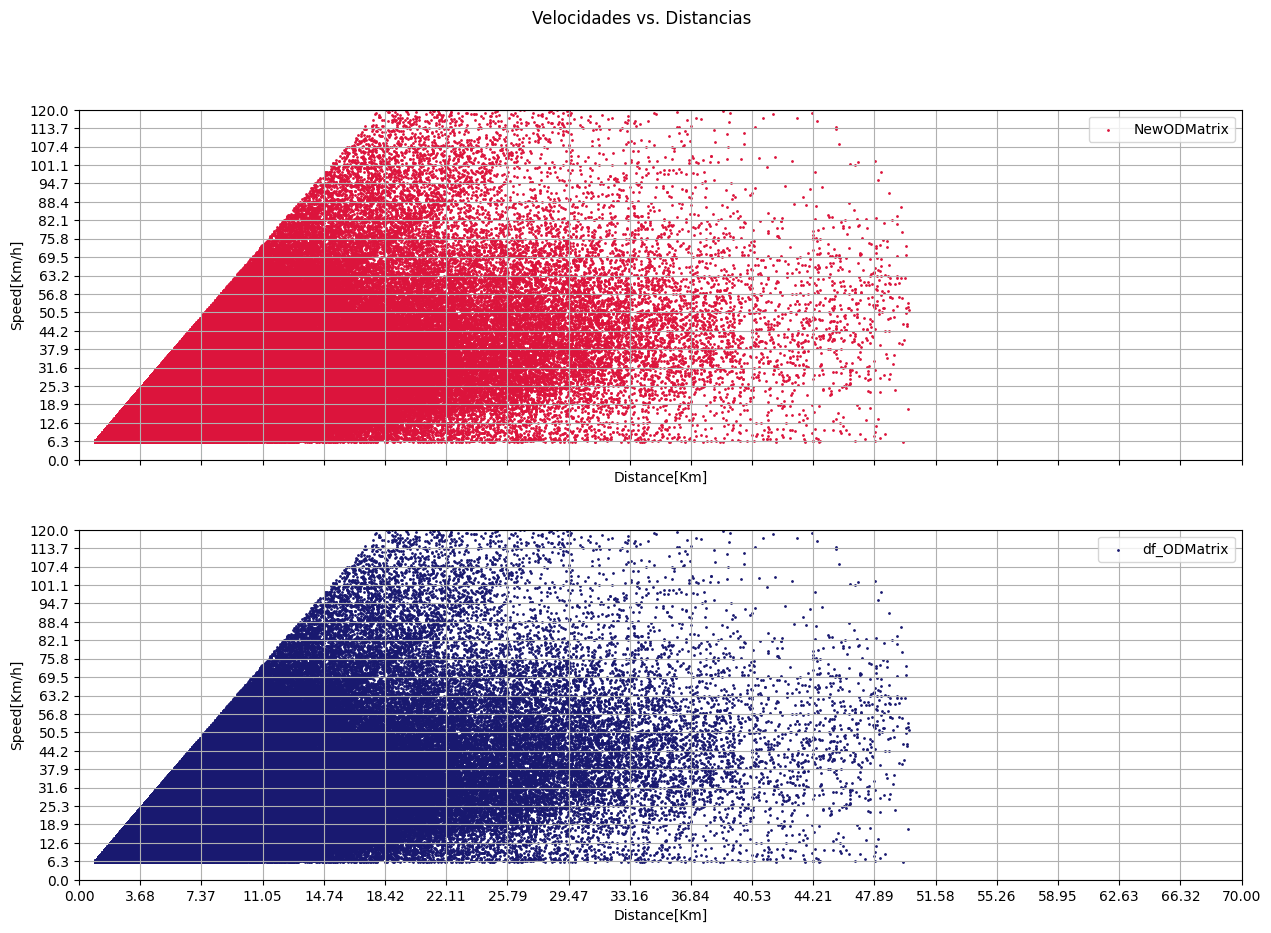

In [ ]:
NewODMatrix=NewODMatrix.drop(NewODMatrix[NewODMatrix['Speed[Km/h]']>=120].index)
NewODMatrix=NewODMatrix.drop(NewODMatrix[NewODMatrix['Speed[Km/h]']<6].index)
NewODMatrix=NewODMatrix.reset_index(drop=True)

fig, axs= plt.subplots(2,1,figsize=(15,10),sharex=True)
Xmin=0;Xmax=70;Ymin=0;Ymax=120
fig.suptitle('Velocidades vs. Distancias')
axs[0].scatter(NewODMatrix['Travel Distance[Km]'],NewODMatrix['Speed[Km/h]'],s=1,c='crimson',label='NewODMatrix')
axs[0].set_xlabel('Distance[Km]');axs[0].set_ylabel('Speed[Km/h]')
axs[0].set_xticks(np.linspace(Xmin,Xmax,20));axs[0].set_yticks(np.linspace(Ymin,Ymax,20))
axs[0].grid()
axs[0].set_xlim(Xmin,Xmax)
axs[0].set_ylim(Ymin,Ymax)
axs[0].legend()

axs[1].scatter(df_ODMatrix['Travel Distance[Km]'],df_ODMatrix['Speed[Km/h]'],s=1,c='midnightblue',label='df_ODMatrix')
axs[1].set_xlabel('Distance[Km]');axs[1].set_ylabel('Speed[Km/h]')
axs[1].set_xticks(np.linspace(Xmin,Xmax,20));axs[1].set_yticks(np.linspace(Ymin,Ymax,20))
axs[1].grid()
axs[1].set_xlim(Xmin,Xmax)
axs[1].set_ylim(Ymin,Ymax)
axs[1].legend()

plt.show()

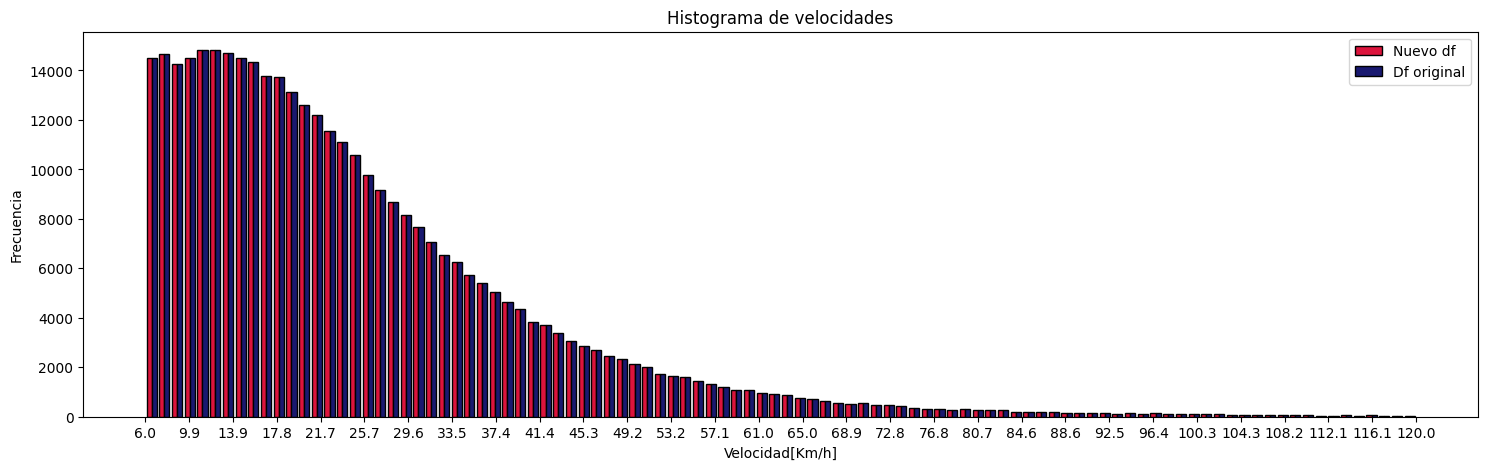

In [ ]:
Vmax=120;Vmin=6
fig, axs=plt.subplots(figsize=(18,5))
axs.hist([NewODMatrix['Speed[Km/h]'],df_ODMatrix['Speed[Km/h]']],color=['crimson','midnightblue'],bins=100,range=(Vmin,Vmax),edgecolor='black',label=['Nuevo df','Df original'])
axs.set_xlabel('Velocidad[Km/h]')
axs.set_ylabel('Frecuencia')
axs.set_title('Histograma de velocidades')
axs.set_xticks(np.linspace(Vmin,Vmax,30))
axs.legend()
plt.show()

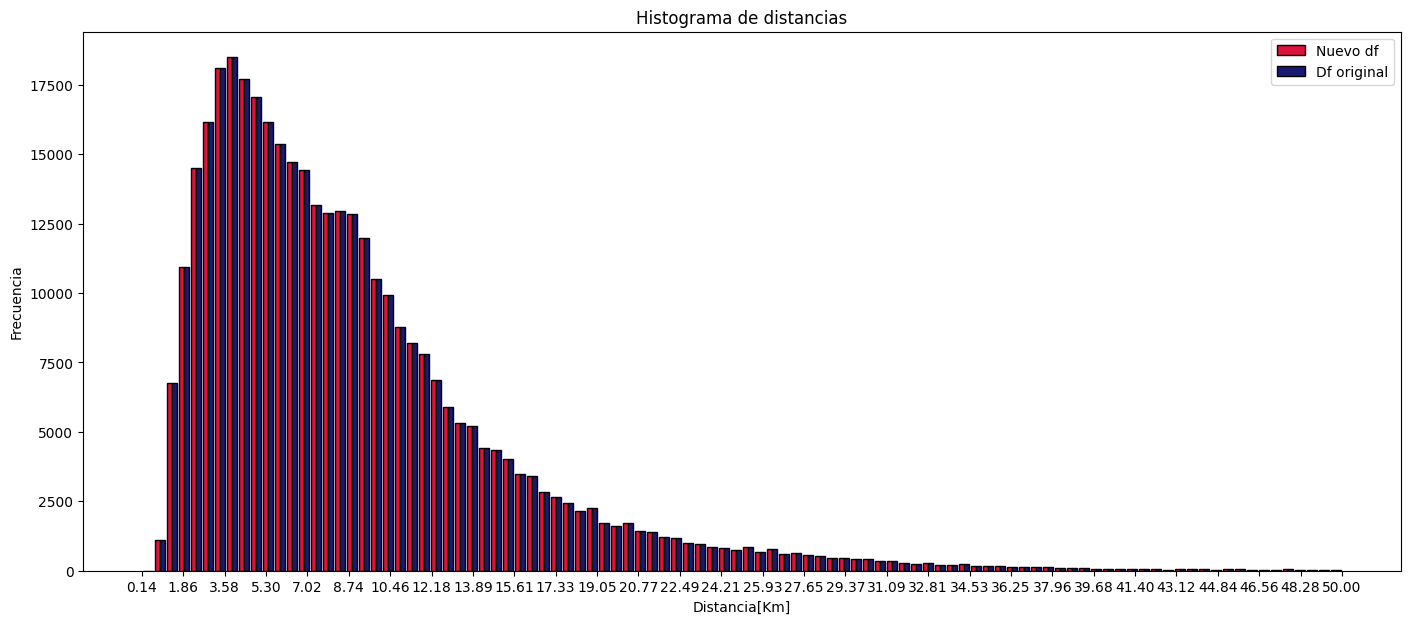

In [ ]:
plt.figure(figsize=(17,7))
plt.hist([NewODMatrix['Travel Distance[Km]'],df_ODMatrix['Travel Distance[Km]']],range=(0.14,50),bins=100, color=['crimson','midnightblue'],edgecolor='black',label=['Nuevo df','Df original'])
plt.xlabel('Distancia[Km]')
plt.ylabel('Frecuencia')
plt.title('Histograma de distancias')
plt.xticks(np.linspace(0.14,50,30))
plt.legend()
plt.show()

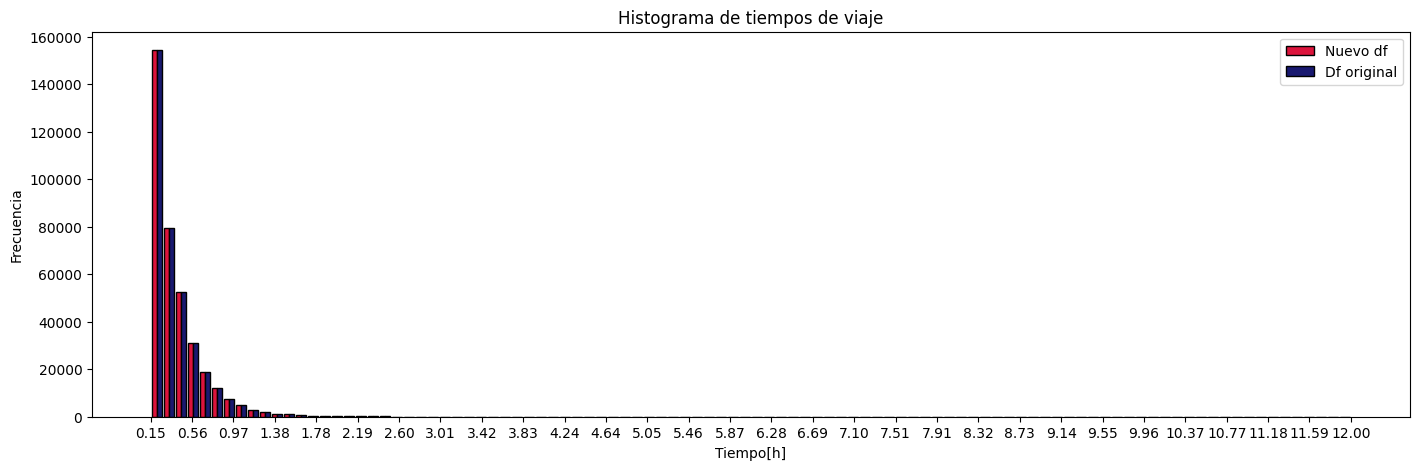

In [ ]:
plt.figure(figsize=(17,5))
plt.hist([NewODMatrix['Travel_Time[h]'],df_ODMatrix['Travel_Time[h]']],range=(0.15,12),bins=100, color=['crimson','midnightblue'],edgecolor='black',label=['Nuevo df','Df original'])
plt.xlabel('Tiempo[h]')
plt.ylabel('Frecuencia')
plt.title('Histograma de tiempos de viaje')
plt.xticks(np.linspace(0.15,12,30))
plt.legend()
plt.show()

In [ ]:
MoreFreqOr1=[NewODMatrix['index_origin'].value_counts().index,NewODMatrix['index_origin'].value_counts().values]
MoreFreqDes1=[NewODMatrix['index_destination'].value_counts().index,NewODMatrix['index_destination'].value_counts().values]

In [ ]:
MoreFreqOr1=[NewODMatrix['index_origin'].value_counts().index,NewODMatrix['index_origin'].value_counts().values]
MoreFreqDes1=[NewODMatrix['index_destination'].value_counts().index,NewODMatrix['index_destination'].value_counts().values]

###Frecuencia de uso de casillas

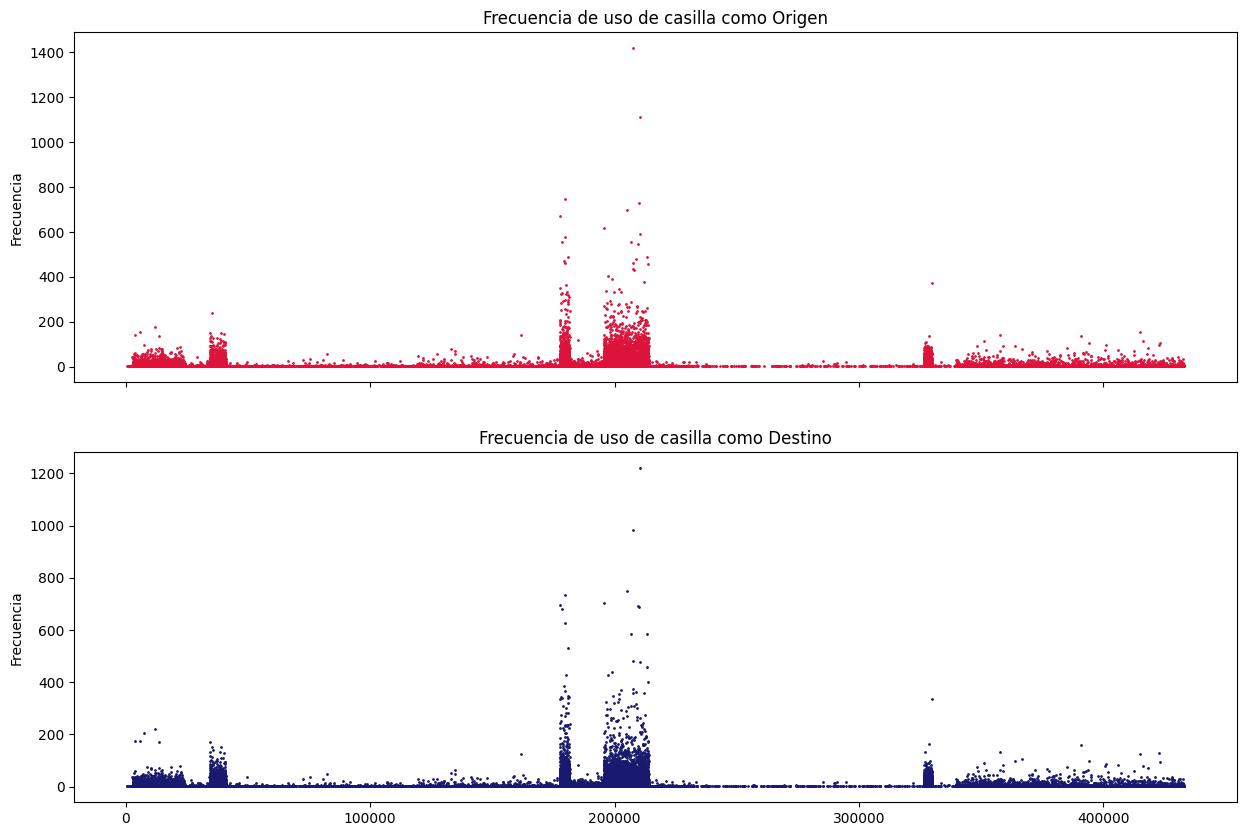

In [ ]:
fig, axs= plt.subplots(2,1,figsize=(15,10),sharex=True)

axs[0].scatter(MoreFreqOr1[0],MoreFreqOr1[1],c='crimson',s=1)
#axs[0].scatter(MoreFreqDes1[0],MoreFreqDes1[1],c='midnightblue',label='Destino',s=1)
axs[0].set_ylabel('Frecuencia')
axs[0].set_title('Frecuencia de uso de casilla como Origen')

#axs[1].scatter(MoreFreqOr2[0],MoreFreqOr2[1],c='crimson',s=1,label='Origen')
axs[1].scatter(MoreFreqDes1[0],MoreFreqDes1[1],c='midnightblue',s=1)
axs[1].set_ylabel('Frecuencia')
axs[1].set_title('Frecuencia de uso de casilla como Destino')

plt.show()

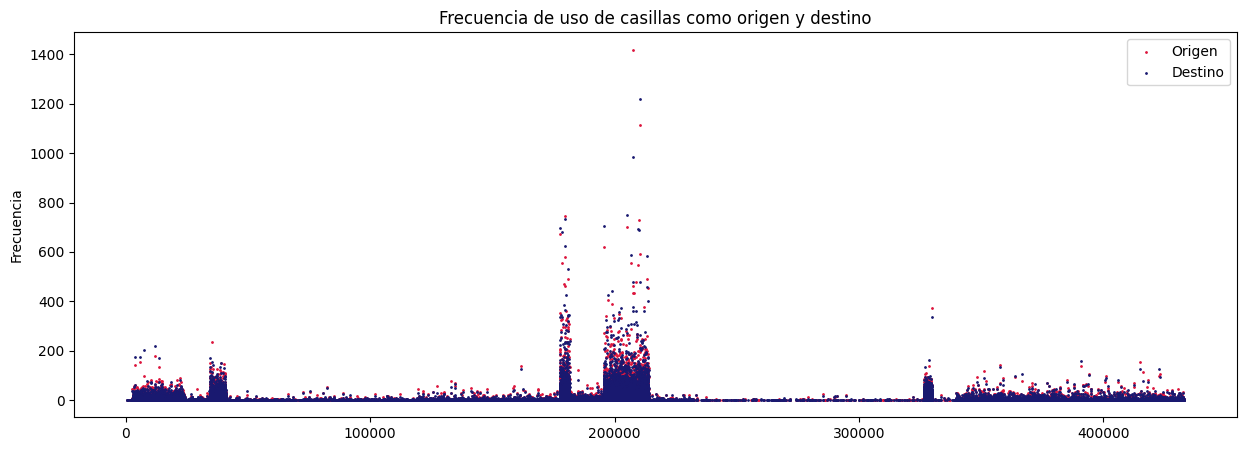

In [ ]:
plt.figure(figsize=(15,5))
plt.scatter(MoreFreqOr1[0],MoreFreqOr1[1],c='crimson',s=1,label='Origen')
plt.scatter(MoreFreqDes1[0],MoreFreqDes1[1],c='midnightblue',s=1,label='Destino')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de uso de casillas como origen y destino')
plt.legend()
plt.show()

## Organización por días

###Frecuencia de uso de casillas

In [ ]:
OrbyDay=[[]]*7
DesbyDay=[[]]*7

for day in NewODMatrix['DayWeek_O'].unique():
  OrbyDay[day]=[NewODMatrix[NewODMatrix['DayWeek_O']==day]['index_origin'].value_counts().index,NewODMatrix[NewODMatrix['DayWeek_O']==day]['index_origin'].value_counts().values]
  DesbyDay[day]=[NewODMatrix[NewODMatrix['DayWeek_D']==day]['index_destination'].value_counts().index,NewODMatrix[NewODMatrix['DayWeek_D']==day]['index_destination'].value_counts().values]


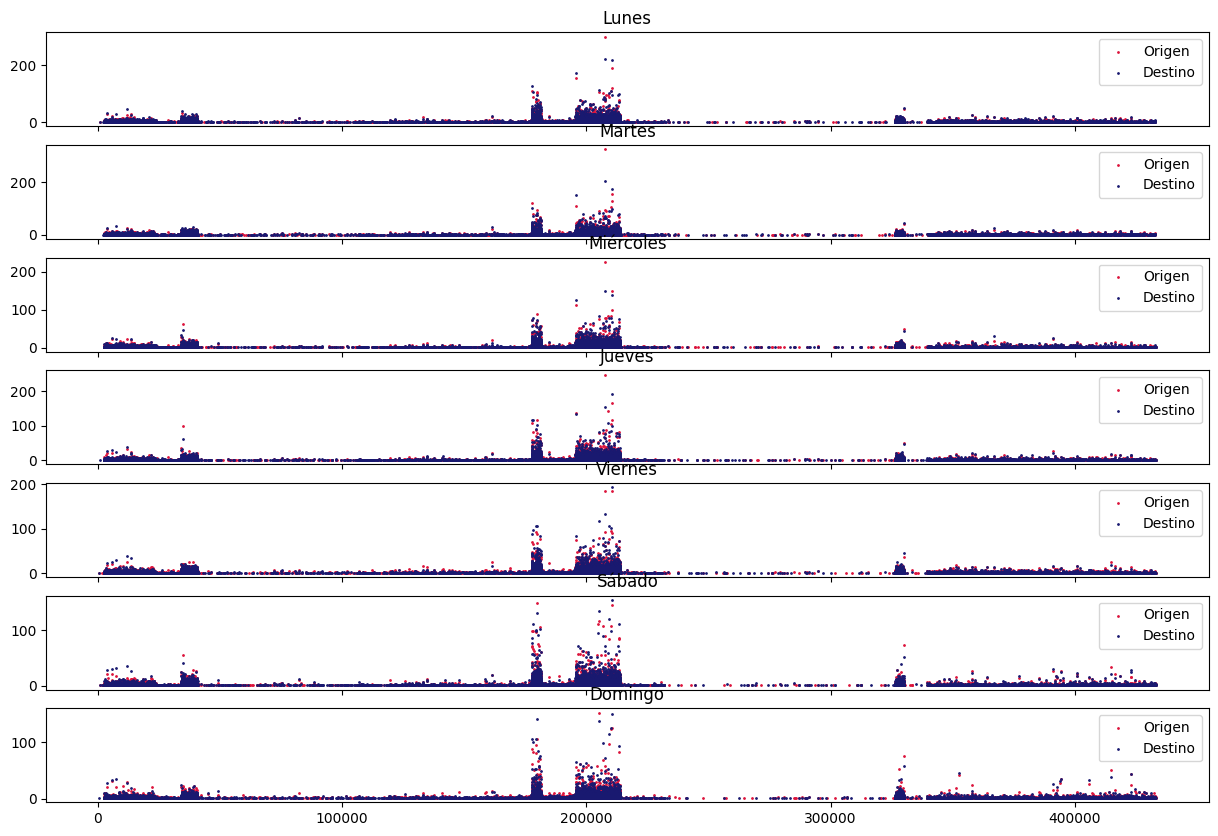

In [ ]:
fig, axs= plt.subplots(7,1,sharex=True,figsize=(15,10))
days=['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
for i in range(7):
  axs[i].set_title(days[i])
  axs[i].scatter(OrbyDay[i][0],OrbyDay[i][1],c='crimson',s=1,label='Origen')
  axs[i].scatter(DesbyDay[i][0],DesbyDay[i][1],c='midnightblue',label='Destino',s=1)
  axs[i].legend()

plt.show()

###Histogramas de distribución de datos

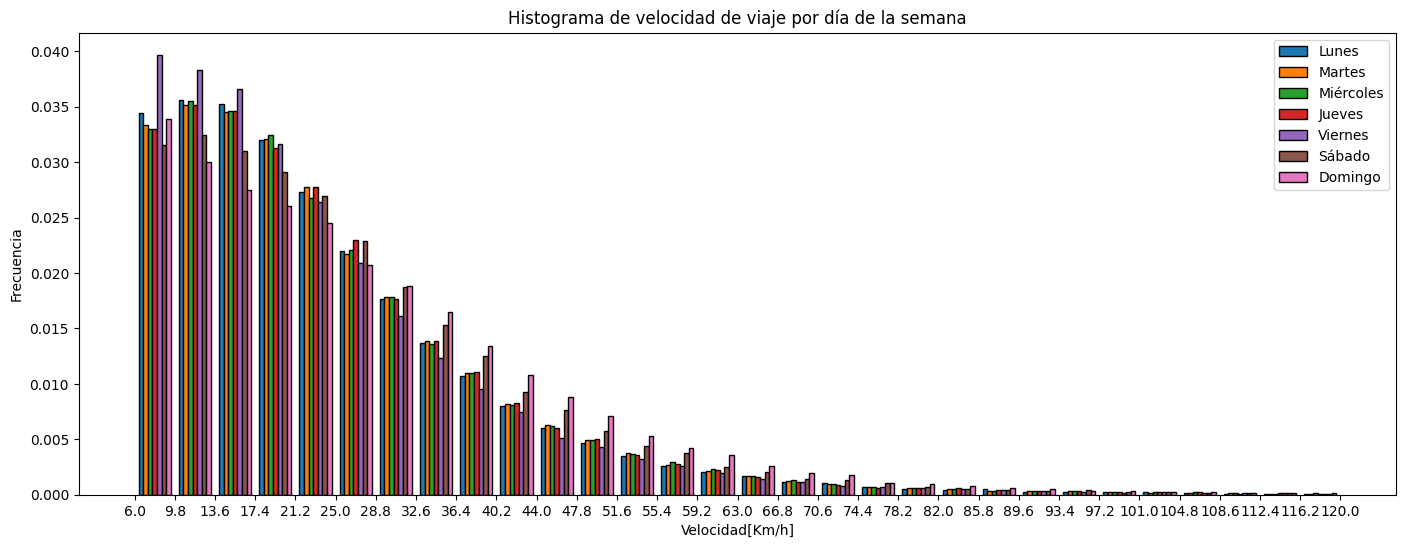

In [ ]:
SpeedbyDay1=[NewODMatrix[NewODMatrix['DayWeek_O']==0]['Speed[Km/h]'],NewODMatrix[NewODMatrix['DayWeek_O']==1]['Speed[Km/h]'],
            NewODMatrix[NewODMatrix['DayWeek_O']==2]['Speed[Km/h]'],NewODMatrix[NewODMatrix['DayWeek_O']==3]['Speed[Km/h]'],
            NewODMatrix[NewODMatrix['DayWeek_O']==4]['Speed[Km/h]'],NewODMatrix[NewODMatrix['DayWeek_O']==5]['Speed[Km/h]'],
             NewODMatrix[NewODMatrix['DayWeek_O']==6]['Speed[Km/h]']]

#SpeedbyDay2=[df_ODMatrix[df_ODMatrix['DayWeek_O']==0]['Speed[Km/h]'],df_ODMatrix[df_ODMatrix['DayWeek_O']==1]['Speed[Km/h]'],
#            df_ODMatrix[df_ODMatrix['DayWeek_O']==2]['Speed[Km/h]'],df_ODMatrix[df_ODMatrix['DayWeek_O']==3]['Speed[Km/h]'],
#            df_ODMatrix[df_ODMatrix['DayWeek_O']==4]['Speed[Km/h]'],df_ODMatrix[df_ODMatrix['DayWeek_O']==5]['Speed[Km/h]'],
#            df_ODMatrix[df_ODMatrix['DayWeek_O']==6]['Speed[Km/h]']]

fig, axs= plt.subplots(figsize=(17,6))

axs.hist(SpeedbyDay1,bins=30,range=(Vmin,Vmax),label=days,edgecolor='black',density=True)
axs.set_xlabel('Velocidad[Km/h]')
axs.set_ylabel('Frecuencia')
axs.set_title('Histograma de velocidad de viaje por día de la semana')
plt.xticks(np.linspace(Vmin,Vmax,31))
axs.legend()
plt.show()

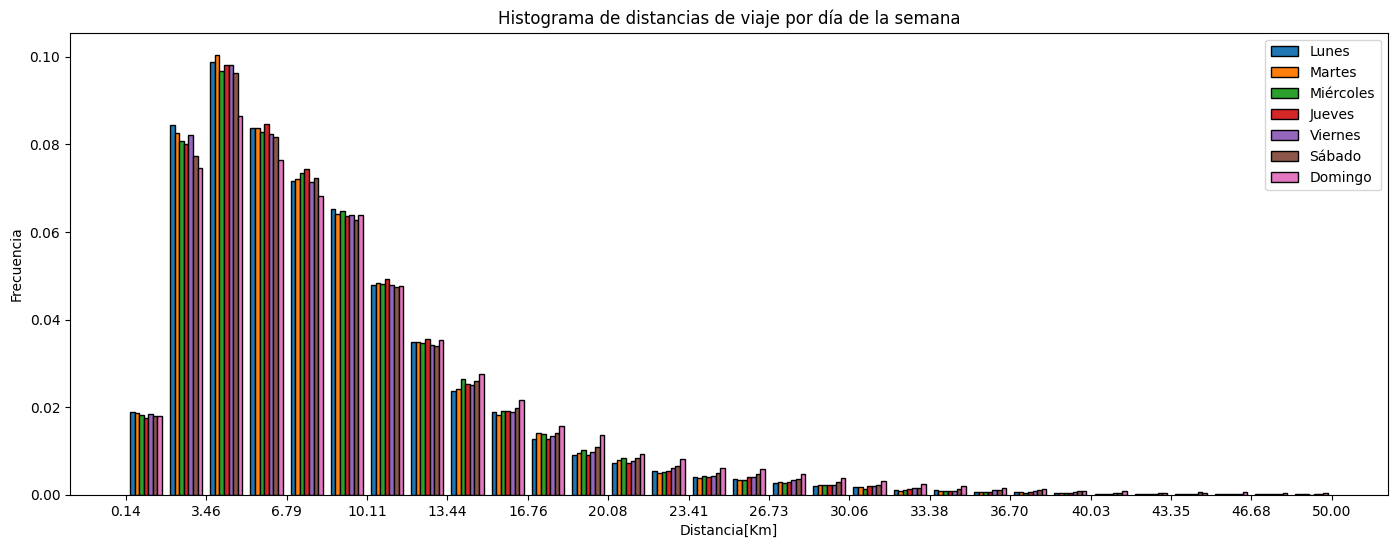

In [ ]:
DistancebyDay1=[NewODMatrix[NewODMatrix['DayWeek_O']==0]['Travel Distance[Km]'],NewODMatrix[NewODMatrix['DayWeek_O']==1]['Travel Distance[Km]'],
            NewODMatrix[NewODMatrix['DayWeek_O']==2]['Travel Distance[Km]'],NewODMatrix[NewODMatrix['DayWeek_O']==3]['Travel Distance[Km]'],
            NewODMatrix[NewODMatrix['DayWeek_O']==4]['Travel Distance[Km]'],NewODMatrix[NewODMatrix['DayWeek_O']==5]['Travel Distance[Km]'],
            NewODMatrix[NewODMatrix['DayWeek_O']==6]['Travel Distance[Km]']]

#DistancebyDay2=[df_ODMatrix[df_ODMatrix['DayWeek_O']==0]['Travel Distance[Km]'],df_ODMatrix[df_ODMatrix['DayWeek_O']==1]['Travel Distance[Km]'],
#            df_ODMatrix[df_ODMatrix['DayWeek_O']==2]['Travel Distance[Km]'],df_ODMatrix[df_ODMatrix['DayWeek_O']==3]['Travel Distance[Km]'],
#            df_ODMatrix[df_ODMatrix['DayWeek_O']==4]['Travel Distance[Km]'],df_ODMatrix[df_ODMatrix['DayWeek_O']==5]['Travel Distance[Km]'],
#            df_ODMatrix[df_ODMatrix['DayWeek_O']==6]['Travel Distance[Km]']]

fig, axs= plt.subplots(figsize=(17,6))

#fig.suptitle('Histograma de distancias por dia')

axs.hist(DistancebyDay1,bins=30,range=(0.14,50),label=days,edgecolor='black',density=True)
axs.set_xlabel('Distancia[Km]')
axs.set_ylabel('Frecuencia')
axs.set_title('Histograma de distancias de viaje por día de la semana')
plt.xticks(np.linspace(0.14,50,16))
axs.legend()

# axs[1].hist(DistancebyDay2,bins=30,range=(0,70),label=days,edgecolor='black',density=True)
# axs[1].set_xlabel('Distancia[Km]')
# axs[1].set_ylabel('Frecuencia')
# axs[1].set_title('df_ODMatrix')
# #plt.xticks(np.linspace(0,30,30))
# axs[1].legend()

plt.show()

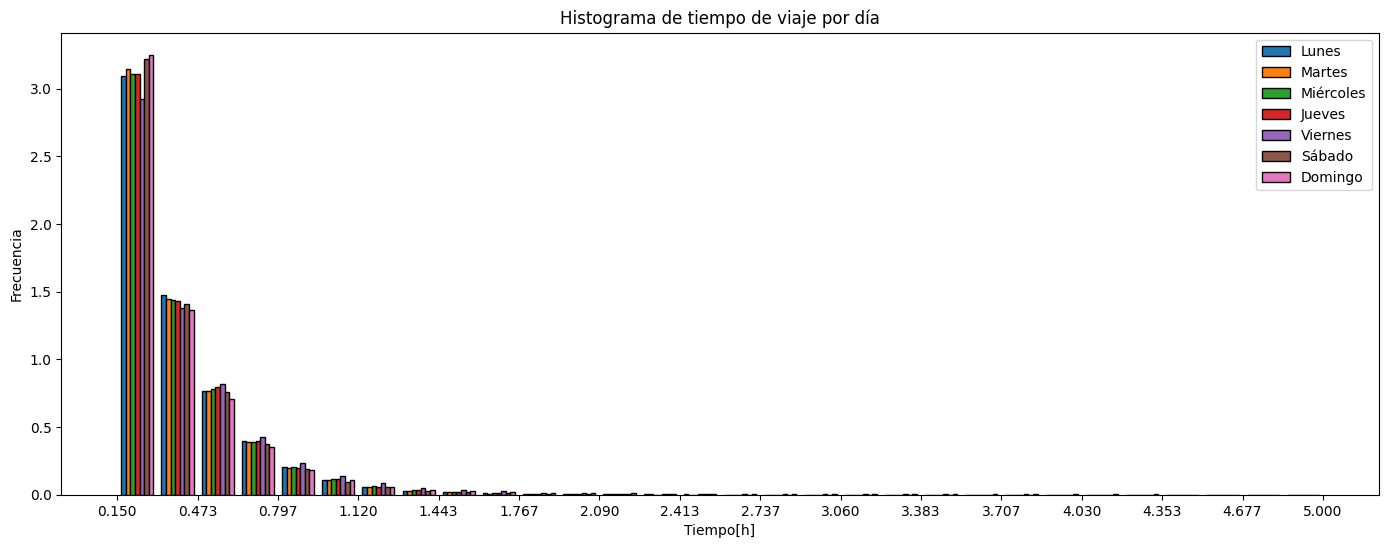

In [ ]:
TimebyDay1=[NewODMatrix[NewODMatrix['DayWeek_O']==0]['Travel_Time[h]'],NewODMatrix[NewODMatrix['DayWeek_O']==1]['Travel_Time[h]'],
            NewODMatrix[NewODMatrix['DayWeek_O']==2]['Travel_Time[h]'],NewODMatrix[NewODMatrix['DayWeek_O']==3]['Travel_Time[h]'],
            NewODMatrix[NewODMatrix['DayWeek_O']==4]['Travel_Time[h]'],NewODMatrix[NewODMatrix['DayWeek_O']==5]['Travel_Time[h]'],
            NewODMatrix[NewODMatrix['DayWeek_O']==6]['Travel_Time[h]']]


#TimebyDay2=[df_ODMatrix[df_ODMatrix['DayWeek_O']==0]['Travel_Time[h]'],df_ODMatrix[df_ODMatrix['DayWeek_O']==1]['Travel_Time[h]'],
#            df_ODMatrix[df_ODMatrix['DayWeek_O']==2]['Travel_Time[h]'],df_ODMatrix[df_ODMatrix['DayWeek_O']==3]['Travel_Time[h]'],
#            df_ODMatrix[df_ODMatrix['DayWeek_O']==4]['Travel_Time[h]'],df_ODMatrix[df_ODMatrix['DayWeek_O']==5]['Travel_Time[h]'],
#            df_ODMatrix[df_ODMatrix['DayWeek_O']==6]['Travel_Time[h]']]

fig, axs= plt.subplots(figsize=(17,6))

#fig.suptitle('Histograma de tiempo de viaje por dia')

axs.hist(TimebyDay1,bins=30,range=(0.15,5),label=days,edgecolor='black',density=True)
axs.set_xlabel('Tiempo[h]')
axs.set_ylabel('Frecuencia')
axs.set_title('Histograma de tiempo de viaje por día')
plt.xticks(np.linspace(0.15,5,16))
axs.legend()

#axs[1].hist(TimebyDay2,bins=30,range=(0.15,12),label=days,edgecolor='black',density=True)
#axs[1].set_xlabel('Tiempo[h]')
#axs[1].set_ylabel('Frecuencia')
#axs[1].set_title('df_ODMatrix')
##plt.xticks(np.linspace(0,30,30))
#axs[1].legend()
plt.show()

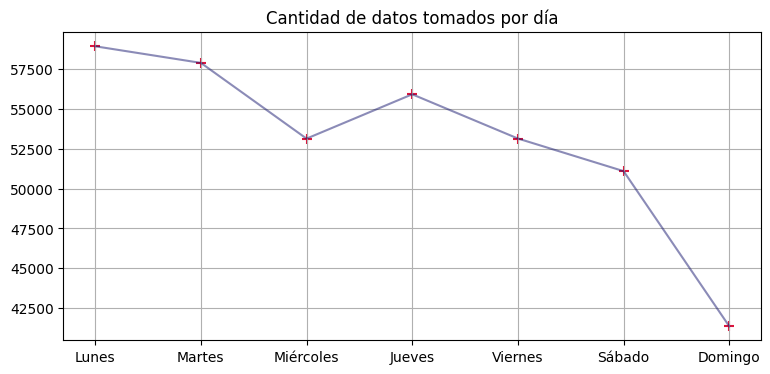

In [ ]:
DaySize = [len(day) for day in TimebyDay1]
plt.figure(figsize=(9,4))
plt.plot(range(7),DaySize,alpha=0.5,color='midnightblue')
plt.scatter(range(7),DaySize,color='crimson',marker='+',s=50)
plt.xticks(range(7),days)
plt.title('Cantidad de datos tomados por día')
plt.grid()
plt.show()

## Análisis por horarios:
8am-6pm (Horario laboral), 6pm-2am(Horario nocturno), 2am-5am(Madrugada) y 5am-8am(Horario matutino)

###Frecuencia de uso de casillas

In [ ]:
OrbySch1=[[]]*4
DesbySch1=[[]]*4
SpeedbySch1=[[]]*4
DistancebySch1=[[]]*4
TimebySch1=[[]]*4

OrbySch2=[[]]*4
DesbySch2=[[]]*4
SpeedbySch2=[[]]*4
DistancebySch2=[[]]*4
TimebySch2=[[]]*4

Schedules=['8am-6pm','6pm-2am','2am-5am','5am-8am']

SchedulesO1=[(NewODMatrix['datehour']>8) & (NewODMatrix['datehour']<18), ((NewODMatrix['datehour']>18) & (NewODMatrix['datehour']<24))|((NewODMatrix['datehour']>0) & (NewODMatrix['datehour']<2)),
            (NewODMatrix['datehour']>2) & (NewODMatrix['datehour']<5),(NewODMatrix['datehour']>5) & (NewODMatrix['datehour']<8)]

SchedulesD1=[(NewODMatrix['Hour_D']>8) & (NewODMatrix['Hour_D']<18), ((NewODMatrix['Hour_D']>18) & (NewODMatrix['Hour_D']<24))|((NewODMatrix['Hour_D']>0) & (NewODMatrix['Hour_D']<2)),
            (NewODMatrix['Hour_D']>2) & (NewODMatrix['Hour_D']<5),(NewODMatrix['Hour_D']>5) & (NewODMatrix['Hour_D']<8)]

SchedulesO2=[(df_ODMatrix['datehour']>8) & (df_ODMatrix['datehour']<18), ((df_ODMatrix['datehour']>18) & (df_ODMatrix['datehour']<24))|((df_ODMatrix['datehour']>0) & (df_ODMatrix['datehour']<2)),
            (df_ODMatrix['datehour']>2) & (df_ODMatrix['datehour']<5),(df_ODMatrix['datehour']>5) & (df_ODMatrix['datehour']<8)]

SchedulesD2=[(df_ODMatrix['Hour_D']>8) & (df_ODMatrix['Hour_D']<18), ((df_ODMatrix['Hour_D']>18) & (df_ODMatrix['Hour_D']<24))|((df_ODMatrix['Hour_D']>0) & (df_ODMatrix['Hour_D']<2)),
            (df_ODMatrix['Hour_D']>2) & (df_ODMatrix['Hour_D']<5),(df_ODMatrix['Hour_D']>5) & (df_ODMatrix['Hour_D']<8)]

for i in range(4):
  OrbySch1[i]=[NewODMatrix[SchedulesO1[i]]['index_origin'].value_counts().index,NewODMatrix[SchedulesO1[i]]['index_origin'].value_counts().values]
  DesbySch1[i]=[NewODMatrix[SchedulesD1[i]]['index_destination'].value_counts().index,NewODMatrix[SchedulesD1[i]]['index_destination'].value_counts().values]

  SpeedbySch1[i]=NewODMatrix[SchedulesO1[i]]['Speed[Km/h]']
  DistancebySch1[i]=NewODMatrix[SchedulesO1[i]]['Travel Distance[Km]']
  TimebySch1[i]=NewODMatrix[SchedulesO1[i]]['Travel_Time[h]']

  OrbySch2[i]=[df_ODMatrix[SchedulesO2[i]]['index_origin'].value_counts().index,df_ODMatrix[SchedulesO2[i]]['index_origin'].value_counts().values]
  DesbySch2[i]=[df_ODMatrix[SchedulesD2[i]]['index_destination'].value_counts().index,df_ODMatrix[SchedulesD2[i]]['index_destination'].value_counts().values]

  SpeedbySch2[i]=df_ODMatrix[SchedulesO2[i]]['Speed[Km/h]']
  DistancebySch2[i]=df_ODMatrix[SchedulesO2[i]]['Travel Distance[Km]']
  TimebySch2[i]=df_ODMatrix[SchedulesO2[i]]['Travel_Time[h]']


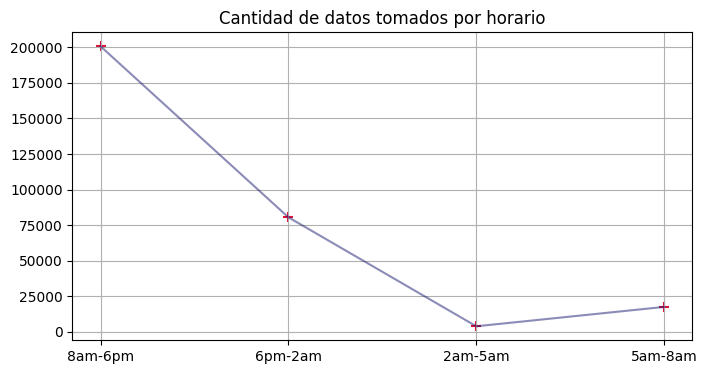

In [ ]:
HourSize=[len(hour) for hour in SpeedbySch1]
plt.figure(figsize=(8,4))
plt.plot(range(4),HourSize,alpha=0.5,color='midnightblue')
plt.scatter(range(4),HourSize,color='crimson',marker='+',s=50)
plt.xticks(range(4),Schedules)
plt.title('Cantidad de datos tomados por horario')
plt.grid()
plt.show()

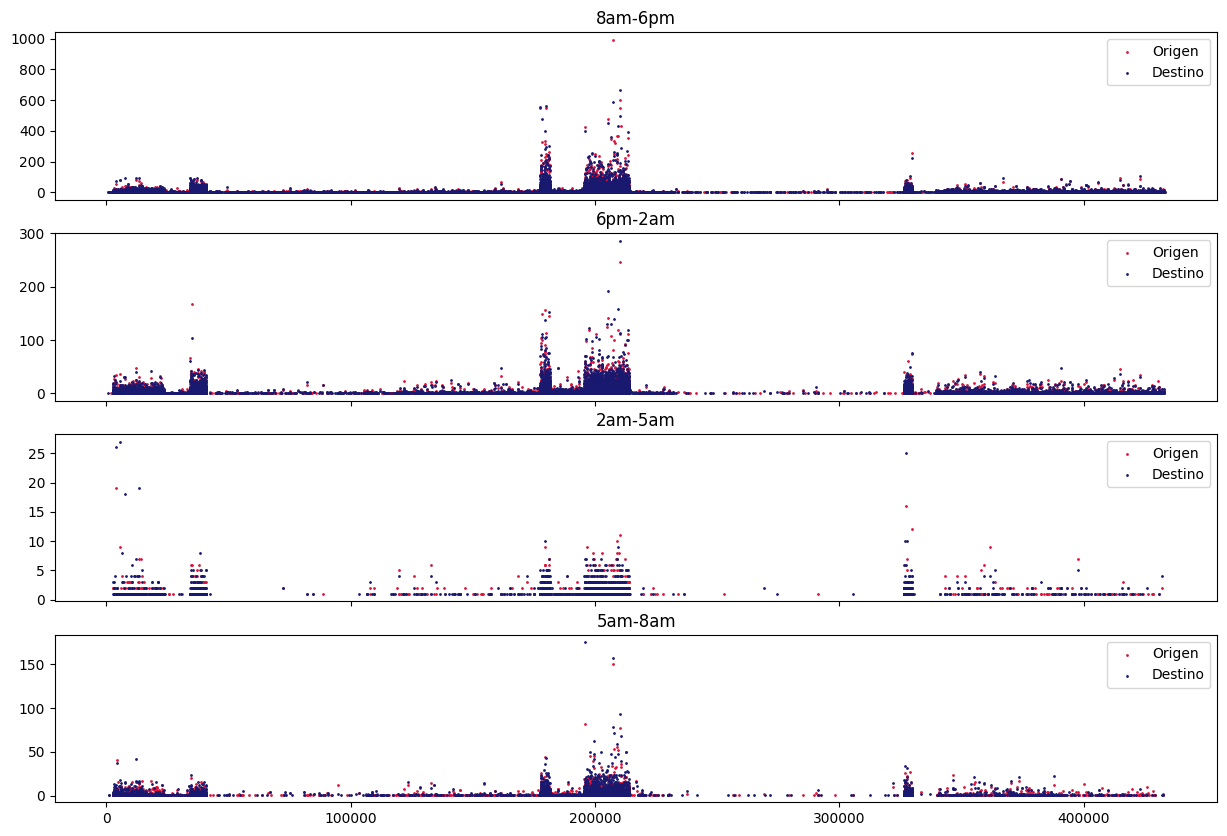

In [ ]:
fig, axs= plt.subplots(4,1,sharex=True,figsize=(15,10))
for i in range(4):
  axs[i].set_title(Schedules[i])
  axs[i].scatter(OrbySch1[i][0],OrbySch1[i][1],c='crimson',s=1,label='Origen')
  axs[i].scatter(DesbySch1[i][0],DesbySch1[i][1],c='midnightblue',label='Destino',s=1)
  axs[i].legend()

plt.show()

###Histogramas de dsitribución de datos

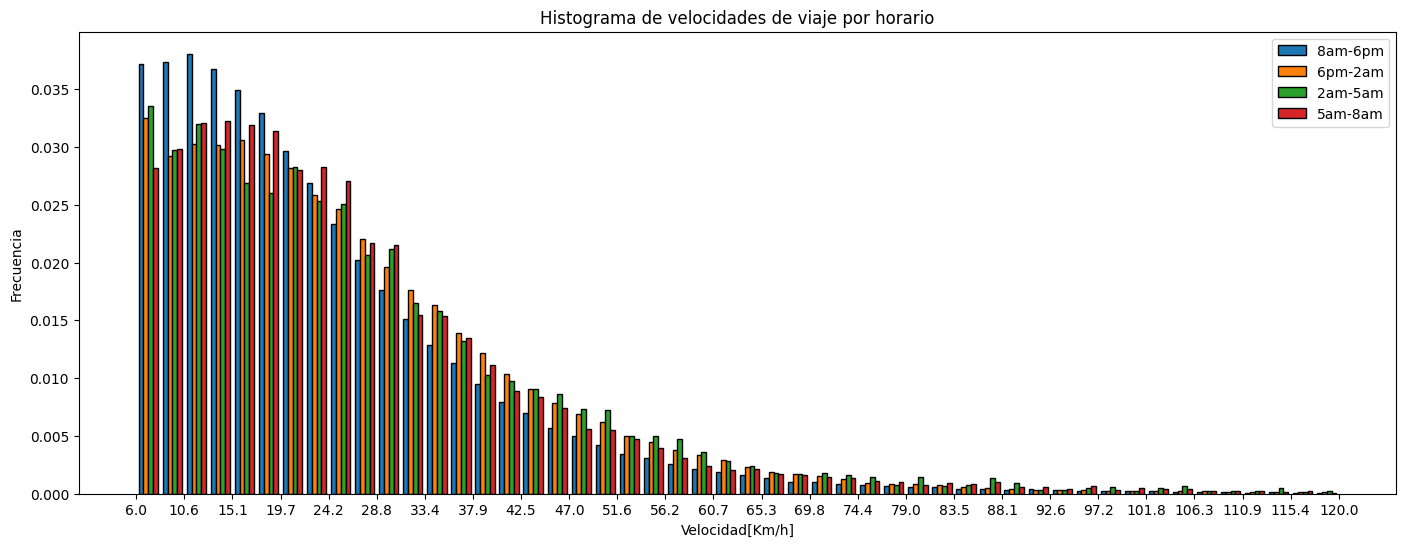

In [ ]:
fig, axs= plt.subplots(figsize=(17,6))

#fig.suptitle('Histograma de velocidades por horario')

axs.hist(SpeedbySch1,bins=50,range=(Vmin,Vmax),label=Schedules,edgecolor='black',density=True)
axs.set_xlabel('Velocidad[Km/h]')
axs.set_ylabel('Frecuencia')
axs.set_title('Histograma de velocidades de viaje por horario')
plt.xticks(np.linspace(Vmin,Vmax,26))
axs.legend()

#axs[1].hist(SpeedbySch2,bins=50,range=(0,120),label=Schedules,edgecolor='black',density=True)
#axs[1].set_xlabel('Velocidad[Km/h]')
#axs[1].set_ylabel('Frecuencia')
#axs[1].set_title('df_ODMatrix')
##plt.xticks(np.linspace(0,30,30))
#axs[1].legend()
plt.show()

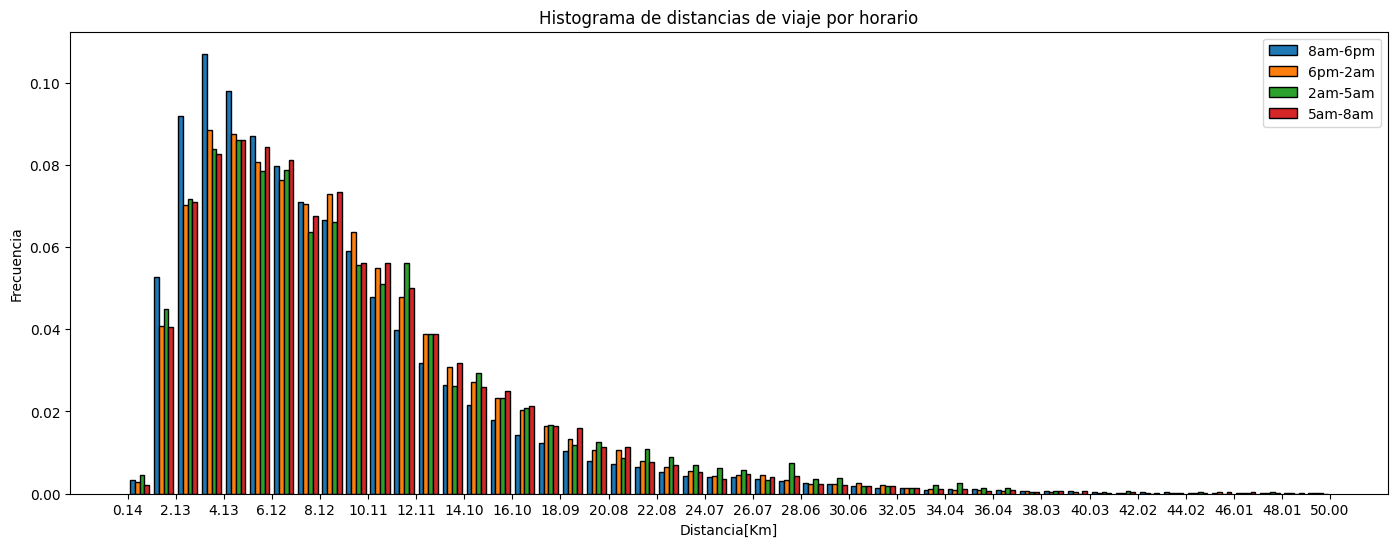

In [ ]:
fig, axs= plt.subplots(figsize=(17,6))

#fig.suptitle('Histograma de distancias por horario')

axs.hist(DistancebySch1,bins=50,range=(0.14,50),label=Schedules,edgecolor='black',density=True)
axs.set_xlabel('Distancia[Km]')
axs.set_ylabel('Frecuencia')
axs.set_title('Histograma de distancias de viaje por horario')
plt.xticks(np.linspace(0.14,50,26))
axs.legend()

#axs[1].hist(DistancebySch2,bins=50,range=(0,70),label=Schedules,edgecolor='black',density=True)
#axs[1].set_xlabel('Distancia[Km]')
#axs[1].set_ylabel('Frecuencia')
#axs[1].set_title('df_ODMatrix')
##plt.xticks(np.linspace(0,30,30))
#axs[1].legend()
plt.show()

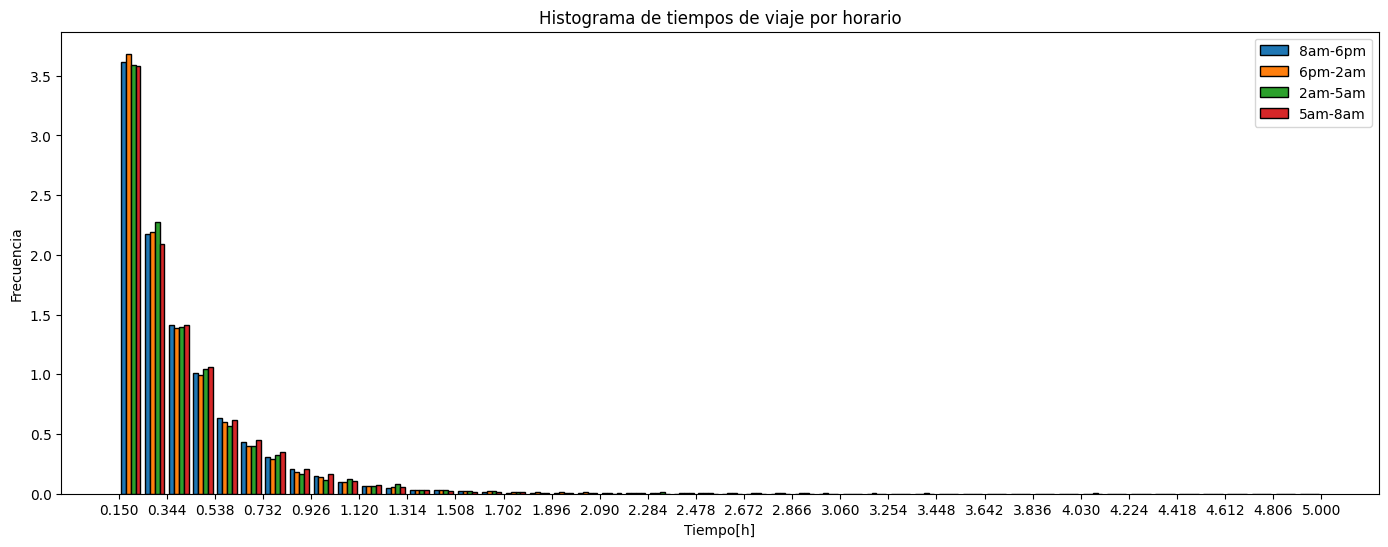

In [ ]:
fig, axs= plt.subplots(figsize=(17,6))

#fig.suptitle('Histograma de tiempo de viaje por horario')

axs.hist(TimebySch1,bins=50,range=(0.15,5),label=Schedules,edgecolor='black',density=True)
axs.set_xlabel('Tiempo[h]')
axs.set_ylabel('Frecuencia')
axs.set_title('Histograma de tiempos de viaje por horario')
plt.xticks(np.linspace(0.15,5,26))
axs.legend()

#axs[1].hist(TimebySch2,bins=50,range=(0.3,12),label=Schedules,edgecolor='black',density=True)
#axs[1].set_xlabel('Tiempo[h]')
#axs[1].set_ylabel('Frecuencia')
#axs[1].set_title('df_ODMatrix')
##plt.xticks(np.linspace(0,30,30))
#axs[1].legend()
plt.show()

##Análisis de valores promedio

###Velocidad

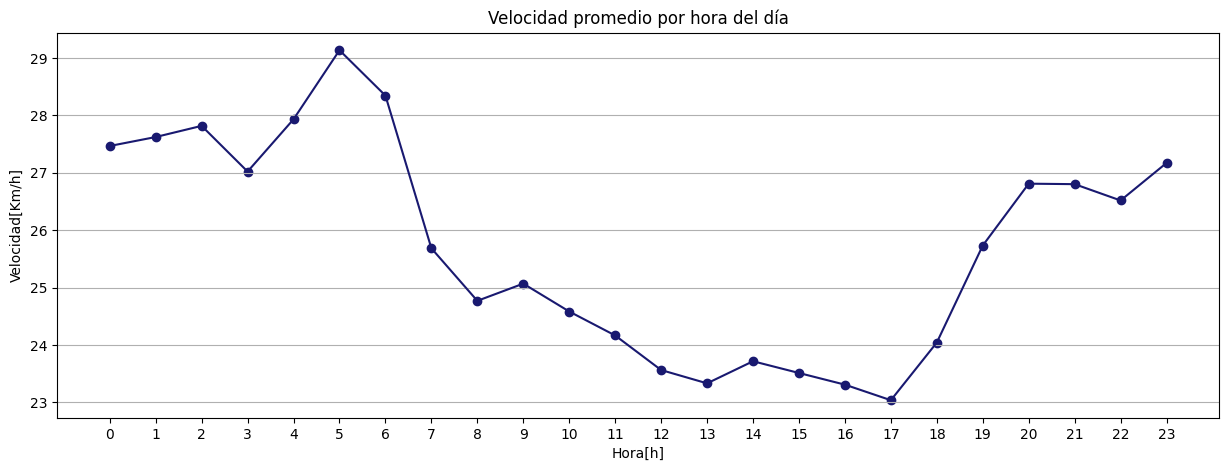

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(NewODMatrix.groupby('datehour')['Speed[Km/h]'].mean().index,NewODMatrix.groupby('datehour')['Speed[Km/h]'].mean().values,color='midnightblue')
#plt.plot(df_ODMatrix.groupby('datehour')['Speed[Km/h]'].mean().index,df_ODMatrix.groupby('datehour')['Speed[Km/h]'].mean().values,label='df_ODMatrix',color='midnightblue')
plt.scatter(NewODMatrix.groupby('datehour')['Speed[Km/h]'].mean().index,NewODMatrix.groupby('datehour')['Speed[Km/h]'].mean().values,color='midnightblue')
#plt.scatter(df_ODMatrix.groupby('datehour')['Speed[Km/h]'].mean().index,df_ODMatrix.groupby('datehour')['Speed[Km/h]'].mean().values,color='midnightblue')


plt.xlabel('Hora[h]')
plt.xticks(np.arange(0,24))
plt.ylabel('Velocidad[Km/h]')
plt.title('Velocidad promedio por hora del día')
plt.grid(axis='y')
plt.show()

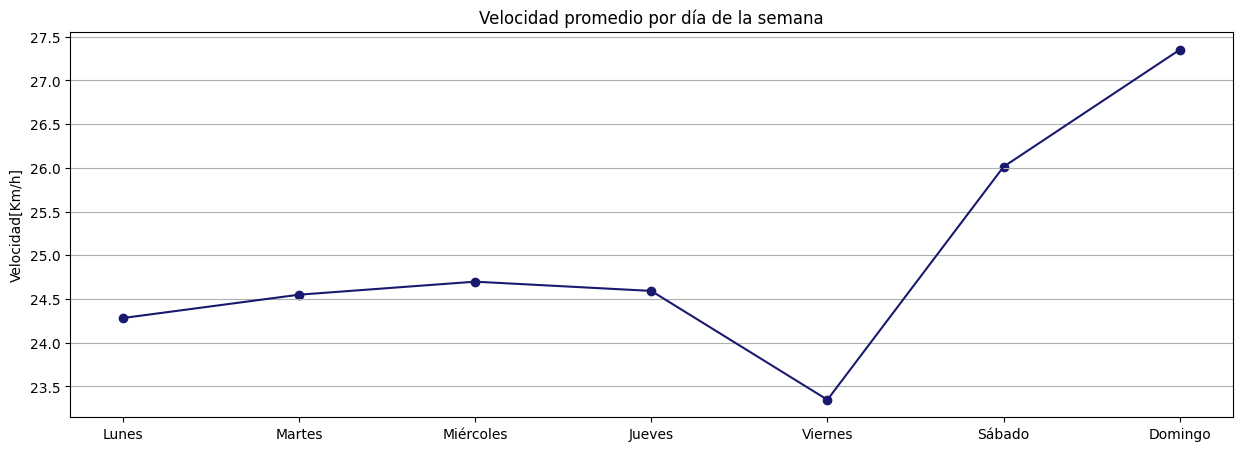

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(NewODMatrix.groupby('DayWeek_O')['Speed[Km/h]'].mean().index,NewODMatrix.groupby('DayWeek_O')['Speed[Km/h]'].mean().values,color='midnightblue')
#plt.plot(df_ODMatrix.groupby('DayWeek_O')['Speed[Km/h]'].mean().index,df_ODMatrix.groupby('DayWeek_O')['Speed[Km/h]'].mean().values,label='df_ODMatrix',color='midnightblue')
plt.scatter(NewODMatrix.groupby('DayWeek_O')['Speed[Km/h]'].mean().index,NewODMatrix.groupby('DayWeek_O')['Speed[Km/h]'].mean().values,color='midnightblue')
#plt.scatter(df_ODMatrix.groupby('DayWeek_O')['Speed[Km/h]'].mean().index,df_ODMatrix.groupby('DayWeek_O')['Speed[Km/h]'].mean().values,color='midnightblue')


plt.xticks(NewODMatrix.groupby('DayWeek_O')['Speed[Km/h]'].mean().index,days)
plt.ylabel('Velocidad[Km/h]')
plt.title('Velocidad promedio por día de la semana')
plt.grid(axis='y')
plt.show()

###Tiempo

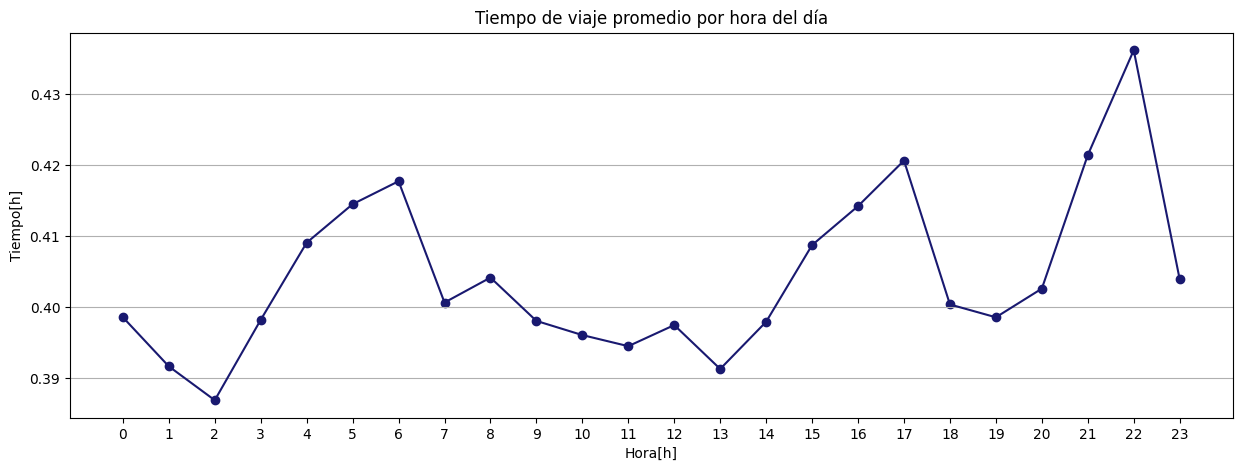

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(NewODMatrix.groupby('datehour')['Travel_Time[h]'].mean().index,NewODMatrix.groupby('datehour')['Travel_Time[h]'].mean().values,color='midnightblue')
#plt.plot(df_ODMatrix.groupby('datehour')['Travel_Time[h]'].mean().index,df_ODMatrix.groupby('datehour')['Travel_Time[h]'].mean().values,label='df_ODMatrix',color='midnightblue')
plt.scatter(NewODMatrix.groupby('datehour')['Travel_Time[h]'].mean().index,NewODMatrix.groupby('datehour')['Travel_Time[h]'].mean().values,color='midnightblue')
#plt.scatter(df_ODMatrix.groupby('datehour')['Travel_Time[h]'].mean().index,df_ODMatrix.groupby('datehour')['Travel_Time[h]'].mean().values,color='midnightblue')


plt.xlabel('Hora[h]')
plt.xticks(np.arange(0,24))
plt.ylabel('Tiempo[h]')
plt.title('Tiempo de viaje promedio por hora del día')
plt.grid(axis='y')
plt.show()

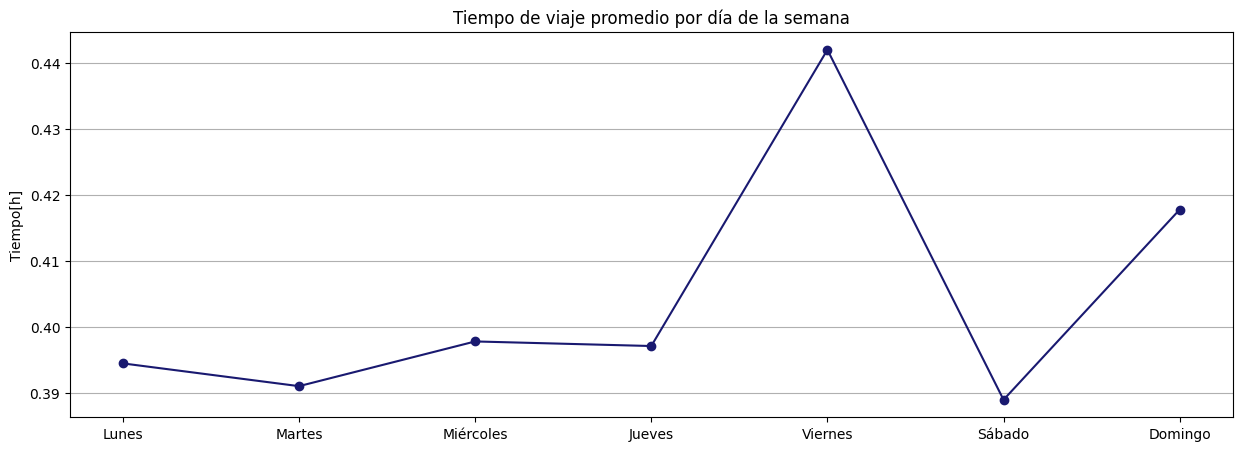

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(NewODMatrix.groupby('DayWeek_O')['Travel_Time[h]'].mean().index,NewODMatrix.groupby('DayWeek_O')['Travel_Time[h]'].mean().values,color='midnightblue')
#plt.plot(df_ODMatrix.groupby('DayWeek_O')['Travel_Time[h]'].mean().index,df_ODMatrix.groupby('DayWeek_O')['Travel_Time[h]'].mean().values,label='df_ODMatrix',color='midnightblue')
plt.scatter(NewODMatrix.groupby('DayWeek_O')['Travel_Time[h]'].mean().index,NewODMatrix.groupby('DayWeek_O')['Travel_Time[h]'].mean().values,color='midnightblue')
#plt.scatter(df_ODMatrix.groupby('DayWeek_O')['Travel_Time[h]'].mean().index,df_ODMatrix.groupby('DayWeek_O')['Travel_Time[h]'].mean().values,color='midnightblue')


plt.xticks(NewODMatrix.groupby('DayWeek_O')['Travel_Time[h]'].mean().index,days)
plt.ylabel('Tiempo[h]')
plt.title('Tiempo de viaje promedio por día de la semana')
plt.grid(axis='y')
plt.show()

In [ ]:
NewODMatrix.groupby('datehour')['Travel_Time[h]'].mean().std()

0.011541851126151722

###Distancia

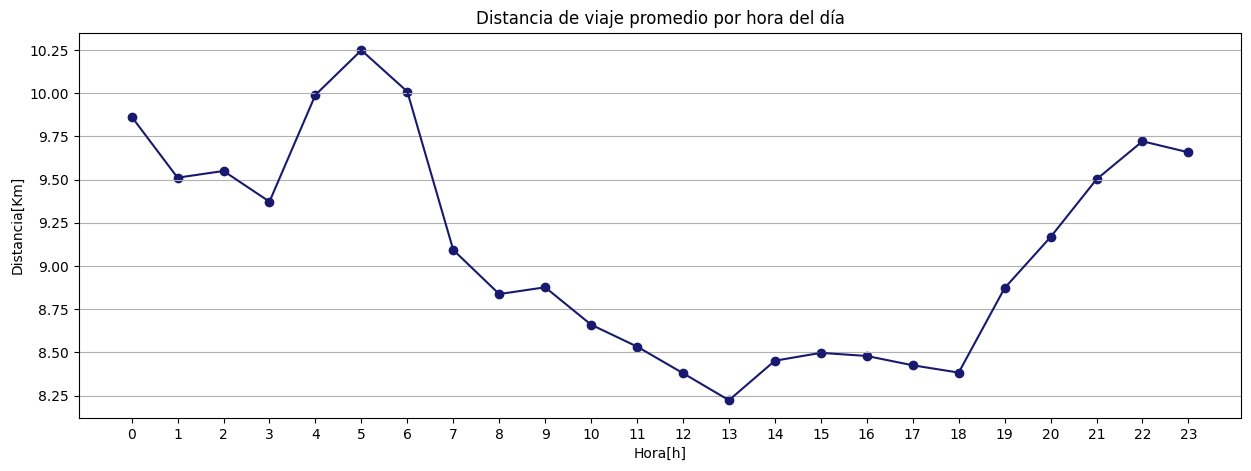

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(NewODMatrix.groupby('datehour')['Travel Distance[Km]'].mean().index,NewODMatrix.groupby('datehour')['Travel Distance[Km]'].mean().values,color='midnightblue')
#plt.plot(df_ODMatrix.groupby('datehour')['Travel Distance[Km]'].mean().index,df_ODMatrix.groupby('datehour')['Travel Distance[Km]'].mean().values,label='df_ODMatrix',color='midnightblue')
plt.scatter(NewODMatrix.groupby('datehour')['Travel Distance[Km]'].mean().index,NewODMatrix.groupby('datehour')['Travel Distance[Km]'].mean().values,color='midnightblue')
#plt.scatter(df_ODMatrix.groupby('datehour')['Travel Distance[Km]'].mean().index,df_ODMatrix.groupby('datehour')['Travel Distance[Km]'].mean().values,color='midnightblue')

plt.xlabel('Hora[h]')
plt.xticks(np.arange(0,24))
plt.ylabel('Distancia[Km]')
plt.title('Distancia de viaje promedio por hora del día')
plt.grid(axis='y')
plt.show()

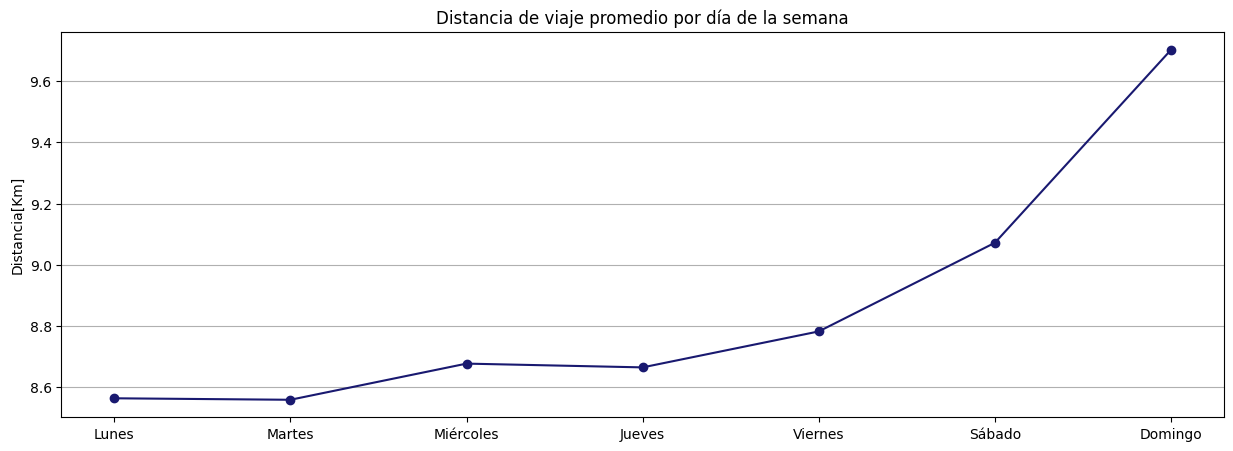

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(NewODMatrix.groupby('DayWeek_O')['Travel Distance[Km]'].mean().index,NewODMatrix.groupby('DayWeek_O')['Travel Distance[Km]'].mean().values,color='midnightblue')
#plt.plot(df_ODMatrix.groupby('DayWeek_O')['Travel Distance[Km]'].mean().index,df_ODMatrix.groupby('DayWeek_O')['Travel Distance[Km]'].mean().values,label='df_ODMatrix',color='midnightblue')
plt.scatter(NewODMatrix.groupby('DayWeek_O')['Travel Distance[Km]'].mean().index,NewODMatrix.groupby('DayWeek_O')['Travel Distance[Km]'].mean().values,color='midnightblue')
#plt.scatter(df_ODMatrix.groupby('DayWeek_O')['Travel Distance[Km]'].mean().index,df_ODMatrix.groupby('DayWeek_O')['Travel Distance[Km]'].mean().values,color='midnightblue')


plt.xticks(NewODMatrix.groupby('DayWeek_O')['Travel Distance[Km]'].mean().index,days)
plt.ylabel('Distancia[Km]')
plt.title('Distancia de viaje promedio por día de la semana')
plt.grid(axis='y')
plt.show()

###Valores promedio por usuario

In [ ]:
NewODMatrix['uid']=pd.factorize(NewODMatrix['uid'])[0]+1
df_ODMatrix['uid']=pd.factorize(df_ODMatrix['uid'])[0]+1

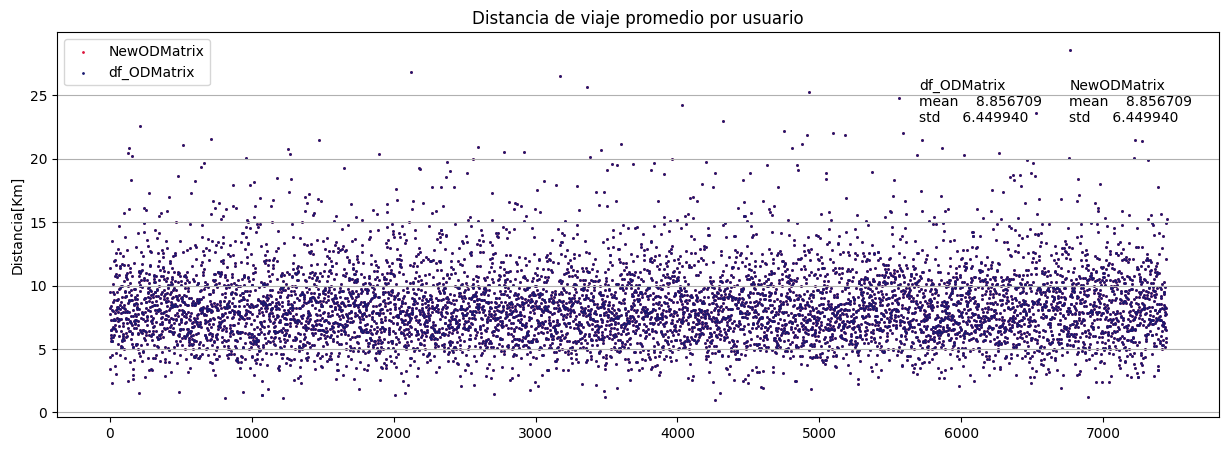

In [ ]:
plt.figure(figsize=(15,5))

plt.scatter(NewODMatrix.groupby('uid')['Travel Distance[Km]'].mean().index,NewODMatrix.groupby('uid')['Travel Distance[Km]'].mean().values,label='NewODMatrix',color='crimson',s=1)
plt.scatter(df_ODMatrix.groupby('uid')['Travel Distance[Km]'].mean().index,df_ODMatrix.groupby('uid')['Travel Distance[Km]'].mean().values,label='df_ODMatrix',color='midnightblue',s=1)

plt.ylabel('Distancia[Km]')
plt.title('Distancia de viaje promedio por usuario')
plt.figtext(0.8,0.7, 'NewODMatrix\n'+NewODMatrix['Travel Distance[Km]'].describe().loc[['mean','std']].to_string())
plt.figtext(0.7,0.7, 'df_ODMatrix\n'+df_ODMatrix['Travel Distance[Km]'].describe().loc[['mean','std']].to_string())
plt.grid(axis='y')
plt.legend()
plt.show()

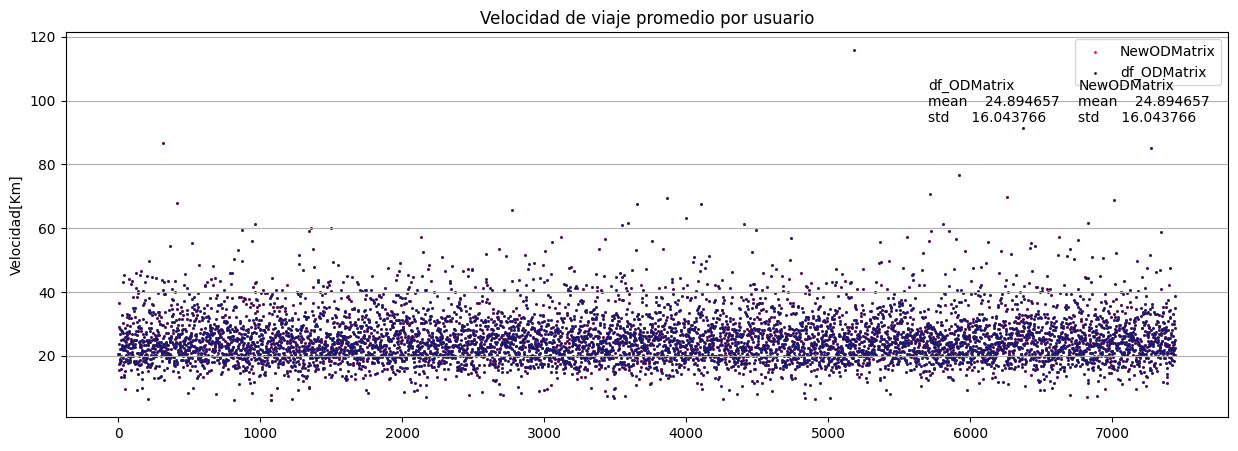

In [ ]:
plt.figure(figsize=(15,5))

plt.scatter(NewODMatrix.groupby('uid')['Speed[Km/h]'].mean().index,NewODMatrix.groupby('uid')['Speed[Km/h]'].mean().values,label='NewODMatrix',color='crimson',s=1)
plt.scatter(df_ODMatrix.groupby('uid')['Speed[Km/h]'].mean().index,df_ODMatrix.groupby('uid')['Speed[Km/h]'].mean().values,label='df_ODMatrix',color='midnightblue',s=1)

plt.ylabel('Velocidad[Km]')
plt.title('Velocidad de viaje promedio por usuario')
plt.figtext(0.8,0.7, 'NewODMatrix\n'+NewODMatrix['Speed[Km/h]'].describe().loc[['mean','std']].to_string())
plt.figtext(0.7,0.7, 'df_ODMatrix\n'+df_ODMatrix['Speed[Km/h]'].describe().loc[['mean','std']].to_string())
plt.grid(axis='y')
plt.legend()
plt.show()

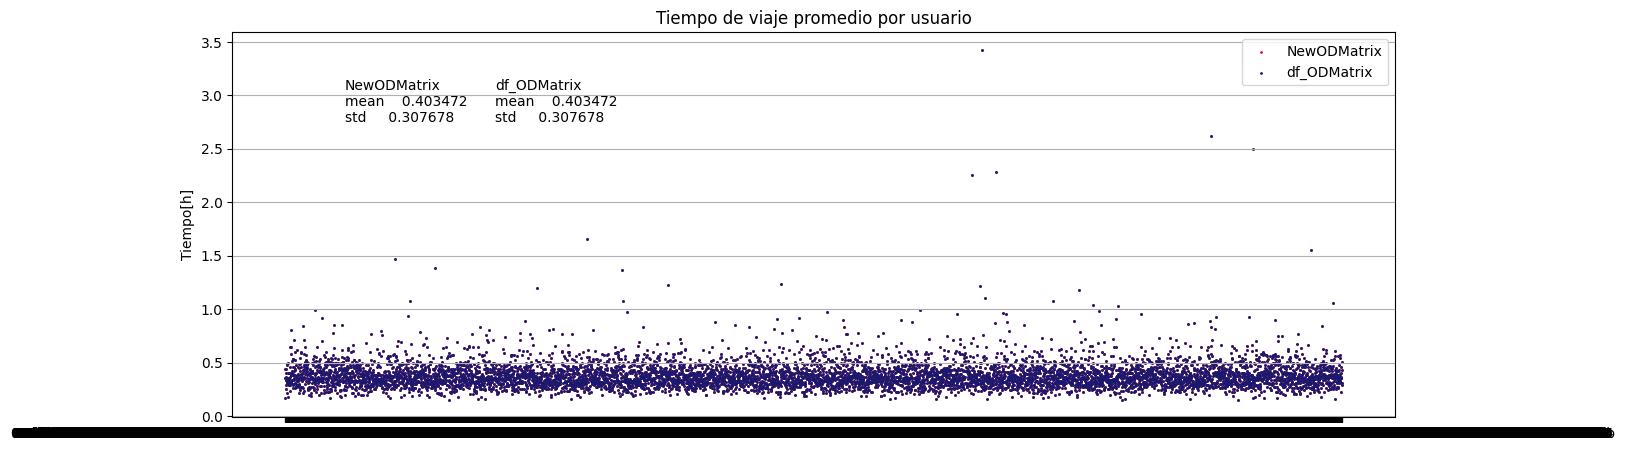

In [ ]:
plt.figure(figsize=(15,5))

plt.scatter(NewODMatrix.groupby('uid')['Travel_Time[h]'].mean().index,NewODMatrix.groupby('uid')['Travel_Time[h]'].mean().values,label='NewODMatrix',color='crimson',s=1)
plt.scatter(df_ODMatrix.groupby('uid')['Travel_Time[h]'].mean().index,df_ODMatrix.groupby('uid')['Travel_Time[h]'].mean().values,label='df_ODMatrix',color='midnightblue',s=1)

plt.ylabel('Tiempo[h]')
plt.title('Tiempo de viaje promedio por usuario')
plt.figtext(0.2,0.7, 'NewODMatrix\n'+NewODMatrix['Travel_Time[h]'].describe().loc[['mean','std']].to_string())
plt.figtext(0.3,0.7, 'df_ODMatrix\n'+df_ODMatrix['Travel_Time[h]'].describe().loc[['mean','std']].to_string())
plt.grid(axis='y')
plt.legend()
plt.show()

##Series de tiempo

In [ ]:
NewTS = NewODMatrix.groupby('date').mean(numeric_only=True)
NewTSSpeed = NewTS['Speed[Km/h]']
NewTSFreq = NewODMatrix.groupby('date').size()
NewTSDistance = NewTS['Travel Distance[Km]']
NewTSTime = NewTS['Travel_Time[h]']
NewT=[datetime.strptime(NewTS.index[i],'%Y-%m-%d').weekday() for i in range(len(NewTS))]

OldTS = df_ODMatrix.groupby('date').mean(numeric_only=True)
OldTSSpeed = OldTS['Speed[Km/h]']
OldTSDistance = OldTS['Travel Distance[Km]']
OldTSTime = OldTS['Travel_Time[h]']
OldT=[datetime.strptime(OldTS.index[i],'%Y-%m-%d').weekday() for i in range(len(OldTS))]

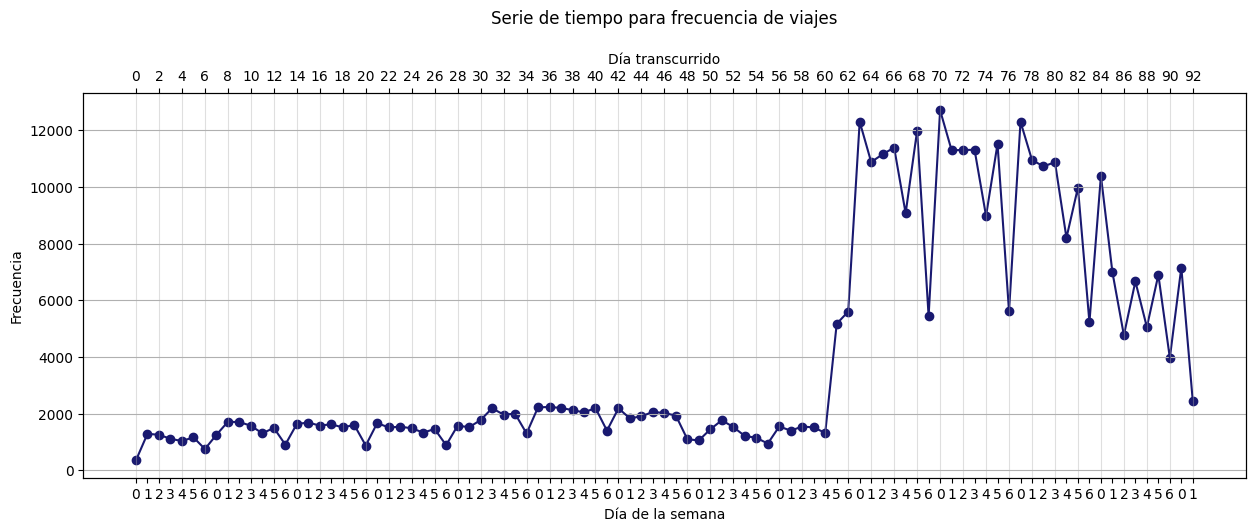

In [ ]:
fig, axs= plt.subplots(figsize=(15,5))
text='0: Lunes\n 1: Martes\n 2: Miércoles\n 3: Jueves\n 4: Viernes\n 5: Sábado\n 6: Domingo'

#fig.suptitle('Serie de tiempo para la velocidad')
axs.set_title('Serie de tiempo para frecuencia de viajes\n')
axs.plot(np.arange(len(NewT)),NewTSFreq,color='midnightblue')
axs.scatter(np.arange(len(NewT)),NewTSFreq,color='midnightblue')
axs.set_xticks(np.arange(len(NewT)),NewT)
axs.set_ylabel('Frecuencia')
axs.set_xlabel('Día de la semana')
axs.grid(axis='y')

ax2=axs.twiny()
ax2.set_xlim(axs.get_xlim())
ax2.set_xticks(np.arange(0,len(NewT),2))
ax2.grid(axis='x',alpha=0.4)
ax2.set_xlabel('Día transcurrido')
plt.show()

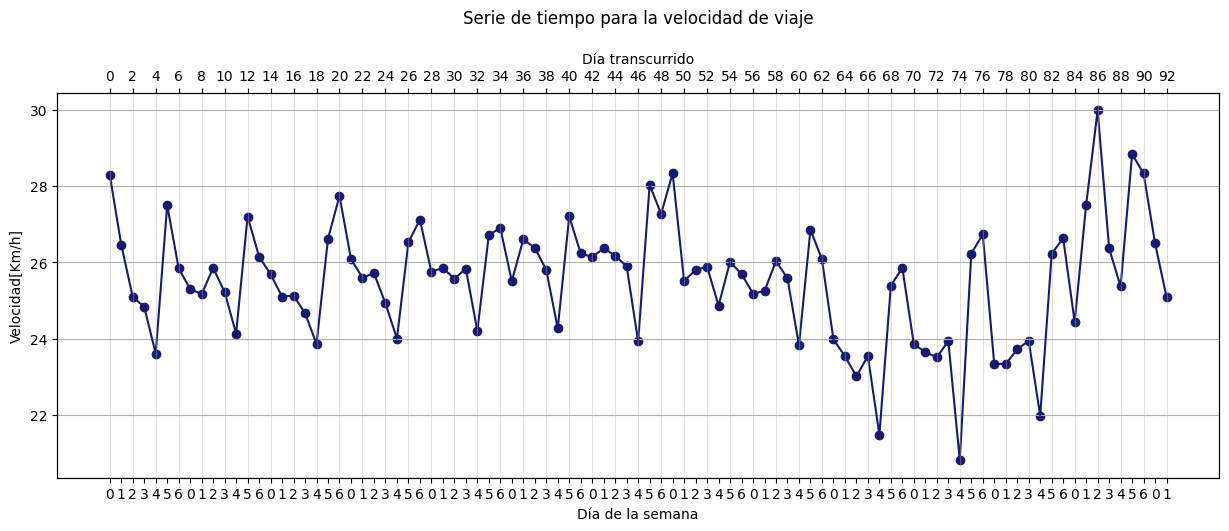

In [ ]:
fig, axs= plt.subplots(figsize=(15,5))
text='0: Lunes\n 1: Martes\n 2: Miércoles\n 3: Jueves\n 4: Viernes\n 5: Sábado\n 6: Domingo'

#fig.suptitle('Serie de tiempo para la velocidad')
axs.set_title('Serie de tiempo para la velocidad de viaje\n')
axs.plot(np.arange(len(NewT)),NewTSSpeed,color='midnightblue')
axs.scatter(np.arange(len(NewT)),NewTSSpeed,color='midnightblue')
axs.set_xticks(np.arange(len(NewT)),NewT)
axs.set_ylabel('Velocidad[Km/h]')
axs.set_xlabel('Día de la semana')
axs.grid(axis='y')

ax2=axs.twiny()
ax2.set_xlim(axs.get_xlim())
ax2.set_xticks(np.arange(0,len(NewT),2))
ax2.grid(axis='x',alpha=0.4)
ax2.set_xlabel('Día transcurrido')

# axs[1].set_title('df_ODMatrix')
# axs[1].plot(np.arange(len(OldT)),OldTSSpeed,color='midnightblue')
# axs[1].scatter(np.arange(len(OldT)),OldTSSpeed,color='midnightblue')
# axs[1].set_xticks(np.arange(len(OldT)),OldT)
# axs[1].set_ylabel('Velocidad[Km/h]')

plt.show()

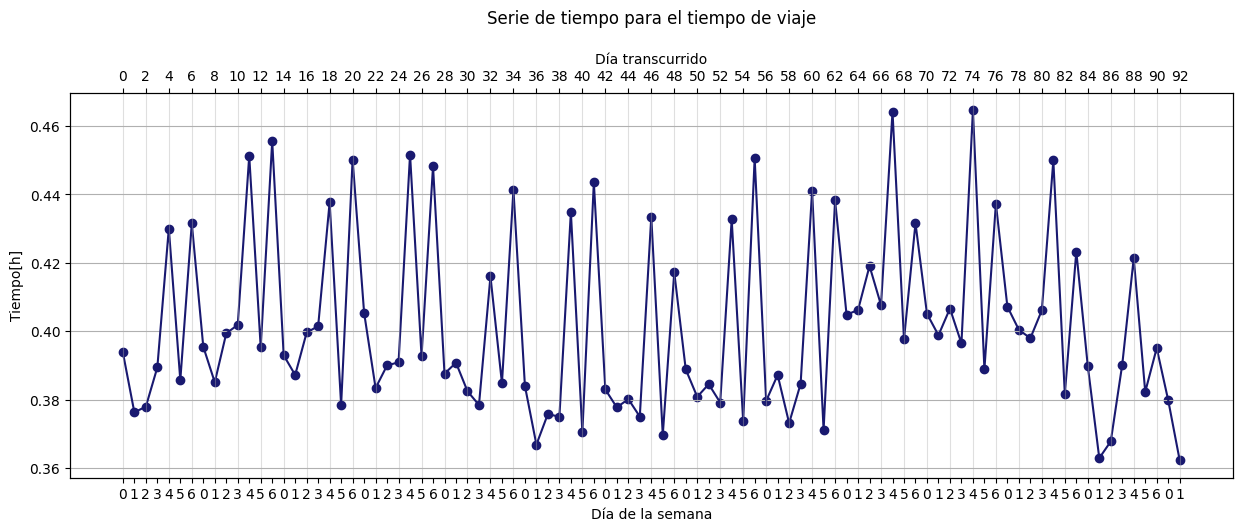

In [ ]:
fig, axs= plt.subplots(figsize=(15,5))
text='0: Lunes\n 1: Martes\n 2: Miércoles\n 3: Jueves\n 4: Viernes\n 5: Sábado\n 6: Domingo'

#fig.suptitle('Serie de tiempo para la el tiempo')
axs.set_title('Serie de tiempo para el tiempo de viaje\n')
axs.plot(np.arange(len(NewT)),NewTSTime,color='midnightblue')
axs.scatter(np.arange(len(NewT)),NewTSTime,color='midnightblue')
axs.set_xticks(np.arange(len(NewT)),NewT)
axs.set_ylabel('Tiempo[h]')
axs.set_xlabel('Día de la semana')
axs.grid(axis='y')

ax2=axs.twiny()
ax2.set_xlim(axs.get_xlim())
ax2.set_xticks(np.arange(0,len(NewT),2))
ax2.grid(axis='x',alpha=0.4)
ax2.set_xlabel('Día transcurrido')

# axs[1].set_title('df_ODMatrix')
# axs[1].plot(np.arange(len(OldT)),OldTSTime,color='midnightblue')
# axs[1].scatter(np.arange(len(OldT)),OldTSTime,color='midnightblue')
# axs[1].set_xticks(np.arange(len(OldT)),OldT)
# axs[1].set_ylabel('Tiempo[h]')

plt.show()

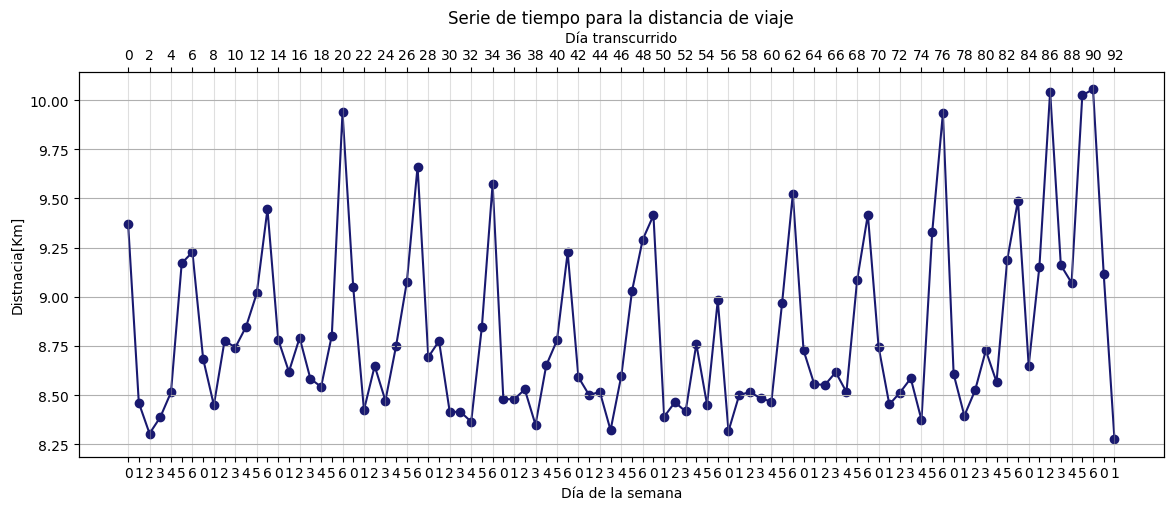

In [ ]:
fig, axs= plt.subplots(figsize=(14,5))
text='0: Lunes\n 1: Martes\n 2: Miércoles\n 3: Jueves\n 4: Viernes\n 5: Sábado\n 6: Domingo'

#fig.suptitle('Serie de tiempo para la distancia')
axs.set_title('Serie de tiempo para la distancia de viaje\n')
axs.plot(np.arange(len(NewT)),NewTSDistance,color='midnightblue')
axs.scatter(np.arange(len(NewT)),NewTSDistance,color='midnightblue')
axs.set_xticks(np.arange(len(NewT)),NewT)
axs.set_ylabel('Distnacia[Km]')
axs.set_xlabel('Día de la semana')
axs.grid(axis='y')

ax2=axs.twiny()
ax2.set_xlim(axs.get_xlim())
ax2.set_xticks(np.arange(0,len(NewT),2))
ax2.grid(axis='x',alpha=0.4)
ax2.set_xlabel('Día transcurrido')

#axs[1].set_title('df_ODMatrix')
#axs[1].plot(np.arange(len(OldT)),OldTSDistance,color='midnightblue')
#axs[1].scatter(np.arange(len(OldT)),OldTSDistance,color='midnightblue')
#axs[1].set_xticks(np.arange(len(OldT)),OldT)
#axs[1].set_ylabel('Distancia[Km]')

plt.show()

In [ ]:
NewODMatrix['CountOrbyUid']=NewODMatrix.groupby(['uid','index_origin'])['index_origin'].transform('count')
NewODMatrix['CountDesbyUid']=NewODMatrix.groupby(['uid','index_destination'])['index_destination'].transform('count')
NewODMatrix['CountOr'] = NewODMatrix.groupby(['index_origin'])['index_origin'].transform('count')
NewODMatrix['CountDes'] = NewODMatrix.groupby(['index_destination'])['index_destination'].transform('count')

NewODMatrix[['CountDesbyUid','CountOrbyUid','CountOr','CountDes']].describe()

CountDesbyUid   CountOrbyUid        CountOr       CountDes
count  371494.000000  371494.000000  371494.000000  371494.000000
mean        7.412179       9.887282      84.654347      83.629803
std        10.391429      12.879521     148.066049     140.843993
min         1.000000       1.000000       1.000000       1.000000
25%         1.000000       1.000000      17.000000      16.000000
50%         2.000000       3.000000      41.000000      39.000000
75%        11.000000      17.000000      87.000000      86.000000
max        90.000000     107.000000    1419.000000    1220.000000

###Mapa de calor y clasificación de modos de transporte

In [ ]:
NewODMatrix[NewODMatrix['Travel Distance[Km]']<=1.5]['Travel Distance[Km]'].count()

In [ ]:
def TranspMode(Dis):
  if Dis<=1.5:
    return 'Walking'
  else:
    return 'Car'
NewODMatrix['Transportation Mode']=NewODMatrix['Travel Distance[Km]'].apply(TranspMode)
NewODMatrix['Transportation Mode'].describe()

In [ ]:
a=NewODMatrix.groupby('Transportation Mode').mean()
a['Travel Distance[Km]']

In [ ]:
Countdf1 = NewODMatrix.groupby(by=['dsemana','datehour']).size().reset_index(name='count')
Counthour1 = NewODMatrix.groupby(by=['datehour']).size().reset_index(name='count')
Countday1 = NewODMatrix.groupby(by=['dsemana']).size().reset_index(name='count')

HeatMap1=np.zeros((7,24))
for _,row in Countdf1.iterrows():
  HeatMap1[row['dsemana']][row['datehour']]=row['count']

Countdf2 = df_ODMatrix.groupby(by=['dsemana','datehour']).size().reset_index(name='count')
Counthour2 = df_ODMatrix.groupby(by=['datehour']).size().reset_index(name='count')
Countday2 = df_ODMatrix.groupby(by=['dsemana']).size().reset_index(name='count')
HeatMap2=np.zeros((7,24))
for _,row in Countdf2.iterrows():
  HeatMap2[row['dsemana']][row['datehour']]=row['count']

FilterHeatMap=False

if FilterHeatMap:
  HeatMap1[0][0]=0
  HeatMap2[0][0]=0
  HeatMap1[5][0]=0
  HeatMap2[5][0]=0

In [ ]:
Counthour1['count'].argmax()

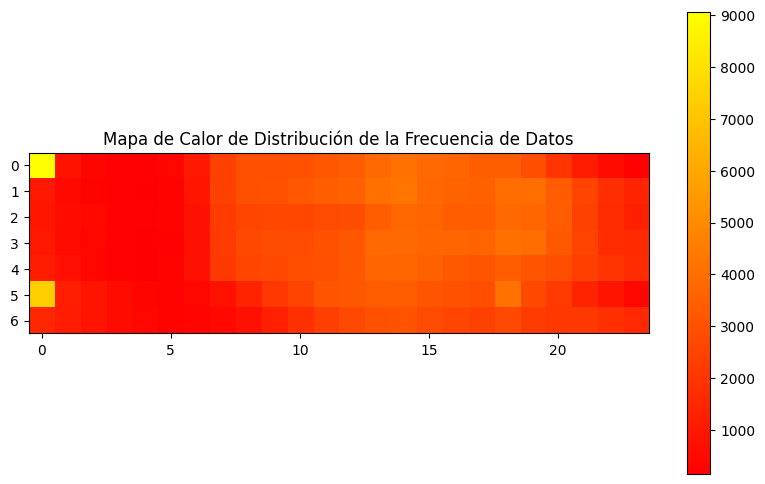

In [ ]:
fig,axs=plt.subplots(figsize=(10,6))

im1=axs.imshow(HeatMap1,cmap='autumn')
#plt.xticks(np.arange(1,24))
axs.set_yticks(np.arange(7))
axs.set_title('Mapa de Calor de Distribución de la Frecuencia de Datos')
plt.colorbar(im1, ax=axs)

#im2=axs[1].imshow(HeatMap2,cmap='autumn')
##plt.xticks(np.arange(1,24))
#axs[1].set_yticks(np.arange(7))
#axs[1].set_title('df_ODMatrix')
#plt.colorbar(im2, ax=axs[1])

plt.show()

###Estudio del aereopuerto

In [ ]:
coords=(((25.785967647734847, -100.15001179008736)),(25.795285736049582, -100.1272409269127),(25.760406696984425, -100.05957175246164),(25.750940133929117, -100.06736014500557))
AirportPolygon = Polygon(coords)
Filter=[]
for _,row in NewODMatrix.iterrows():
  Filter.append(AirportPolygon.contains(Point([row['latdes'],row['lngdes']])))
Airportdf=NewODMatrix.loc[Filter]
len(Airportdf)

2036

In [ ]:
NewTS = Airportdf.groupby('date').mean(numeric_only=True)
NewTSSpeed = NewTS['Speed[Km/h]']
NewTSFreq = Airportdf.groupby('date').size()
NewTSDistance = NewTS['Travel Distance[Km]']
NewTSTime = NewTS['Travel_Time[h]']
NewT=[datetime.strptime(NewTS.index[i],'%Y-%m-%d').weekday() for i in range(len(NewTS))]

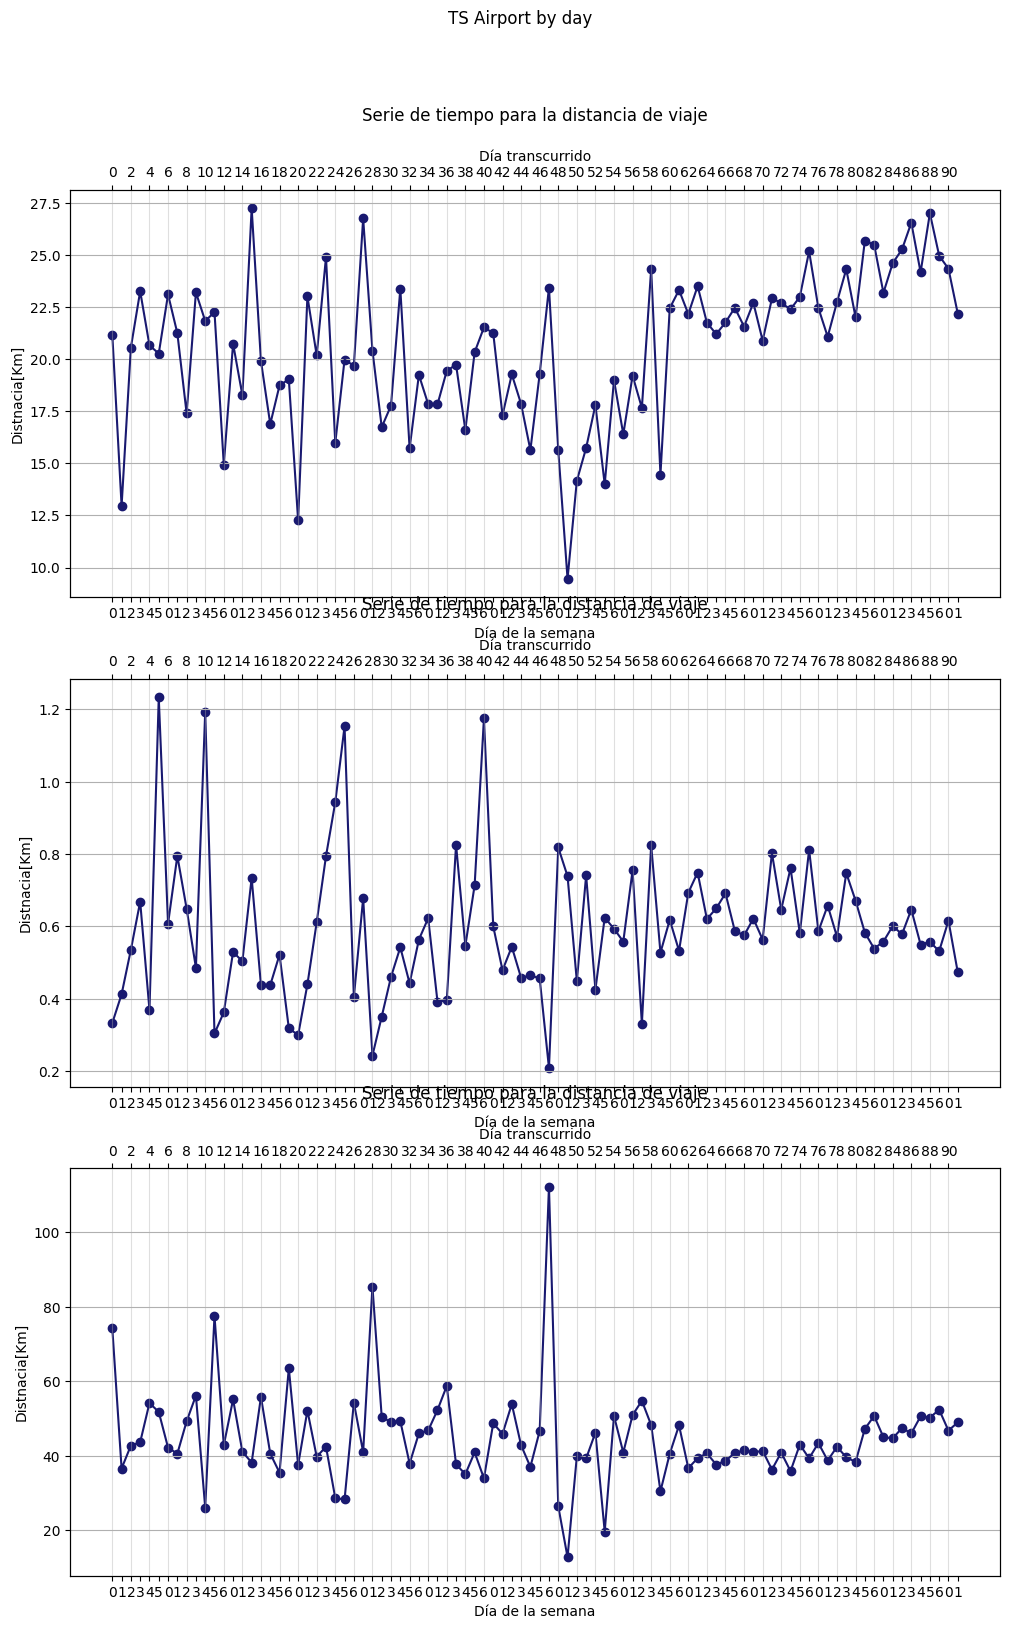

In [ ]:
fig,axs = plt.subplots(3,1,figsize=(12,18))
fig.suptitle('TS Airport by day')

axs[0].set_title('Serie de tiempo para la distancia de viaje\n')
axs[0].plot(np.arange(len(NewT)),NewTSDistance,color='midnightblue')
axs[0].scatter(np.arange(len(NewT)),NewTSDistance,color='midnightblue')
axs[0].set_xticks(np.arange(len(NewT)),NewT)
axs[0].set_ylabel('Distnacia[Km]')
axs[0].set_xlabel('Día de la semana')
axs[0].grid(axis='y')

ax2=axs[0].twiny()
ax2.set_xlim(axs[0].get_xlim())
ax2.set_xticks(np.arange(0,len(NewT),2))
ax2.grid(axis='x',alpha=0.4)
ax2.set_xlabel('Día transcurrido')

axs[1].set_title('Serie de tiempo para la distancia de viaje\n')
axs[1].plot(np.arange(len(NewT)),NewTSTime,color='midnightblue')
axs[1].scatter(np.arange(len(NewT)),NewTSTime,color='midnightblue')
axs[1].set_xticks(np.arange(len(NewT)),NewT)
axs[1].set_ylabel('Distnacia[Km]')
axs[1].set_xlabel('Día de la semana')
axs[1].grid(axis='y')

ax2=axs[1].twiny()
ax2.set_xlim(axs[1].get_xlim())
ax2.set_xticks(np.arange(0,len(NewT),2))
ax2.grid(axis='x',alpha=0.4)
ax2.set_xlabel('Día transcurrido')

axs[2].set_title('Serie de tiempo para la distancia de viaje\n')
axs[2].plot(np.arange(len(NewT)),NewTSSpeed,color='midnightblue')
axs[2].scatter(np.arange(len(NewT)),NewTSSpeed,color='midnightblue')
axs[2].set_xticks(np.arange(len(NewT)),NewT)
axs[2].set_ylabel('Distnacia[Km]')
axs[2].set_xlabel('Día de la semana')
axs[2].grid(axis='y')

ax2=axs[2].twiny()
ax2.set_xlim(axs[2].get_xlim())
ax2.set_xticks(np.arange(0,len(NewT),2))
ax2.grid(axis='x',alpha=0.4)
ax2.set_xlabel('Día transcurrido')

plt.show()

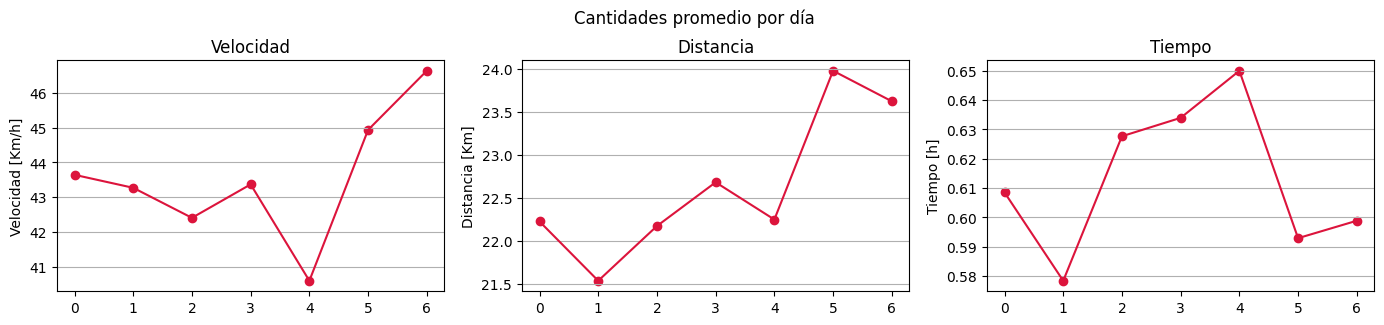

In [ ]:
#time series for day of week
AirTS = Airportdf.groupby('dsemana').mean(numeric_only=True)

fig,axs = plt.subplots(1,3,figsize=(17,3))
fig.suptitle('Cantidades promedio por día',y=1.05)

axs[0].set_title('Velocidad')
axs[0].plot(np.arange(7),AirTS['Speed[Km/h]'],color='crimson')
axs[0].scatter(np.arange(7),AirTS['Speed[Km/h]'],color='crimson')
axs[0].set_xticks(np.arange(7))
axs[0].set_xlabel('Día')
axs[0].grid(axis='y')
axs[0].set_ylabel('Velocidad [Km/h]')

axs[1].set_title('Distancia')
axs[1].plot(np.arange(7),AirTS['Travel Distance[Km]'],color='crimson')
axs[1].scatter(np.arange(7),AirTS['Travel Distance[Km]'],color='crimson')
axs[1].set_xlabel('Día')
axs[1].set_xticks(np.arange(7))
axs[1].grid(axis='y')
axs[1].set_ylabel('Distancia [Km]')

axs[2].set_title('Tiempo')
axs[2].plot(np.arange(7),AirTS['Travel_Time[h]'],color='crimson')
axs[2].scatter(np.arange(7),AirTS['Travel_Time[h]'],color='crimson')
axs[2].set_xticks(np.arange(7))
axs[2].set_xlabel('Día')
axs[2].grid(axis='y')
axs[2].set_ylabel('Tiempo [h]')

plt.show()

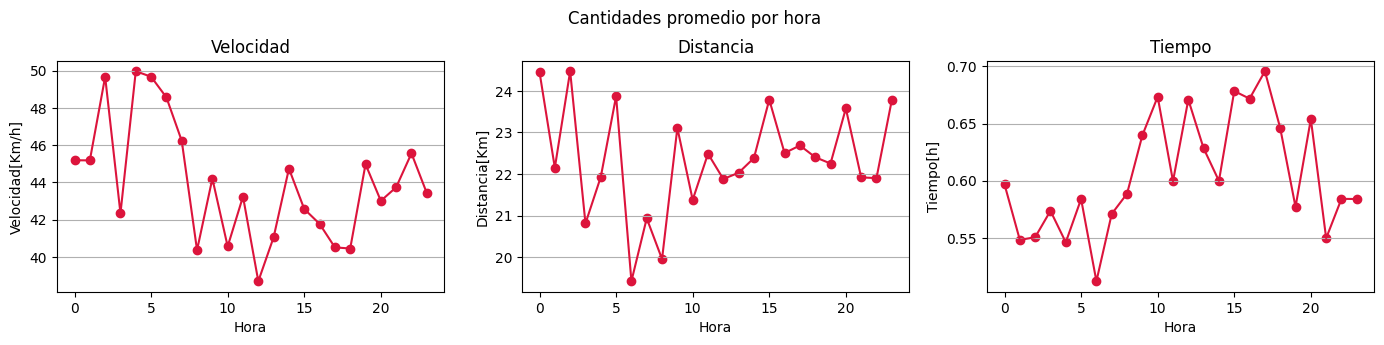

In [ ]:
#time series for day of week
AirTS = Airportdf.groupby('datehour').mean(numeric_only=True)

fig,axs = plt.subplots(1,3,figsize=(17,3))
fig.suptitle('Cantidades promedio por hora',y=1.05)

axs[0].set_title('Velocidad')
axs[0].plot(np.arange(24),AirTS['Speed[Km/h]'],color='crimson')
axs[0].scatter(np.arange(24),AirTS['Speed[Km/h]'],color='crimson')
#axs[0].set_xticks(np.arange(24))
axs[0].grid(axis='y')
axs[0].set_xlabel('Hora')
axs[0].set_ylabel('Velocidad[Km/h]')

axs[1].set_title('Distancia')
axs[1].plot(np.arange(24),AirTS['Travel Distance[Km]'],color='crimson')
axs[1].scatter(np.arange(24),AirTS['Travel Distance[Km]'],color='crimson')
axs[1].set_xlabel('Hora')
#axs[1].set_xticks(np.arange(24))
axs[1].grid(axis='y')
axs[1].set_ylabel('Distancia[Km]')

axs[2].set_title('Tiempo')
axs[2].plot(np.arange(24),AirTS['Travel_Time[h]'],color='crimson')
axs[2].scatter(np.arange(24),AirTS['Travel_Time[h]'],color='crimson')
axs[2].set_xlabel('Hora')
#axs[2].set_xticks(np.arange(24))
axs[2].grid(axis='y')
axs[2].set_ylabel('Tiempo[h]')


plt.show()

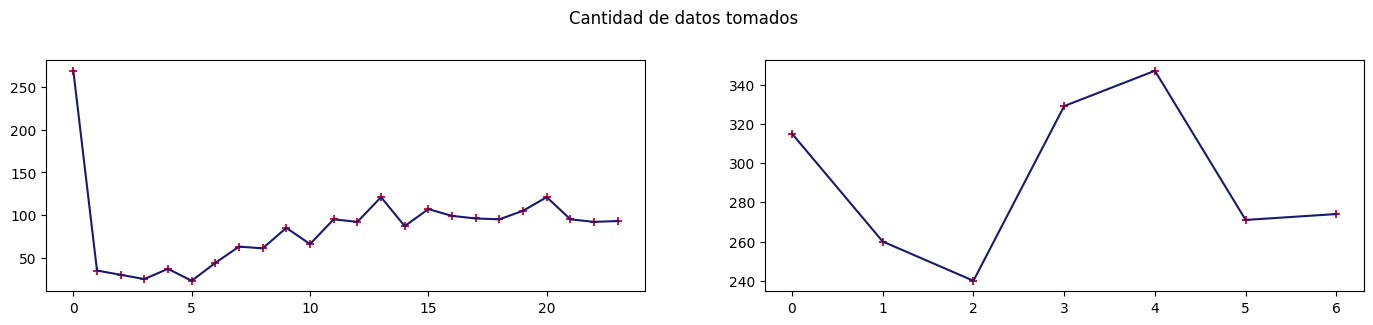

In [ ]:
HourSize=[hour for hour in Airportdf.groupby('datehour').size()]
DaySize=[day for day in Airportdf.groupby('dsemana').size()]
fig,axs = plt.subplots(1,2,figsize=(17,3))
fig.suptitle('Cantidad de datos tomados',y=1.05)

axs[0].plot(np.arange(24),HourSize, color='midnightblue')
axs[0].scatter(np.arange(24),HourSize, color='crimson',marker='+')

axs[1].plot(np.arange(7),DaySize, color='midnightblue')
axs[1].scatter(np.arange(7),DaySize, color='crimson',marker='+')

plt.show()


In [ ]:
Airportdf.groupby('datehour').size()

datehour
0     269
1      35
2      30
3      25
4      37
5      23
6      44
7      63
8      61
9      85
10     66
11     95
12     92
13    121
14     87
15    107
16     99
17     96
18     95
19    105
20    121
21     95
22     92
23     93
dtype: int64

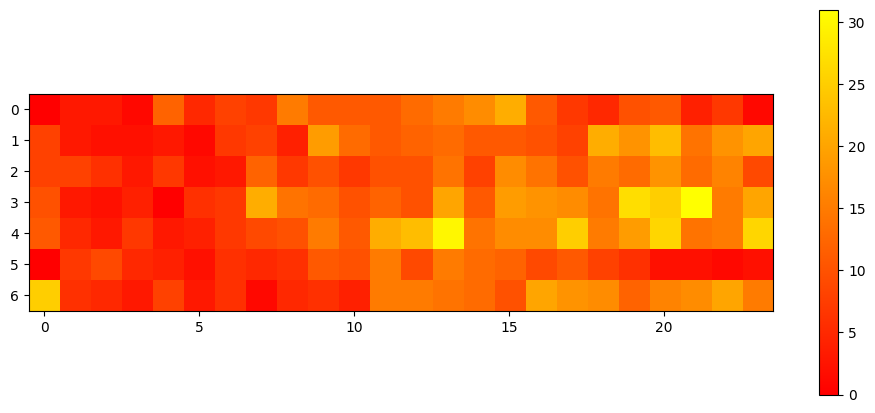

In [ ]:
Countdf = Airportdf.groupby(by=['dsemana','datehour']).size().reset_index(name='count')
HeatMap=np.zeros((7,24))
for _,row in Countdf.iterrows():
  HeatMap[row['dsemana']][row['datehour']]=row['count']
HeatMap[0][0]=0
HeatMap[5][0]=0

plt.figure(figsize=(12,5))
im=plt.imshow(HeatMap,cmap='autumn')
plt.colorbar(im)
plt.show()

##Aplicación de los modelos

In [ ]:
df_ODMatrix = pd.read_csv('/content/drive/MyDrive/Smart Mobility/df_ODMatrix.csv')

df_ODMatrix=df_ODMatrix.drop(df_ODMatrix[df_ODMatrix['Travel Distance[Km]']<0.3].index)
df_ODMatrix=df_ODMatrix.drop(df_ODMatrix[df_ODMatrix['Travel_Time[h]']<0.15].index)
df_ODMatrix=df_ODMatrix.drop(df_ODMatrix[df_ODMatrix['Travel_Time[h]']>=12].index)


df_ODMatrix.insert(5,'Speed[Km/h]',df_ODMatrix['Travel Distance[Km]']/df_ODMatrix['Travel_Time[h]'])

df_ODMatrix=df_ODMatrix.drop(df_ODMatrix[df_ODMatrix['Speed[Km/h]']>120].index)
df_ODMatrix=df_ODMatrix.drop(df_ODMatrix[df_ODMatrix['Speed[Km/h]']<1].index)

#df_ODMatrix['count_or'] = df_ODMatrix['h3_origin'].map(stops['uid'].value_counts())
#df_ODMatrix['count_des'] = df_ODMatrix['h3_destination'].map(stops['uid'].value_counts())

df_ODMatrix=df_ODMatrix.reset_index(drop=True)

In [ ]:
NewODMatrix = pd.read_csv('/content/drive/MyDrive/Smart Mobility/NewODMatrix.csv')
print(len(NewODMatrix))
index2correct = NewODMatrix[NewODMatrix['Travel Distance[Km]'].isnull()].index
for i in index2correct:
  NewODMatrix['Travel Distance[Km]'][i]=geodesic((NewODMatrix['lator'][i],NewODMatrix['lngor'][i]),(NewODMatrix['latdes'][i],NewODMatrix['lngdes'][i])).km

NewODMatrix=NewODMatrix.drop(NewODMatrix[NewODMatrix['Travel_Time[h]']<0.15].index)
NewODMatrix=NewODMatrix.drop(NewODMatrix[NewODMatrix['Travel Distance[Km]']<0.14].index)
NewODMatrix=NewODMatrix.drop(NewODMatrix[NewODMatrix['Travel Distance[Km]']>50].index)
NewODMatrix=NewODMatrix.drop(NewODMatrix[NewODMatrix['Travel_Time[h]']>=12].index)

speed=NewODMatrix['Travel Distance[Km]']/NewODMatrix['Travel_Time[h]']
NewODMatrix.insert(+1,'Speed[Km/h]',speed)

NewODMatrix=NewODMatrix.drop(NewODMatrix[NewODMatrix['Speed[Km/h]']>=120].index)
NewODMatrix=NewODMatrix.drop(NewODMatrix[NewODMatrix['Speed[Km/h]']<6].index)

NewODMatrix=NewODMatrix.drop(NewODMatrix[NewODMatrix['PoblOr']==0].index)
NewODMatrix=NewODMatrix.drop(NewODMatrix[NewODMatrix['PoblDes']==0].index)

del NewODMatrix['Unnamed: 0']

#NewODMatrix=NewODMatrix[NewODMatrix['datehour']==18]

NewODMatrix=NewODMatrix.reset_index(drop=True)
len(NewODMatrix)

1412612


339152

In [ ]:
h3_pol = pd.read_csv('/content/drive/MyDrive/Smart Mobility/DataMap.csv')
auxset=set(NewODMatrix['h3_origin'].unique()).union(set(NewODMatrix['h3_destination'].unique()))
h3_pol=h3_pol[h3_pol['h3_polyfill'].isin(auxset)]
print(len(h3_pol))
#h3_pol=h3_pol.iloc[:12760]
h3_pol = h3_pol.sort_values(by='Pobl')
h3_pol=h3_pol.reset_index(drop=True)
h3_pol['id_o']=(h3_pol.index).astype('int')
h3_pol = h3_pol.rename(columns={'id_o':'new_id'})
h3_pol.describe()

27871


new_id          index           lat           lng          Pobl  \
count  27871.000000   27871.000000  27871.000000  27871.000000  27871.000000   
mean   13935.000000  173996.115999     25.689465   -100.286349    118.754018   
std     8045.809013  118362.165764      0.083534      0.102937     90.016531   
min        0.000000    2658.000000     25.348398   -100.637361      0.016459   
25%     6967.500000   38516.000000     25.652286   -100.360007     43.754519   
50%    13935.000000  196989.000000     25.691911   -100.283069     98.968079   
75%    20902.500000  211212.000000     25.746043   -100.214819    181.589650   
max    27870.000000  433073.000000     25.974051    -99.970681    573.532908   

          Dens_Pobl     id_origin  
count  27871.000000  27871.000000  
mean    6702.027201  22841.107890  
std     5080.253632  12061.283914  
min        0.928887     21.000000  
25%     2468.425049  12018.000000  
50%     5582.445312  24397.000000  
75%    10248.430664  32436.500000  
max    32316.308594  43417.000000

In [ ]:
NewODMatrix = pd.merge(NewODMatrix,h3_pol,left_on='id_origin',right_on='id_origin',how='left')
NewODMatrix = NewODMatrix.drop(['h3_polyfill', 'index', 'geometry', 'lat', 'lng', 'Pobl', 'Dens_Pobl_y','id_o','index_origin','id_origin','NOMGEO_x','Dens_Pobl_x'],axis=1)
NewODMatrix = NewODMatrix.rename(columns={'new_id':'id_ori'})
NewODMatrix = NewODMatrix.dropna(subset='id_ori')

NewODMatrix = pd.merge(NewODMatrix,h3_pol,left_on='id_destination',right_on='id_origin',how='left')
NewODMatrix = NewODMatrix.drop(['h3_polyfill', 'index', 'geometry', 'lat', 'lng', 'Pobl', 'Dens_Pobl','id_origin'],axis=1)
NewODMatrix = NewODMatrix.rename(columns={'new_id':'id_des'})
NewODMatrix = NewODMatrix.dropna(subset='id_des')

NewODMatrix=NewODMatrix.reset_index(drop=True)
NewODMatrix['id_ori']=NewODMatrix['id_ori'].astype('int')
NewODMatrix['id_des']=NewODMatrix['id_des'].astype('int')

NewODMatrix[['id_ori','id_des']].describe()

id_ori         id_des
count  339152.000000  339152.000000
mean    11261.512116   11158.987065
std      6835.385246    6766.286082
min         0.000000       0.000000
25%      5460.000000    5413.000000
50%     10412.000000   10327.000000
75%     15979.000000   15778.000000
max     27870.000000   27870.000000

In [ ]:
def ODCalculation(df, maximum):
    matrixod = np.zeros((maximum, maximum), dtype=int)

    for i in range(len(df)):
        row = df.loc[i,'id_ori']
        col = df.loc[i,'id_des']
        matrixod[row][col] += 1
        # if row < maximum and col < maximum:
        #     matrixod[row][col] += 1
    return matrixod

In [ ]:
ODMatrix = ODCalculation(NewODMatrix,len(h3_pol))

In [ ]:
DistMatrix=np.load('/content/drive/MyDrive/Smart Mobility/data/DistMatrix.npy',allow_pickle=True)

rij = np.where(DistMatrix==0,1,DistMatrix)
filtrij = np.where(DistMatrix==0,-1,1)

In [ ]:
SortedDist = np.sort(DistMatrix,axis=1)
GetIndexSort = np.argsort(DistMatrix,axis=1)

In [ ]:
m_j=np.array([h3_pol['Pobl'].values for i in range(len(h3_pol))])
m_i=np.transpose(m_j)
M = np.sum(h3_pol['Pobl'].values)
Ms = h3_pol['Pobl'].values
AllM=h3_pol['Pobl'].values

auxcount = NewODMatrix['id_ori'].value_counts()
auxOi = pd.Series(0, index=h3_pol['new_id']).add(auxcount, fill_value=0)
auxOi = auxOi.astype(int).to_numpy()
O_i = np.array([auxOi for i in range(len(h3_pol))])
O_i = np.transpose(O_i)

In [ ]:
def Vij(i,j):
  jindex = np.where(GetIndexSort[i]==j)[0][0]
  Vindex = GetIndexSort[i][1:jindex]

  Vij = np.sum(AllM[Vindex])
  return Vij

def Vin(i):
  Vin = M-Ms[i]
  return Vin

In [ ]:
size=len(h3_pol)
AllVin = [[Vin(i) for j in range(len(h3_pol))]for i in range(len(h3_pol))]
AllVin = np.array(AllVin)

In [ ]:
AllVij=np.load('/content/drive/MyDrive/Smart Mobility/data/AllVij.npy',allow_pickle=True)
AuxAllVij = np.load('/content/drive/MyDrive/Smart Mobility/data/AuxAllVij.npy',allow_pickle=True)

In [ ]:
FlatOD = ODMatrix.flatten()
Flatm_i = m_i.flatten()
Flatm_j = m_j.flatten()
FlatO_i = O_i.flatten()
Flatrij = rij.flatten()
Flatfilter  = filtrij.flatten()
FlatVij = AllVij.flatten()
FlatauxVij = AuxAllVij.flatten()
FlatVin = AllVin.flatten()

In [ ]:
print(np.max(FlatOD))

10


In [ ]:
#A=1
A=10/1314518.8726103073
def GravModel(params,m_i,m_j,rij):
  Beta = params
  ODM =Flatfilter*A*m_i*m_j/(rij**Beta)
  ODM = np.where(ODM < 0,0,ODM)

  return ODM

def IOModel(L,O_i,Vij,auxVij,Vin):

  ODM = O_i*(math.e**(-L*auxVij)-math.e**(-L*Vij))/(1-math.e**(-L*Vin))

  return ODM

def RadModel(O_i,m_i,m_j,vij):

  ODM = O_i*(1/(1-m_i/M))*((m_i*m_j)/((m_i+vij)*(m_i+m_j+vij)))

  return ODM

In [ ]:
mse_Grav = []
beta_Grav = []

def callbackGrav(params):
    mse = ErrorGrav(params,Flatm_i,Flatm_j,Flatrij,FlatOD)
    beta_Grav.append(params)
    mse_Grav.append(mse)


mse_IO = []
L_IO = []

def callbackIO(L):
    mse = ErrorIO(L,FlatO_i,FlatVij,FlatauxVij,FlatVin,FlatOD)
    L_IO.append(L)
    mse_IO.append(mse)

In [ ]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error as MSE

def ErrorGrav(params,m_i,m_j,rij,ODMatrix):
  GravODM = GravModel(params,m_i,m_j,rij)
  return MSE(ODMatrix,GravODM)

def ErrorRad(O_i,m_i,m_j,vij,ODMatrix):
  RadODM = RadModel(O_i,m_i,m_j,vij)
  return MSE(ODMatrix,RadODM)

def ErrorIO(L,O_i,Vij,auxVij,Vin,ODMatrix):
  IOODM = IOModel(L,O_i,Vij,auxVij,Vin)
  return MSE(ODMatrix,IOODM)

In [ ]:
mse_Grav = []
beta_Grav = []


ResultGrav = minimize(ErrorGrav,[1],args=(Flatm_i,Flatm_j,Flatrij,FlatOD),method='bfgs',callback=callbackGrav)

Params = ResultGrav.x
Params

array([0.87400915])

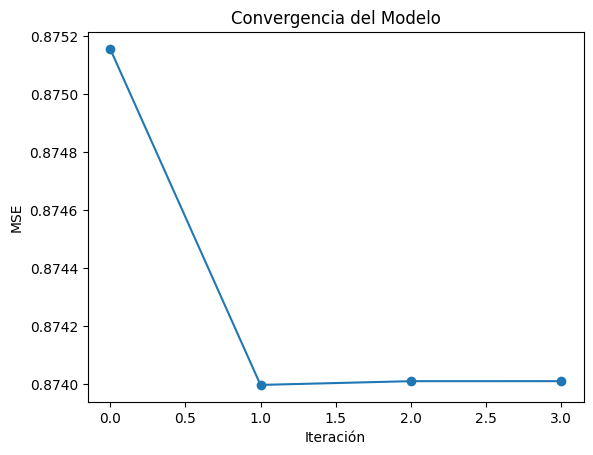

In [ ]:
plt.plot(range(len(beta_Grav)), beta_Grav, marker='o')
plt.xlabel('Iteración')
plt.ylabel('MSE')
plt.title('Convergencia del Modelo')
plt.show()

In [ ]:
mse_IO = []
L_IO = []
opciones = {'maxiter': '10'}

ResultIO = minimize(ErrorIO,[0.8],args=(FlatO_i,FlatVij,FlatauxVij,FlatVin,FlatOD),callback=callbackIO)
L = ResultIO.x
L

array([0.8])

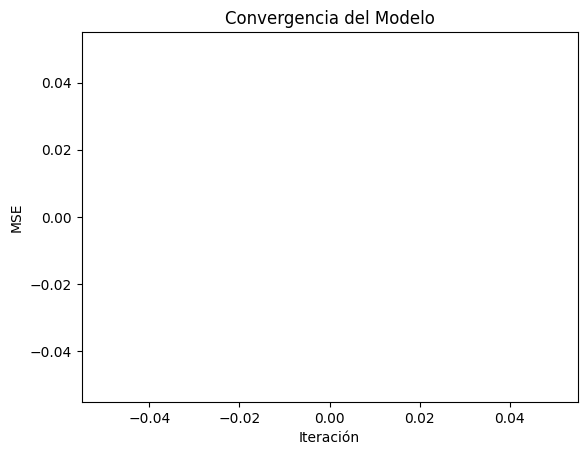

In [ ]:
plt.plot(range(len(L_IO)), L_IO, marker='o')
plt.xlabel('Iteración')
plt.ylabel('MSE')
plt.title('Convergencia del Modelo')
plt.show()

In [ ]:
np.max(GravModel([Params[0]],Flatm_i,Flatm_j,Flatrij))

1314518.8726103073

In [ ]:
GravOD = GravModel([Params[0]],Flatm_i,Flatm_j,Flatrij)
RadOD = RadModel(FlatO_i,Flatm_i,Flatm_j,FlatVij)
IOOD = IOModel(0.6,FlatO_i,FlatVij,FlatauxVij,FlatVin)

#RadOD *= 10/np.max(RadOD)
#IOOD *= 10/np.max(IOOD)

GravOD = GravOD.astype(int)
RadOD = RadOD.astype(int)
IOOD = IOOD.astype(int)

In [ ]:
auxGrav,auxRad,auxIO,auxOD = np.where(GravOD>=1),np.where((RadOD>=1)&(RadOD<=10)),np.where((IOOD>=1)&(IOOD<=10)),np.where(FlatOD>=1)
len(auxGrav[0]),len(auxRad[0]),len(auxIO[0]),len(auxOD[0])

(18056, 9564, 7089, 22133)

In [ ]:
len(np.where(RadOD>=1)[0]),len(np.where(IOOD>=1)[0])

(9675, 7303)

In [ ]:
PlotOD = FlatOD[auxOD]
PlotGrav = GravOD[auxGrav]
PlotIO = IOOD[auxIO]
PlotRad = RadOD[auxRad]

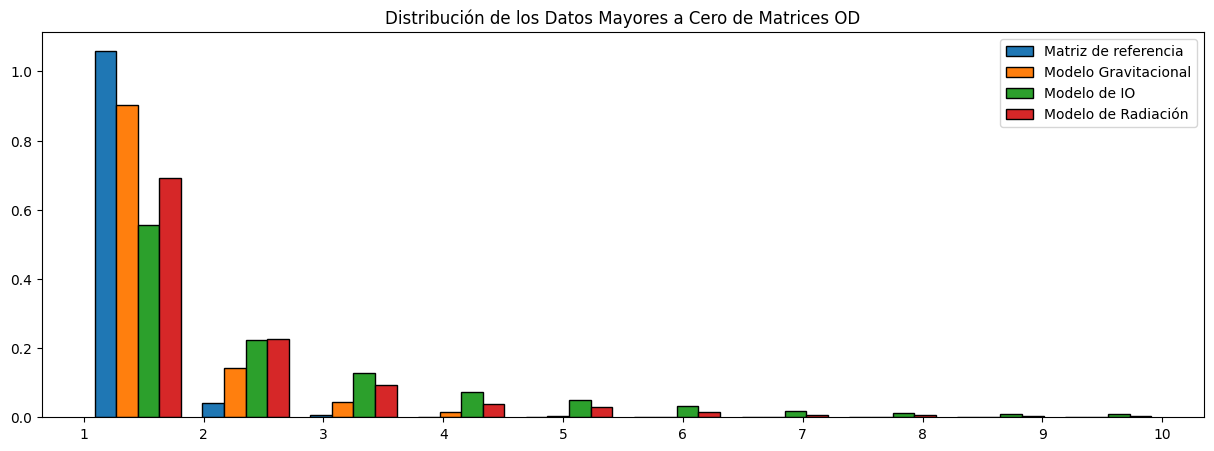

In [ ]:
plt.figure(figsize=(15,5))
plt.hist([PlotOD,PlotGrav,PlotIO,PlotRad],range=(1,10),label=['Matriz de referencia', 'Modelo Gravitacional','Modelo de IO', 'Modelo de Radiación'],edgecolor='black',bins=10,density=True)
plt.xticks(range(1,11))
plt.title('Distribución de los Datos Mayores a Cero de Matrices OD')
plt.legend()
plt.show()

In [ ]:
ErrorRad(FlatO_i,Flatm_i,Flatm_j,FlatVij,FlatOD)

0.0008089834140957124

In [ ]:
ErrorIO(0.6,FlatO_i,FlatVij,FlatauxVij,FlatVin,FlatOD)

0.0012996130239773694

In [ ]:
ErrorGrav(Params,Flatm_i,Flatm_j,Flatrij,FlatOD)

0.0013804205883008235

In [ ]:
np.max(FlatOD),np.max(GravOD),np.max(IOOD),np.max(RadOD)

(10, 10.0, 78.99999999182639, 42.06543675414482)

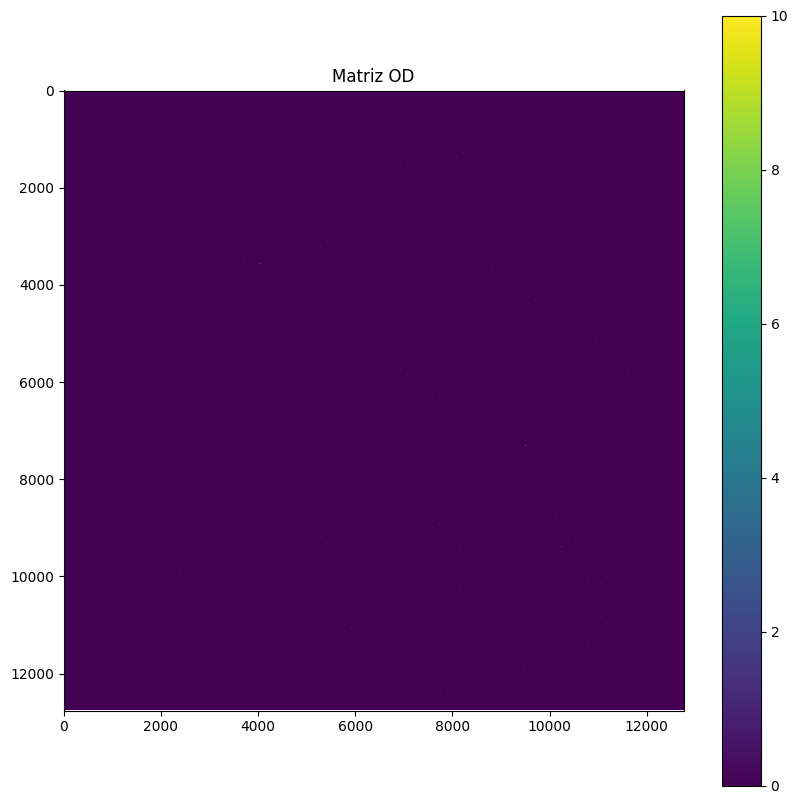

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(ODMatrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Matriz OD')
plt.show()

In [ ]:
indices_no_cero = np.nonzero(ODMatrix)
coordenadas = list(zip(indices_no_cero[0], indices_no_cero[1]))
valores = ODMatrix[indices_no_cero]

array([], dtype=int64)

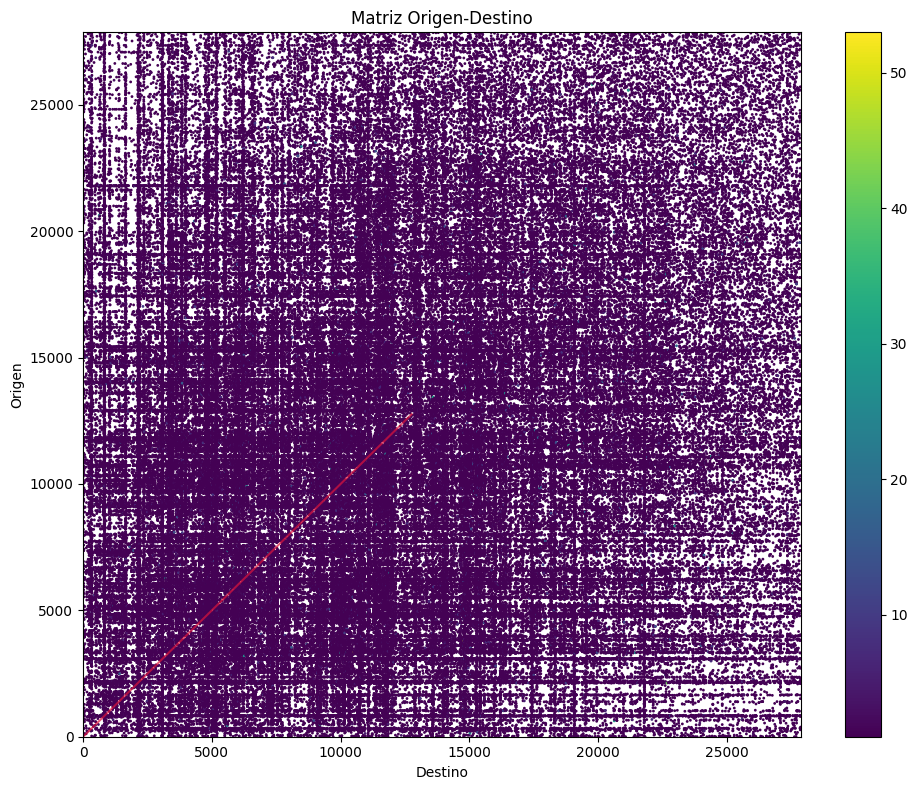

In [ ]:
plt.figure(figsize=(10,8))

plt.scatter(*zip(*coordenadas), c=valores, cmap='viridis', s=1)  # Puedes ajustar 's' para cambiar el tamaño de los puntos
plt.title('Matriz Origen-Destino')
plt.xlabel('Destino')
plt.ylabel('Origen')
plt.tight_layout()
plt.margins(x=0)
plt.margins(y=0)
plt.plot([0,12759],[0,12759],color='crimson',alpha=0.7)
plt.colorbar()

plt.show()

In [ ]:
for i in range(24):
    df_hour = df_ODMatrix[df_ODMatrix['datehour'] == i]
    locals()[f'df_ODMatrix_{i}'] = pd.DataFrame(df_hour)

    df_DTEC_origin = df_hour[df_hour['DTEC_origin'] == 1]
    locals()[f'df_ODMatrix_DTECOrigin_{i}'] = pd.DataFrame(df_DTEC_origin)

    df_DTEC_destin = df_hour[df_hour['DTEC_destination'] == 1]
    locals()[f'df_ODMatrix_DTECDestin_{i}'] = pd.DataFrame(df_DTEC_destin)

    df_DTEC_only = df_hour[(df_hour['DTEC_origin'] == 1) & (df_hour['DTEC_destination'] == 1)]
    locals()[f'df_ODMatrix_DTECOnly_{i}'] = pd.DataFrame(df_DTEC_only)
df_ODMatrix_DTECOnly_0

In [ ]:
dtech3_max = 41
matrixod = ODCalculation(df_ODMatrix_0,len(df_ODMatrix_0))
len(df_ODMatrix_0)

In [ ]:
max_val = np.max(matrixod)
np.argmax(matrixod)

In [ ]:
## create a heatmap using seaborn
#fig, ax = plt.subplots(figsize=(8,8))
#sns.heatmap(matrixod, cmap='viridis', ax=ax)

## customize the plot
#ax.set_xlabel('Destination')
#ax.set_ylabel('Origin')
#ax.set_title('OD Matrix')
#plt.show()

In [ ]:
Parts=[]
def SplitMatrixToSee(matrix,parts):
  size=math.floor(len(matrix)/parts)
  for i in range(parts):
    for j in range(parts):
      Part=[]
      for l in range(size*i,size*(i+1)):
        Part.append(matrix[l][size*j:size*(j+1)])
      Parts.append(Part)

partsnum=50
SplitMatrixToSee(ODMatrix,partsnum)
Parts[2][3][9]

0

In [ ]:
f'The Matrix is divided on {partsnum*partsnum} parts, you are on part [{math.floor(301/partsnum)},{301%partsnum}]\n The size of what you´re looking is {math.floor(len(ODMatrix)/partsnum)}*{math.floor(len(ODMatrix)/partsnum)}'

'The Matrix is divided on 2500 parts, you are on part [6,1]\n The size of what you´re looking is 255*255'

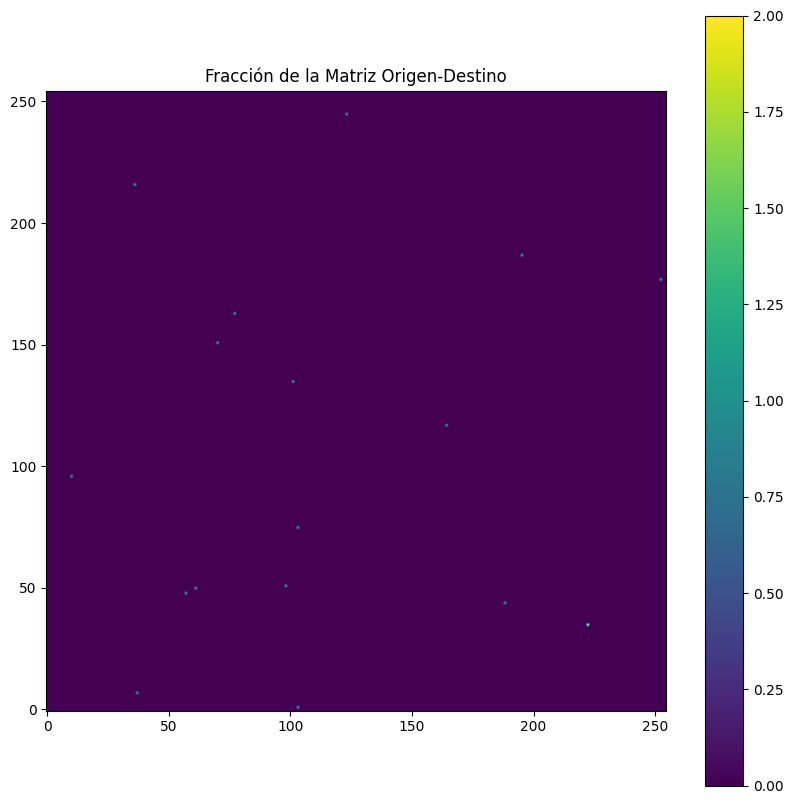

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(Parts[1], origin='lower')
#plt.title(f'The Matrix is divided on {partsnum*partsnum} parts, you are on part [{math.floor(301/partsnum)},{301%partsnum}]\n The size of what you´re looking is {math.floor(len(ODMatrix)/partsnum)}*{math.floor(len(ODMatrix)/partsnum)}')
plt.title('Fracción de la Matriz Origen-Destino')
plt.colorbar()
plt.show()